# Time Series Event Detection

This notebook was created to be shown at FH in Graz during a lecture on time series event detection. Even though a full running example can be found in main.py, this notebook explains the workflow in greater detail. 

It is running on Python 3.8.5 with dependencies listed in the requirements.txt file.

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
#Set devices_id
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
#os.environ["CUDA_VISIBLE_DEVICES"]=""
import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger()

logger.info("Loading packages...")

2023-04-15 18:55:15,953 | INFO : Loading packages...


In [14]:
from config import get_config
from models.model import model_factory
from datasets.data import data_factory_fun
from utils.datagen import UnetGen
from datasets import event as evt
from utils import utils

import json
import pandas as pds
import numpy as np
import random

from datetime import datetime

conf = get_config("")
conf.update(spacecraft='Wind')
#conf.update(data_window_len=2048)
conf.update(experiment_name='ARCANE')
#conf.update(pretrain='True')
#conf.update(reduce_factor=2)
#conf.update(res_depth=3)
#conf.update(resampling='1T')
#conf.update(spacecraft='Wind_Archive')
#conf.update(split='custom')
conf.update(train='True')
conf.update(finetune='False')
conf.update(GPU='1')
conf.update(seed=42)

initial_timestamp = datetime.now()
output_dir = conf['output_dir']
if not os.path.isdir(output_dir):
    raise IOError(
        "Root directory '{}', where the directory of the experiment will be created, must exist".format(output_dir))

output_dir = os.path.join(output_dir, conf['experiment_name'])

formatted_timestamp = initial_timestamp.strftime("%Y-%m-%d_%H-%M-%S")
conf['initial_timestamp'] = formatted_timestamp
conf['output_dir'] = output_dir
conf['save_dir'] = os.path.join(output_dir, 'checkpoints')
conf['model_dir'] = os.path.join(output_dir, 'complete_saved_model')    
conf['pred_dir'] = os.path.join(output_dir, 'predictions')
utils.create_dirs([conf['save_dir'], conf['pred_dir']]) #, config['tensorboard_dir']

# Save configuration as a (pretty) json file
with open(os.path.join(output_dir, 'configuration.json'), 'w') as fp:
    json.dump(conf, fp, indent=4, sort_keys=True)

logger.info("Stored configuration file in '{}'".format(output_dir))

2023-04-15 18:59:44,743 | INFO : Stored configuration file in 'output/ARCANE'


In [15]:
import time
import tensorflow as tf

total_start_time = time.time()
if conf['GPU'] == "":
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]=conf['GPU']

tf.config.list_physical_devices('GPU')

if conf['seed'] is not None:
    os.environ['PYTHONHASHSEED']= '0'
    np.random.seed(conf['seed'])
    random.seed(conf['seed'])
    tf.random.set_seed(conf['seed'])

### Data Preprocessing

In [16]:
data = data_factory_fun(conf)

2023-04-15 18:59:45,966 | INFO : Loading Helio4cast catalog...
2023-04-15 18:59:45,976 | INFO : Loading data...
2023-04-15 18:59:46,083 | INFO : Preprocessing data...
2023-04-15 19:00:55,740 | INFO : Deleting empty events and removing eventless data...
2023-04-15 19:00:55,754 | INFO : data for 2007 added
2023-04-15 19:00:55,768 | INFO : data for 2008 added
2023-04-15 19:00:55,783 | INFO : data for 2009 added
2023-04-15 19:00:55,799 | INFO : data for 2010 added
2023-04-15 19:00:55,816 | INFO : data for 2011 added
2023-04-15 19:00:55,834 | INFO : data for 2012 added
2023-04-15 19:00:55,851 | INFO : data for 2013 added
2023-04-15 19:00:55,868 | INFO : data for 2014 added
2023-04-15 19:00:55,886 | INFO : data for 2015 added
2023-04-15 19:00:55,903 | INFO : data for 2016 added
2023-04-15 19:00:55,921 | INFO : data for 2017 added
2023-04-15 19:00:55,940 | INFO : data for 2018 added
2023-04-15 19:00:55,959 | INFO : data for 2019 added
2023-04-15 19:00:55,979 | INFO : data for 2020 added
2023-

In [17]:
data.all_df

,bx,by,bz,bt,np,vt,tp,beta,pdyn,texrat
2007-01-01 00:00:00,1.223244,-3.684057,0.080246,3.888975,14.843064,331.939625,19413.118748,0.646101,2.735598e-09,0.720593
2007-01-01 00:10:00,0.904688,-4.051442,0.045299,4.161100,14.243541,330.122928,18994.705795,0.536584,2.596340e-09,0.720648
2007-01-01 00:20:00,0.312468,-2.719409,0.975117,3.160475,13.780732,328.747382,25637.551120,1.314895,2.491679e-09,0.989950
2007-01-01 00:30:00,0.474564,-3.092976,2.184967,3.827333,11.695232,327.928269,24874.101495,0.706274,2.102951e-09,0.969686
2007-01-01 00:40:00,-0.231472,-1.247858,1.323667,2.355408,12.056670,329.629053,27510.974241,3.107292,2.192419e-09,1.051816
...,...,...,...,...,...,...,...,...,...,...
2021-04-28 23:10:00,-0.941782,1.187671,0.184250,1.526914,4.161323,368.055969,12093.222967,0.748976,9.428810e-10,0.303752
2021-04-28 23:20:00,-0.941784,1.187670,0.184250,1.526914,4.161323,368.055969,12093.222967,0.748976,9.428810e-10,0.303752
2021-04-28 23:30:00,-0.941785,1.187669,0.184249,1.526914,4.161323,368.055969,12093.222967,0.748976,9.428810e-10,0.303752
2021-04-28 23:40:00,-0.941786,1.187668,0.184248,1.526914,4.161323,368.055969,12093.222967,0.748976,9.428810e-10,0.303752


In [18]:
for i in range (4):
    print(str(data.evtlist[i])) # each event is stored in a list with "begin" and "end"

2021-04-24 22:30:00 ---> 2021-04-25 22:46:00
2021-04-15 03:16:00 ---> 2021-04-15 13:12:00
2021-04-04 21:52:00 ---> 2021-04-06 10:02:00
2021-03-26 18:00:00 ---> 2021-03-27 19:02:00


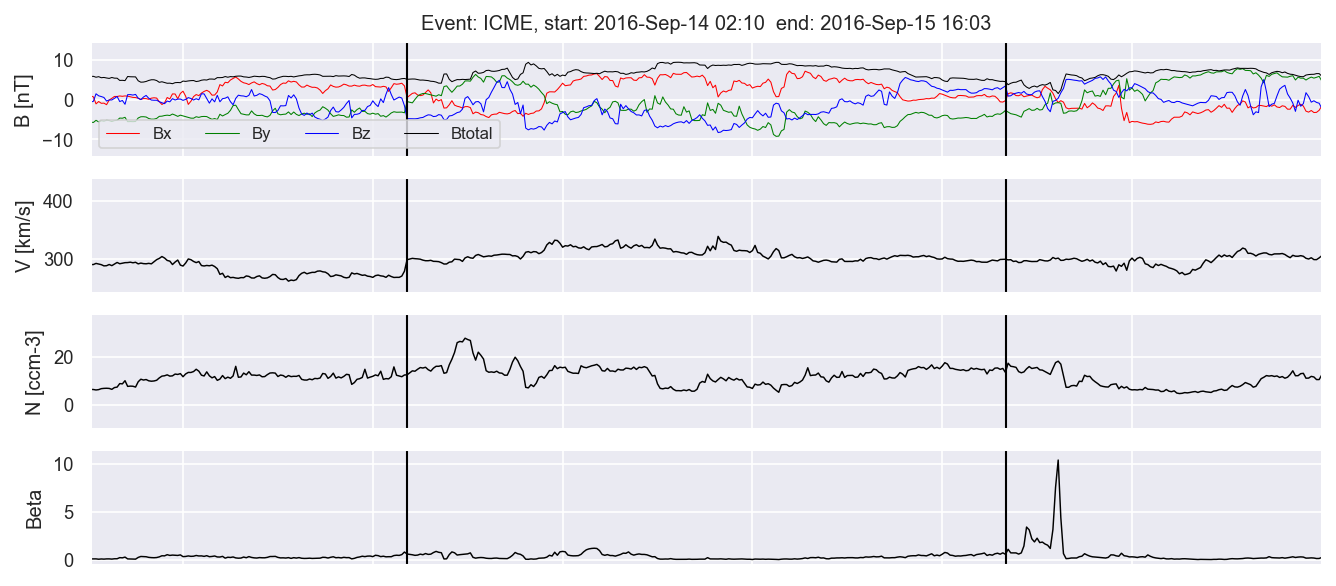

In [19]:
data.evtlist[42].iwfplotnopred(data.all_df, 20, 'Event: ')

### Model and Data Generator

In [20]:
model, callbacks = model_factory(conf, data)

2023-04-15 19:00:58,202 | INFO : Feature dimension equals 10
2023-04-15 19:00:58,203 | INFO : Sequence length equals 1024
2023-04-15 19:00:58,203 | INFO : Image size equals (1024, 1, 10)
2023-04-15 19:00:58,203 | INFO : Choosing model architecture: ResUNet
2023-04-15 19:00:58,203 | INFO : Building model for Seq2Seq
2023-04-15 19:00:58,500 | INFO : Created ResUNet!
2023-04-15 19:00:58,500 | INFO : Selecting optimizer
2023-04-15 19:00:58,501 | INFO : Setting Adam optimizer...
2023-04-15 19:00:58,502 | INFO : Selecting metrics
2023-04-15 19:00:58,507 | INFO : Selecting loss
2023-04-15 19:00:58,508 | INFO : Compiling model...
2023-04-15 19:00:58,512 | INFO : Setting callbacks...
2023-04-15 19:00:58,513 | INFO : Using cyclic learning rate...
2023-04-15 19:00:58,513 | INFO : Early Stopping will be done after 50 epochs of no improvement


In [21]:
model.summary()

Model: "ResUNetPlusPlusSeq2Seq"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1024, 1, 10  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 1024, 1, 64)  1984        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_28 (BatchN  (None, 1024, 1, 64)  256        ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                             

In [22]:
callbacks

In [23]:
train_gen = UnetGen('train', conf, data)
val_gen = UnetGen('val', conf, data)

2023-04-15 19:22:36,152 | INFO : Initializing data generator for training...
2023-04-15 19:22:36,152 | INFO : Initializing data generator for validation...


In [24]:
import tensorflow as tf

model.fit(train_gen,validation_data=val_gen,epochs=conf['epochs'],callbacks=callbacks)

Epoch 1/400


2023-04-15 19:22:37.608563: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-15 19:22:38.952919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x330cbf5b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  1/120 [..............................] - ETA: 11:12 - loss: 1.0000 - accuracy: 32768.0000 - recall_1: 0.5823 - precision_1: 0.0205 - dice_coef: 0.0000e+00 - true_skill_score: 1368.3813 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2852b5870>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  6/120 [>.............................] - ETA: 3:18 - loss: 0.9301 - accuracy: 0.0016 - recall_1: 0.5636 - precision_1: 0.0391 - dice_coef: 0.0699 - true_skill_score: 228.1057 - mean_io_u_1: 0.4773      

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2dfa226f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  8/120 [=>............................] - ETA: 3:09 - loss: 0.8053 - accuracy: 0.0014 - recall_1: 0.6015 - precision_1: 0.0446 - dice_coef: 0.0778 - true_skill_score: 195.5416 - mean_io_u_1: 0.4719         

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3086e3870>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 11/120 [=>............................] - ETA: 3:09 - loss: 0.8375 - accuracy: 0.0019 - recall_1: 0.6242 - precision_1: 0.0453 - dice_coef: 0.0775 - true_skill_score: 136.9071 - mean_io_u_1: 0.4814  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3086e64d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 14/120 [==>...........................] - ETA: 2:55 - loss: 0.8572 - accuracy: 0.0018 - recall_1: 0.6164 - precision_1: 0.0447 - dice_coef: 0.0760 - true_skill_score: 105.3385 - mean_io_u_1: 0.4842  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3086f9b20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 19/120 [===>..........................] - ETA: 2:46 - loss: 0.8711 - accuracy: 0.0017 - recall_1: 0.6280 - precision_1: 0.0468 - dice_coef: 0.0797 - true_skill_score: 76.1135 - mean_io_u_1: 0.4849 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2852c5110>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 24/120 [=====>........................] - ETA: 2:40 - loss: 0.8777 - accuracy: 0.0016 - recall_1: 0.6235 - precision_1: 0.0487 - dice_coef: 0.0833 - true_skill_score: 59.5969 - mean_io_u_1: 0.4862

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2dfa1a120>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 27/120 [=====>........................] - ETA: 2:35 - loss: 0.8795 - accuracy: 0.0016 - recall_1: 0.6258 - precision_1: 0.0508 - dice_coef: 0.0859 - true_skill_score: 52.7373 - mean_io_u_1: 0.4873   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x308781450>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 29/120 [======>.......................] - ETA: 2:32 - loss: 0.8804 - accuracy: 0.0016 - recall_1: 0.6187 - precision_1: 0.0516 - dice_coef: 0.0874 - true_skill_score: 48.9788 - mean_io_u_1: 0.4866 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3086fd810>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 32/120 [=======>......................] - ETA: 2:28 - loss: 0.8822 - accuracy: 0.0015 - recall_1: 0.6217 - precision_1: 0.0526 - dice_coef: 0.0886 - true_skill_score: 44.2557 - mean_io_u_1: 0.4872   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2dfa43420>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 48/120 [===========>..................] - ETA: 1:59 - loss: 0.8831 - accuracy: 0.0014 - recall_1: 0.6052 - precision_1: 0.0597 - dice_coef: 0.0974 - true_skill_score: 29.2456 - mean_io_u_1: 0.4841

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x281171f50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 51/120 [===========>..................] - ETA: 1:55 - loss: 0.8850 - accuracy: 0.0013 - recall_1: 0.6027 - precision_1: 0.0597 - dice_coef: 0.0967 - true_skill_score: 27.4988 - mean_io_u_1: 0.4844   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x281146860>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 55/120 [============>.................] - ETA: 1:48 - loss: 0.8852 - accuracy: 0.0013 - recall_1: 0.6008 - precision_1: 0.0610 - dice_coef: 0.0978 - true_skill_score: 25.4734 - mean_io_u_1: 0.4843  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x280c12440>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 57/120 [=============>................] - ETA: 1:45 - loss: 0.8837 - accuracy: 0.0013 - recall_1: 0.6027 - precision_1: 0.0626 - dice_coef: 0.0998 - true_skill_score: 24.5714 - mean_io_u_1: 0.4838    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3087cec90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 59/120 [=============>................] - ETA: 1:41 - loss: 0.8836 - accuracy: 0.0013 - recall_1: 0.6019 - precision_1: 0.0633 - dice_coef: 0.1006 - true_skill_score: 23.7304 - mean_io_u_1: 0.4835    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x280c613c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 61/120 [==============>...............] - ETA: 1:37 - loss: 0.8831 - accuracy: 0.0012 - recall_1: 0.5945 - precision_1: 0.0640 - dice_coef: 0.1015 - true_skill_score: 22.9416 - mean_io_u_1: 0.4829    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x285607770>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 62/120 [==============>...............] - ETA: 1:35 - loss: 0.8837 - accuracy: 0.0012 - recall_1: 0.5955 - precision_1: 0.0642 - dice_coef: 0.1013 - true_skill_score: 22.5694 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286d6fc40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 64/120 [===============>..............] - ETA: 1:32 - loss: 0.8842 - accuracy: 0.0013 - recall_1: 0.5952 - precision_1: 0.0645 - dice_coef: 0.1012 - true_skill_score: 21.8583 - mean_io_u_1: 0.4831   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x281159850>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 65/120 [===============>..............] - ETA: 1:30 - loss: 0.8843 - accuracy: 0.0012 - recall_1: 0.5938 - precision_1: 0.0647 - dice_coef: 0.1013 - true_skill_score: 21.5185 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2dfa81040>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 68/120 [================>.............] - ETA: 1:25 - loss: 0.8841 - accuracy: 0.0012 - recall_1: 0.5940 - precision_1: 0.0656 - dice_coef: 0.1021 - true_skill_score: 20.5648 - mean_io_u_1: 0.4832   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2dfa838e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 69/120 [================>.............] - ETA: 1:23 - loss: 0.8842 - accuracy: 0.0012 - recall_1: 0.5942 - precision_1: 0.0657 - dice_coef: 0.1022 - true_skill_score: 20.2647 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286d85330>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 71/120 [================>.............] - ETA: 1:20 - loss: 0.8832 - accuracy: 0.0012 - recall_1: 0.5943 - precision_1: 0.0669 - dice_coef: 0.1036 - true_skill_score: 19.6910 - mean_io_u_1: 0.4829    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x29397fc20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 74/120 [=================>............] - ETA: 1:15 - loss: 0.8829 - accuracy: 0.0012 - recall_1: 0.5963 - precision_1: 0.0681 - dice_coef: 0.1045 - true_skill_score: 18.8899 - mean_io_u_1: 0.4824   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2811602c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 75/120 [=================>............] - ETA: 1:13 - loss: 0.8831 - accuracy: 0.0012 - recall_1: 0.5951 - precision_1: 0.0681 - dice_coef: 0.1044 - true_skill_score: 18.6364 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x280c7f9b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 76/120 [==================>...........] - ETA: 1:11 - loss: 0.8836 - accuracy: 0.0012 - recall_1: 0.5946 - precision_1: 0.0679 - dice_coef: 0.1041 - true_skill_score: 18.3895 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x280c7f9b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 77/120 [==================>...........] - ETA: 1:10 - loss: 0.8838 - accuracy: 0.0012 - recall_1: 0.5929 - precision_1: 0.0680 - dice_coef: 0.1040 - true_skill_score: 18.1482 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2dfa8b5f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 79/120 [==================>...........] - ETA: 1:06 - loss: 0.8840 - accuracy: 0.0011 - recall_1: 0.5935 - precision_1: 0.0685 - dice_coef: 0.1041 - true_skill_score: 17.6879 - mean_io_u_1: 0.4825    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28114d470>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 81/120 [===================>..........] - ETA: 1:03 - loss: 0.8841 - accuracy: 0.0011 - recall_1: 0.5932 - precision_1: 0.0689 - dice_coef: 0.1044 - true_skill_score: 17.2499 - mean_io_u_1: 0.4824    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3087c68b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 83/120 [===================>..........] - ETA: 59s - loss: 0.8840 - accuracy: 0.0011 - recall_1: 0.5920 - precision_1: 0.0693 - dice_coef: 0.1047 - true_skill_score: 16.8337 - mean_io_u_1: 0.4825     

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x293991230>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 85/120 [====================>.........] - ETA: 56s - loss: 0.8832 - accuracy: 0.0012 - recall_1: 0.5929 - precision_1: 0.0702 - dice_coef: 0.1058 - true_skill_score: 16.4379 - mean_io_u_1: 0.4822    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3087e6d90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 87/120 [====================>.........] - ETA: 53s - loss: 0.8843 - accuracy: 0.0012 - recall_1: 0.5913 - precision_1: 0.0699 - dice_coef: 0.1049 - true_skill_score: 16.0576 - mean_io_u_1: 0.4825    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28114d470>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 88/120 [=====================>........] - ETA: 51s - loss: 0.8843 - accuracy: 0.0012 - recall_1: 0.5894 - precision_1: 0.0700 - dice_coef: 0.1051 - true_skill_score: 15.8741 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2939a9d70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 90/120 [=====================>........] - ETA: 48s - loss: 0.8848 - accuracy: 0.0012 - recall_1: 0.5881 - precision_1: 0.0700 - dice_coef: 0.1048 - true_skill_score: 15.5214 - mean_io_u_1: 0.4828    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28117c240>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 93/120 [======================>.......] - ETA: 43s - loss: 0.8850 - accuracy: 0.0012 - recall_1: 0.5859 - precision_1: 0.0702 - dice_coef: 0.1049 - true_skill_score: 15.0199 - mean_io_u_1: 0.4828  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x280ca08f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


101/120 [========================>.....] - ETA: 30s - loss: 0.8853 - accuracy: 0.0012 - recall_1: 0.5856 - precision_1: 0.0712 - dice_coef: 0.1055 - true_skill_score: 13.8330 - mean_io_u_1: 0.4842

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286dfec40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


102/120 [========================>.....] - ETA: 28s - loss: 0.8847 - accuracy: 0.0012 - recall_1: 0.5859 - precision_1: 0.0717 - dice_coef: 0.1061 - true_skill_score: 13.6981 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x285649240>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


104/120 [=========================>....] - ETA: 25s - loss: 0.8849 - accuracy: 0.0012 - recall_1: 0.5835 - precision_1: 0.0717 - dice_coef: 0.1061 - true_skill_score: 13.4344 - mean_io_u_1: 0.4841    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2856561d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


107/120 [=========================>....] - ETA: 20s - loss: 0.8859 - accuracy: 0.0012 - recall_1: 0.5840 - precision_1: 0.0714 - dice_coef: 0.1054 - true_skill_score: 13.0591 - mean_io_u_1: 0.4848

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2dfac4620>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


115/120 [===========================>..] - ETA: 8s - loss: 0.8853 - accuracy: 0.0012 - recall_1: 0.5882 - precision_1: 0.0729 - dice_coef: 0.1066 - true_skill_score: 12.1610 - mean_io_u_1: 0.4849

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28564b8f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


116/120 [============================>.] - ETA: 6s - loss: 0.8861 - accuracy: 0.0012 - recall_1: 0.5881 - precision_1: 0.0724 - dice_coef: 0.1058 - true_skill_score: 12.0561 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28566cfd0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


117/120 [============================>.] - ETA: 4s - loss: 0.8858 - accuracy: 0.0012 - recall_1: 0.5904 - precision_1: 0.0728 - dice_coef: 0.1062 - true_skill_score: 11.9559 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28567d4c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.8856 - accuracy: 0.0012 - recall_1: 0.5857 - precision_1: 0.0731 - dice_coef: 0.1066 - true_skill_score: 11.6576 - mean_io_u_1: 0.4845   

2023-04-15 19:25:54.092250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ee283c70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3095ae650>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQu


Epoch 1: val_loss improved from inf to 0.85152, saving model to output/ARCANE/checkpoints/resunet_seq2seq_1


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3191f8cd0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
2023-04-15 19:26:11,334 | WARNING : Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 32). These functions will not be directly callable after loading.
2023-04-15 19:26:13,033 | INFO : Assets written to: output/ARCANE/checkpoints/resunet_seq2seq_1/assets


120/120 [==============================] - 216s 2s/step - loss: 0.8856 - accuracy: 0.0012 - recall_1: 0.5857 - precision_1: 0.0731 - dice_coef: 0.1066 - true_skill_score: 11.6576 - mean_io_u_1: 0.4845 - val_loss: 0.8515 - val_accuracy: 1.7621e-04 - val_recall_1: 0.4764 - val_precision_1: 0.1724 - val_dice_coef: 0.1485 - val_true_skill_score: 0.1620 - val_mean_io_u_1: 0.4692
Epoch 2/400
  3/120 [..............................] - ETA: 3:05 - loss: 0.8743 - accuracy: 0.0022 - recall_1: 0.4651 - precision_1: 0.0940 - dice_coef: 0.1257 - true_skill_score: 0.1109 - mean_io_u_1: 0.4870  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x319511d80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  4/120 [>.............................] - ETA: 3:01 - loss: 0.8816 - accuracy: 0.0021 - recall_1: 0.4632 - precision_1: 0.0853 - dice_coef: 0.1184 - true_skill_score: 0.1095 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd1cc10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  6/120 [>.............................] - ETA: 2:55 - loss: 0.8841 - accuracy: 0.0021 - recall_1: 0.4871 - precision_1: 0.0843 - dice_coef: 0.1159 - true_skill_score: 0.1405 - mean_io_u_1: 0.4944    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x35b5e9140>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  7/120 [>.............................] - ETA: 2:54 - loss: 0.8932 - accuracy: 0.0019 - recall_1: 0.4856 - precision_1: 0.0747 - dice_coef: 0.1068 - true_skill_score: 0.1275 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2dfae4590>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  8/120 [=>............................] - ETA: 2:54 - loss: 0.8892 - accuracy: 0.0019 - recall_1: 0.5034 - precision_1: 0.0778 - dice_coef: 0.1108 - true_skill_score: 0.1389 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2dfae4160>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  9/120 [=>............................] - ETA: 2:53 - loss: 0.8837 - accuracy: 0.0019 - recall_1: 0.5106 - precision_1: 0.0826 - dice_coef: 0.1163 - true_skill_score: 0.1476 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3196c8b90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 11/120 [=>............................] - ETA: 2:46 - loss: 0.8839 - accuracy: 0.0017 - recall_1: 0.5187 - precision_1: 0.0831 - dice_coef: 0.1161 - true_skill_score: 0.1637 - mean_io_u_1: 0.4950  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x334344950>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 13/120 [==>...........................] - ETA: 2:43 - loss: 0.8823 - accuracy: 0.0016 - recall_1: 0.5216 - precision_1: 0.0853 - dice_coef: 0.1177 - true_skill_score: 0.1730 - mean_io_u_1: 0.4913    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x35b5e9140>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 16/120 [===>..........................] - ETA: 2:37 - loss: 0.8816 - accuracy: 0.0015 - recall_1: 0.5444 - precision_1: 0.0874 - dice_coef: 0.1184 - true_skill_score: 0.1833 - mean_io_u_1: 0.4897  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31ddfba90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 18/120 [===>..........................] - ETA: 2:36 - loss: 0.8842 - accuracy: 0.0014 - recall_1: 0.5555 - precision_1: 0.0855 - dice_coef: 0.1158 - true_skill_score: 0.1980 - mean_io_u_1: 0.4889    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd15ce0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 19/120 [===>..........................] - ETA: 2:33 - loss: 0.8832 - accuracy: 0.0014 - recall_1: 0.5686 - precision_1: 0.0869 - dice_coef: 0.1168 - true_skill_score: 0.2092 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd2bc70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 21/120 [====>.........................] - ETA: 2:30 - loss: 0.8859 - accuracy: 0.0013 - recall_1: 0.5746 - precision_1: 0.0855 - dice_coef: 0.1141 - true_skill_score: 0.2185 - mean_io_u_1: 0.4892    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x377a9a770>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 23/120 [====>.........................] - ETA: 2:29 - loss: 0.8860 - accuracy: 0.0015 - recall_1: 0.5768 - precision_1: 0.0859 - dice_coef: 0.1140 - true_skill_score: 0.2198 - mean_io_u_1: 0.4892    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31ddfce90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 29/120 [======>.......................] - ETA: 2:26 - loss: 0.8819 - accuracy: 0.0017 - recall_1: 0.5912 - precision_1: 0.0879 - dice_coef: 0.1181 - true_skill_score: 0.2174 - mean_io_u_1: 0.4923

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3341cef00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 31/120 [======>.......................] - ETA: 2:25 - loss: 0.8850 - accuracy: 0.0016 - recall_1: 0.5914 - precision_1: 0.0836 - dice_coef: 0.1150 - true_skill_score: 0.2099 - mean_io_u_1: 0.4925    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3342f5710>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 37/120 [========>.....................] - ETA: 2:15 - loss: 0.8871 - accuracy: 0.0016 - recall_1: 0.5915 - precision_1: 0.0788 - dice_coef: 0.1129 - true_skill_score: 0.1930 - mean_io_u_1: 108.9231

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5318570>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 38/120 [========>.....................] - ETA: 2:14 - loss: 0.8872 - accuracy: 0.0016 - recall_1: 0.5952 - precision_1: 0.0785 - dice_coef: 0.1128 - true_skill_score: 0.1924 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3346e1500>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 39/120 [========>.....................] - ETA: 2:12 - loss: 0.8873 - accuracy: 0.0016 - recall_1: 0.5998 - precision_1: 0.0783 - dice_coef: 0.1127 - true_skill_score: 0.1945 - mean_io_u_1: 0.4909    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357f61e70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 40/120 [=========>....................] - ETA: 2:10 - loss: 0.8890 - accuracy: 0.0016 - recall_1: 0.6016 - precision_1: 0.0766 - dice_coef: 0.1110 - true_skill_score: 0.1945 - mean_io_u_1: 0.4908

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3196a8ec0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 46/120 [==========>...................] - ETA: 2:01 - loss: 0.8918 - accuracy: 0.0016 - recall_1: 0.6089 - precision_1: 0.0728 - dice_coef: 0.1082 - true_skill_score: 0.1859 - mean_io_u_1: 0.4923

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a530cab0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 47/120 [==========>...................] - ETA: 2:00 - loss: 0.8921 - accuracy: 0.0016 - recall_1: 0.6105 - precision_1: 0.0724 - dice_coef: 0.1079 - true_skill_score: 0.1845 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3343b52c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 48/120 [===========>..................] - ETA: 1:58 - loss: 0.8924 - accuracy: 0.0016 - recall_1: 0.6093 - precision_1: 0.0721 - dice_coef: 0.1076 - true_skill_score: 0.1825 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x35b1f7110>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 51/120 [===========>..................] - ETA: 1:52 - loss: 0.8936 - accuracy: 0.0016 - recall_1: 0.6185 - precision_1: 0.0707 - dice_coef: 0.1064 - true_skill_score: 0.1823 - mean_io_u_1: 0.4924

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2871deb10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 53/120 [============>.................] - ETA: 1:48 - loss: 0.8937 - accuracy: 0.0015 - recall_1: 0.6226 - precision_1: 0.0704 - dice_coef: 0.1063 - true_skill_score: 0.1839 - mean_io_u_1: 0.4919    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288847f40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 54/120 [============>.................] - ETA: 1:47 - loss: 0.8941 - accuracy: 0.0015 - recall_1: 0.6247 - precision_1: 0.0701 - dice_coef: 0.1059 - true_skill_score: 0.1846 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357f75420>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 55/120 [============>.................] - ETA: 1:46 - loss: 0.8939 - accuracy: 0.0016 - recall_1: 0.6263 - precision_1: 0.0701 - dice_coef: 0.1061 - true_skill_score: 0.1851 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28863f7d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 58/120 [=============>................] - ETA: 1:41 - loss: 0.8936 - accuracy: 0.0016 - recall_1: 0.6355 - precision_1: 0.0697 - dice_coef: 0.1064 - true_skill_score: 0.1872 - mean_io_u_1: 0.4913  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2871e0ba0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 59/120 [=============>................] - ETA: 1:40 - loss: 0.8922 - accuracy: 0.0016 - recall_1: 0.6374 - precision_1: 0.0708 - dice_coef: 0.1078 - true_skill_score: 0.1868 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357f7d990>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 61/120 [==============>...............] - ETA: 1:36 - loss: 0.8904 - accuracy: 0.0016 - recall_1: 0.6426 - precision_1: 0.0724 - dice_coef: 0.1096 - true_skill_score: 0.1868 - mean_io_u_1: 0.4900    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2871fcf60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 64/120 [===============>..............] - ETA: 1:31 - loss: 0.8908 - accuracy: 0.0016 - recall_1: 0.6467 - precision_1: 0.0712 - dice_coef: 0.1092 - true_skill_score: 0.1839 - mean_io_u_1: 0.4904  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357eb7170>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 70/120 [================>.............] - ETA: 1:22 - loss: 0.8940 - accuracy: 0.0015 - recall_1: 0.6423 - precision_1: 0.0676 - dice_coef: 0.1060 - true_skill_score: 0.1734 - mean_io_u_1: 0.4905

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28717e6e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 72/120 [=================>............] - ETA: 1:19 - loss: 0.8947 - accuracy: 0.0015 - recall_1: 0.6371 - precision_1: 0.0666 - dice_coef: 0.1053 - true_skill_score: 0.1681 - mean_io_u_1: 0.4901

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2871ec7d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 84/120 [====================>.........] - ETA: 58s - loss: 0.9004 - accuracy: 0.0014 - recall_1: 0.6176 - precision_1: 0.0605 - dice_coef: 0.0996 - true_skill_score: 0.1395 - mean_io_u_1: 0.4897 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357fac890>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 95/120 [======================>.......] - ETA: 40s - loss: 0.9026 - accuracy: 0.0013 - recall_1: 0.6104 - precision_1: 0.0585 - dice_coef: 0.0974 - true_skill_score: 0.1286 - mean_io_u_1: 0.4891

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3192d0f60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 97/120 [=======================>......] - ETA: 37s - loss: 0.9031 - accuracy: 0.0013 - recall_1: 0.6075 - precision_1: 0.0578 - dice_coef: 0.0969 - true_skill_score: 0.1253 - mean_io_u_1: 0.4890    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357fcc670>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


101/120 [========================>.....] - ETA: 30s - loss: 0.9035 - accuracy: 0.0013 - recall_1: 0.6042 - precision_1: 0.0573 - dice_coef: 0.0965 - true_skill_score: 0.1219 - mean_io_u_1: 0.4885  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2871bec40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


110/120 [==========================>...] - ETA: 16s - loss: 0.9045 - accuracy: 0.0012 - recall_1: 0.6000 - precision_1: 0.0571 - dice_coef: 0.0955 - true_skill_score: 0.1188 - mean_io_u_1: 0.4882

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2871bb5f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


111/120 [==========================>...] - ETA: 14s - loss: 0.9048 - accuracy: 0.0012 - recall_1: 0.5969 - precision_1: 0.0568 - dice_coef: 0.0952 - true_skill_score: 0.1165 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x35b56d5b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


114/120 [===========================>..] - ETA: 9s - loss: 0.9047 - accuracy: 0.0012 - recall_1: 0.5951 - precision_1: 0.0569 - dice_coef: 0.0953 - true_skill_score: 0.1159 - mean_io_u_1: 0.4884    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357fb6330>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


117/120 [============================>.] - ETA: 4s - loss: 0.9037 - accuracy: 0.0012 - recall_1: 0.5934 - precision_1: 0.0576 - dice_coef: 0.0963 - true_skill_score: 0.1169 - mean_io_u_1: 0.4888  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2871a5fe0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.9031 - accuracy: 0.0013 - recall_1: 0.5925 - precision_1: 0.0581 - dice_coef: 0.0969 - true_skill_score: 0.1191 - mean_io_u_1: 0.4890  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x37a36e4f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3488ff110>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r


Epoch 2: val_loss improved from 0.85152 to 0.80291, saving model to output/ARCANE/checkpoints/resunet_seq2seq_1


2023-04-15 19:29:48,205 | WARNING : Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 32). These functions will not be directly callable after loading.
2023-04-15 19:29:49,944 | INFO : Assets written to: output/ARCANE/checkpoints/resunet_seq2seq_1/assets


120/120 [==============================] - 217s 2s/step - loss: 0.9031 - accuracy: 0.0013 - recall_1: 0.5925 - precision_1: 0.0581 - dice_coef: 0.0969 - true_skill_score: 0.1191 - mean_io_u_1: 0.4890 - val_loss: 0.8029 - val_accuracy: 0.0049 - val_recall_1: 0.4190 - val_precision_1: 0.1610 - val_dice_coef: 0.1697 - val_true_skill_score: 0.2843 - val_mean_io_u_1: 0.5036
Epoch 3/400


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357cef4a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  3/120 [..............................] - ETA: 3:06 - loss: 0.9016 - accuracy: 0.0025 - recall_1: 0.5964 - precision_1: 0.0639 - dice_coef: 0.0984 - true_skill_score: 0.1743 - mean_io_u_1: 0.4889  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d63be150>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 14/120 [==>...........................] - ETA: 2:43 - loss: 0.8974 - accuracy: 0.0011 - recall_1: 0.5845 - precision_1: 0.0703 - dice_coef: 0.1026 - true_skill_score: 0.1566 - mean_io_u_1: 0.4867

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357c2c860>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 20/120 [====>.........................] - ETA: 2:34 - loss: 0.8880 - accuracy: 9.0942e-04 - recall_1: 0.5758 - precision_1: 0.0787 - dice_coef: 0.1120 - true_skill_score: 0.1653 - mean_io_u_1: 0.4826

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d62da2c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 28/120 [======>.......................] - ETA: 2:22 - loss: 0.8826 - accuracy: 0.0012 - recall_1: 0.5919 - precision_1: 0.0842 - dice_coef: 0.1174 - true_skill_score: 0.1853 - mean_io_u_1: 0.4857

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a53a0690>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 32/120 [=======>......................] - ETA: 2:17 - loss: 0.8814 - accuracy: 0.0013 - recall_1: 0.6038 - precision_1: 0.0855 - dice_coef: 0.1186 - true_skill_score: 0.2004 - mean_io_u_1: 0.4870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x377f78c10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 33/120 [=======>......................] - ETA: 2:16 - loss: 0.8800 - accuracy: 0.0013 - recall_1: 0.6053 - precision_1: 0.0867 - dice_coef: 0.1200 - true_skill_score: 0.2021 - mean_io_u_1: 94.1144

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33424fc30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 34/120 [=======>......................] - ETA: 2:14 - loss: 0.8776 - accuracy: 0.0014 - recall_1: 0.6091 - precision_1: 0.0888 - dice_coef: 0.1224 - true_skill_score: 0.2047 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2886c3920>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 36/120 [========>.....................] - ETA: 2:12 - loss: 0.8763 - accuracy: 0.0014 - recall_1: 0.6132 - precision_1: 0.0899 - dice_coef: 0.1237 - true_skill_score: 0.2091 - mean_io_u_1: 0.4863  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357c31150>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 38/120 [========>.....................] - ETA: 2:11 - loss: 0.8763 - accuracy: 0.0014 - recall_1: 0.6182 - precision_1: 0.0905 - dice_coef: 0.1237 - true_skill_score: 0.2185 - mean_io_u_1: 0.4861    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357c2b530>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 42/120 [=========>....................] - ETA: 2:06 - loss: 0.8735 - accuracy: 0.0016 - recall_1: 0.6290 - precision_1: 0.0926 - dice_coef: 0.1265 - true_skill_score: 0.2331 - mean_io_u_1: 0.4883

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e74570>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 43/120 [=========>....................] - ETA: 2:04 - loss: 0.8732 - accuracy: 0.0017 - recall_1: 0.6310 - precision_1: 0.0930 - dice_coef: 0.1268 - true_skill_score: 0.2364 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e6c8b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 44/120 [==========>...................] - ETA: 2:03 - loss: 0.8736 - accuracy: 0.0017 - recall_1: 0.6315 - precision_1: 0.0926 - dice_coef: 0.1264 - true_skill_score: 0.2385 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357c4aab0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 46/120 [==========>...................] - ETA: 1:58 - loss: 0.8733 - accuracy: 0.0017 - recall_1: 0.6326 - precision_1: 0.0933 - dice_coef: 0.1267 - true_skill_score: 0.2406 - mean_io_u_1: 0.4886    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x280ccfa60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 48/120 [===========>..................] - ETA: 1:55 - loss: 0.8728 - accuracy: 0.0016 - recall_1: 0.6297 - precision_1: 0.0933 - dice_coef: 0.1272 - true_skill_score: 0.2399 - mean_io_u_1: 0.4883    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a53aca70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 49/120 [===========>..................] - ETA: 1:54 - loss: 0.8730 - accuracy: 0.0016 - recall_1: 0.6310 - precision_1: 0.0932 - dice_coef: 0.1270 - true_skill_score: 0.2429 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x377ae2a80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 50/120 [===========>..................] - ETA: 1:52 - loss: 0.8725 - accuracy: 0.0016 - recall_1: 0.6314 - precision_1: 0.0936 - dice_coef: 0.1275 - true_skill_score: 0.2444 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2886c3920>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 51/120 [===========>..................] - ETA: 1:50 - loss: 0.8725 - accuracy: 0.0017 - recall_1: 0.6314 - precision_1: 0.0934 - dice_coef: 0.1275 - true_skill_score: 0.2476 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5384420>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 52/120 [============>.................] - ETA: 1:49 - loss: 0.8715 - accuracy: 0.0017 - recall_1: 0.6330 - precision_1: 0.0941 - dice_coef: 0.1285 - true_skill_score: 0.2494 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a51101d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 53/120 [============>.................] - ETA: 1:47 - loss: 0.8710 - accuracy: 0.0018 - recall_1: 0.6348 - precision_1: 0.0947 - dice_coef: 0.1290 - true_skill_score: 0.2520 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357c3b530>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 55/120 [============>.................] - ETA: 1:44 - loss: 0.8697 - accuracy: 0.0018 - recall_1: 0.6381 - precision_1: 0.0956 - dice_coef: 0.1303 - true_skill_score: 0.2579 - mean_io_u_1: 0.4893  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5163f20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 56/120 [=============>................] - ETA: 1:42 - loss: 0.8690 - accuracy: 0.0018 - recall_1: 0.6390 - precision_1: 0.0960 - dice_coef: 0.1310 - true_skill_score: 0.2602 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357c37040>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 58/120 [=============>................] - ETA: 1:39 - loss: 0.8676 - accuracy: 0.0018 - recall_1: 0.6371 - precision_1: 0.0967 - dice_coef: 0.1324 - true_skill_score: 0.2624 - mean_io_u_1: 0.4892    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a512db50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 60/120 [==============>...............] - ETA: 1:35 - loss: 0.8664 - accuracy: 0.0019 - recall_1: 0.6357 - precision_1: 0.0972 - dice_coef: 0.1336 - true_skill_score: 0.2640 - mean_io_u_1: 0.4889    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6395fc0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 61/120 [==============>...............] - ETA: 1:34 - loss: 0.8653 - accuracy: 0.0020 - recall_1: 0.6360 - precision_1: 0.0979 - dice_coef: 0.1347 - true_skill_score: 0.2656 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357dfc220>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 62/120 [==============>...............] - ETA: 1:32 - loss: 0.8668 - accuracy: 0.0020 - recall_1: 0.6348 - precision_1: 0.0968 - dice_coef: 0.1332 - true_skill_score: 0.2637 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4735860>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 64/120 [===============>..............] - ETA: 1:29 - loss: 0.8669 - accuracy: 0.0021 - recall_1: 0.6347 - precision_1: 0.0966 - dice_coef: 0.1331 - true_skill_score: 0.2663 - mean_io_u_1: 0.4889    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a51678e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 65/120 [===============>..............] - ETA: 1:28 - loss: 0.8673 - accuracy: 0.0021 - recall_1: 0.6355 - precision_1: 0.0963 - dice_coef: 0.1327 - true_skill_score: 0.2686 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33445fd10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 66/120 [===============>..............] - ETA: 1:26 - loss: 0.8678 - accuracy: 0.0021 - recall_1: 0.6354 - precision_1: 0.0959 - dice_coef: 0.1322 - true_skill_score: 0.2691 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e7c5f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 68/120 [================>.............] - ETA: 1:23 - loss: 0.8669 - accuracy: 0.0022 - recall_1: 0.6361 - precision_1: 0.0963 - dice_coef: 0.1331 - true_skill_score: 0.2723 - mean_io_u_1: 0.4892    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a51244a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 69/120 [================>.............] - ETA: 1:21 - loss: 0.8672 - accuracy: 0.0022 - recall_1: 0.6368 - precision_1: 0.0961 - dice_coef: 0.1328 - true_skill_score: 0.2742 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357c456b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 70/120 [================>.............] - ETA: 1:20 - loss: 0.8682 - accuracy: 0.0022 - recall_1: 0.6348 - precision_1: 0.0953 - dice_coef: 0.1318 - true_skill_score: 0.2725 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a51845d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 71/120 [================>.............] - ETA: 1:18 - loss: 0.8686 - accuracy: 0.0023 - recall_1: 0.6346 - precision_1: 0.0949 - dice_coef: 0.1314 - true_skill_score: 0.2736 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f437c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 73/120 [=================>............] - ETA: 1:15 - loss: 0.8686 - accuracy: 0.0023 - recall_1: 0.6361 - precision_1: 0.0948 - dice_coef: 0.1314 - true_skill_score: 0.2767 - mean_io_u_1: 0.4895    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d63feb30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 74/120 [=================>............] - ETA: 1:13 - loss: 0.8690 - accuracy: 0.0023 - recall_1: 0.6348 - precision_1: 0.0946 - dice_coef: 0.1310 - true_skill_score: 0.2760 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a603fa50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 76/120 [==================>...........] - ETA: 1:10 - loss: 0.8691 - accuracy: 0.0023 - recall_1: 0.6327 - precision_1: 0.0944 - dice_coef: 0.1309 - true_skill_score: 0.2763 - mean_io_u_1: 72.0743   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3344ee970>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 80/120 [===================>..........] - ETA: 1:03 - loss: 0.8678 - accuracy: 0.0024 - recall_1: 0.6363 - precision_1: 0.0951 - dice_coef: 0.1322 - true_skill_score: 0.2832 - mean_io_u_1: 0.4896

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e865a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 81/120 [===================>..........] - ETA: 1:02 - loss: 0.8673 - accuracy: 0.0024 - recall_1: 0.6368 - precision_1: 0.0956 - dice_coef: 0.1327 - true_skill_score: 0.2833 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3344d14f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 82/120 [===================>..........] - ETA: 1:00 - loss: 0.8666 - accuracy: 0.0024 - recall_1: 0.6367 - precision_1: 0.0964 - dice_coef: 0.1334 - true_skill_score: 0.2825 - mean_io_u_1: 0.4893    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x334454cf0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 84/120 [====================>.........] - ETA: 57s - loss: 0.8653 - accuracy: 0.0024 - recall_1: 0.6385 - precision_1: 0.0975 - dice_coef: 0.1347 - true_skill_score: 0.2825 - mean_io_u_1: 0.4890    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e5af10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 89/120 [=====================>........] - ETA: 49s - loss: 0.8666 - accuracy: 0.0023 - recall_1: 0.6415 - precision_1: 0.0946 - dice_coef: 0.1334 - true_skill_score: 0.2715 - mean_io_u_1: 0.4876

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e6abf0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 90/120 [=====================>........] - ETA: 47s - loss: 0.8674 - accuracy: 0.0023 - recall_1: 0.6418 - precision_1: 0.0930 - dice_coef: 0.1326 - true_skill_score: 0.2696 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348b8e310>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 94/120 [======================>.......] - ETA: 41s - loss: 0.8692 - accuracy: 0.0022 - recall_1: 0.6447 - precision_1: 0.0889 - dice_coef: 0.1308 - true_skill_score: 0.2592 - mean_io_u_1: 0.4871  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x377d96e30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


104/120 [=========================>....] - ETA: 25s - loss: 0.8761 - accuracy: 0.0021 - recall_1: 0.6477 - precision_1: 0.0779 - dice_coef: 0.1239 - true_skill_score: 0.2334 - mean_io_u_1: 0.4870

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348b603e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


107/120 [=========================>....] - ETA: 21s - loss: 0.8780 - accuracy: 0.0021 - recall_1: 0.6486 - precision_1: 0.0753 - dice_coef: 0.1220 - true_skill_score: 0.2259 - mean_io_u_1: 0.4869   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d62df800>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


113/120 [===========================>..] - ETA: 11s - loss: 0.8804 - accuracy: 0.0020 - recall_1: 0.6535 - precision_1: 0.0719 - dice_coef: 0.1196 - true_skill_score: 0.2133 - mean_io_u_1: 0.4868

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348b21c70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


115/120 [===========================>..] - ETA: 8s - loss: 0.8804 - accuracy: 0.0020 - recall_1: 0.6547 - precision_1: 0.0717 - dice_coef: 0.1196 - true_skill_score: 0.2097 - mean_io_u_1: 0.4863    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348b672f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


117/120 [============================>.] - ETA: 4s - loss: 0.8810 - accuracy: 0.0020 - recall_1: 0.6558 - precision_1: 0.0710 - dice_coef: 0.1190 - true_skill_score: 0.2064 - mean_io_u_1: 0.4863    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5447fd0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


118/120 [============================>.] - ETA: 3s - loss: 0.8815 - accuracy: 0.0020 - recall_1: 0.6566 - precision_1: 0.0705 - dice_coef: 0.1185 - true_skill_score: 0.2045 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a607d070>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


119/120 [============================>.] - ETA: 1s - loss: 0.8817 - accuracy: 0.0019 - recall_1: 0.6576 - precision_1: 0.0702 - dice_coef: 0.1183 - true_skill_score: 0.2028 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357da2b30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.8823 - accuracy: 0.0019 - recall_1: 0.6576 - precision_1: 0.0696 - dice_coef: 0.1177 - true_skill_score: 0.2009 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d543a110>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d483d240>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r


Epoch 3: val_loss did not improve from 0.80291
120/120 [==============================] - 210s 2s/step - loss: 0.8823 - accuracy: 0.0019 - recall_1: 0.6576 - precision_1: 0.0696 - dice_coef: 0.1177 - true_skill_score: 0.2009 - mean_io_u_1: 0.0000e+00 - val_loss: 0.8946 - val_accuracy: 0.0014 - val_recall_1: 0.0264 - val_precision_1: 0.0886 - val_dice_coef: 0.1054 - val_true_skill_score: 0.0402 - val_mean_io_u_1: 0.4691
Epoch 4/400
  1/120 [..............................] - ETA: 3:29 - loss: 0.9316 - accuracy: 0.0016 - recall_1: 0.5285 - precision_1: 0.0340 - dice_coef: 0.0684 - true_skill_score: -0.0678 - mean_io_u_1: 0.4873

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x367c64340>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  2/120 [..............................] - ETA: 3:04 - loss: 0.9352 - accuracy: 9.9182e-04 - recall_1: 0.4268 - precision_1: 0.0294 - dice_coef: 0.0648 - true_skill_score: -0.1407 - mean_io_u_1: 0.4873

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x367bdb060>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  5/120 [>.............................] - ETA: 3:02 - loss: 0.9292 - accuracy: 9.1553e-04 - recall_1: 0.5854 - precision_1: 0.0366 - dice_coef: 0.0708 - true_skill_score: -0.0512 - mean_io_u_1: 0.4824   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5490b80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  7/120 [>.............................] - ETA: 3:01 - loss: 0.9310 - accuracy: 8.1961e-04 - recall_1: 0.6134 - precision_1: 0.0363 - dice_coef: 0.0690 - true_skill_score: -0.0222 - mean_io_u_1: 0.4846    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x367bf9dc0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  8/120 [=>............................] - ETA: 3:02 - loss: 0.9312 - accuracy: 8.0872e-04 - recall_1: 0.6271 - precision_1: 0.0364 - dice_coef: 0.0688 - true_skill_score: -0.0086 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357d06210>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  9/120 [=>............................] - ETA: 2:59 - loss: 0.9280 - accuracy: 8.0363e-04 - recall_1: 0.6214 - precision_1: 0.0377 - dice_coef: 0.0720 - true_skill_score: -0.0070 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b267da0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 12/120 [==>...........................] - ETA: 2:55 - loss: 0.9196 - accuracy: 7.9600e-04 - recall_1: 0.6335 - precision_1: 0.0433 - dice_coef: 0.0804 - true_skill_score: 6.0988e-04 - mean_io_u_1: 0.4790

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b218e90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 15/120 [==>...........................] - ETA: 2:51 - loss: 0.9151 - accuracy: 7.7922e-04 - recall_1: 0.6519 - precision_1: 0.0465 - dice_coef: 0.0849 - true_skill_score: 0.0166 - mean_io_u_1: 0.4791  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b22efa0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 19/120 [===>..........................] - ETA: 2:39 - loss: 0.9075 - accuracy: 7.0512e-04 - recall_1: 0.6856 - precision_1: 0.0523 - dice_coef: 0.0925 - true_skill_score: 0.0343 - mean_io_u_1: 0.4774

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e27740>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 22/120 [====>.........................] - ETA: 2:32 - loss: 0.9070 - accuracy: 7.3520e-04 - recall_1: 0.6905 - precision_1: 0.0530 - dice_coef: 0.0930 - true_skill_score: 0.0511 - mean_io_u_1: 0.4778  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b21a960>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 23/120 [====>.........................] - ETA: 2:31 - loss: 0.9061 - accuracy: 7.1783e-04 - recall_1: 0.6938 - precision_1: 0.0537 - dice_coef: 0.0939 - true_skill_score: 0.0554 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357d1b160>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 24/120 [=====>........................] - ETA: 2:29 - loss: 0.9081 - accuracy: 7.0572e-04 - recall_1: 0.6967 - precision_1: 0.0528 - dice_coef: 0.0919 - true_skill_score: 0.0633 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x367c890e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 26/120 [=====>........................] - ETA: 2:25 - loss: 0.9081 - accuracy: 6.6904e-04 - recall_1: 0.6975 - precision_1: 0.0532 - dice_coef: 0.0919 - true_skill_score: 0.0687 - mean_io_u_1: 0.4783  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b2302d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 30/120 [======>.......................] - ETA: 2:18 - loss: 0.9088 - accuracy: 6.6223e-04 - recall_1: 0.6942 - precision_1: 0.0533 - dice_coef: 0.0912 - true_skill_score: 0.0747 - mean_io_u_1: 0.4787

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x34487f210>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 32/120 [=======>......................] - ETA: 2:14 - loss: 0.9085 - accuracy: 6.5994e-04 - recall_1: 0.6988 - precision_1: 0.0539 - dice_coef: 0.0915 - true_skill_score: 0.0809 - mean_io_u_1: 0.4788    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357d23a30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 34/120 [=======>......................] - ETA: 2:12 - loss: 0.9100 - accuracy: 6.5613e-04 - recall_1: 0.6998 - precision_1: 0.0534 - dice_coef: 0.0900 - true_skill_score: 0.0875 - mean_io_u_1: 0.4797

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x34487e110>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 36/120 [========>.....................] - ETA: 2:08 - loss: 0.9082 - accuracy: 6.2985e-04 - recall_1: 0.7024 - precision_1: 0.0546 - dice_coef: 0.0918 - true_skill_score: 0.0942 - mean_io_u_1: 0.4793    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x35b129150>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 37/120 [========>.....................] - ETA: 2:07 - loss: 0.9070 - accuracy: 6.1365e-04 - recall_1: 0.7044 - precision_1: 0.0553 - dice_coef: 0.0930 - true_skill_score: 0.0990 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e95100>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 39/120 [========>.....................] - ETA: 2:03 - loss: 0.9044 - accuracy: 5.9079e-04 - recall_1: 0.7057 - precision_1: 0.0573 - dice_coef: 0.0956 - true_skill_score: 0.1034 - mean_io_u_1: 0.4785    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d54cf170>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 42/120 [=========>....................] - ETA: 1:58 - loss: 0.9011 - accuracy: 5.7547e-04 - recall_1: 0.7024 - precision_1: 0.0594 - dice_coef: 0.0989 - true_skill_score: 0.1100 - mean_io_u_1: 0.4775  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x319791630>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 48/120 [===========>..................] - ETA: 1:50 - loss: 0.9035 - accuracy: 5.2071e-04 - recall_1: 0.6988 - precision_1: 0.0595 - dice_coef: 0.0965 - true_skill_score: 0.1159 - mean_io_u_1: 0.4783

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3197b3580>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 49/120 [===========>..................] - ETA: 1:48 - loss: 0.9019 - accuracy: 5.5804e-04 - recall_1: 0.6933 - precision_1: 0.0601 - dice_coef: 0.0981 - true_skill_score: 0.1198 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e27170>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 52/120 [============>.................] - ETA: 1:43 - loss: 0.8982 - accuracy: 8.1752e-04 - recall_1: 0.6727 - precision_1: 0.0612 - dice_coef: 0.1018 - true_skill_score: 0.1282 - mean_io_u_1: 0.4820  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x35b19f350>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 54/120 [============>.................] - ETA: 1:40 - loss: 0.8969 - accuracy: 8.1719e-04 - recall_1: 0.6540 - precision_1: 0.0616 - dice_coef: 0.1031 - true_skill_score: 0.1294 - mean_io_u_1: 0.4812    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a52bb300>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 55/120 [============>.................] - ETA: 1:39 - loss: 0.8957 - accuracy: 8.5560e-04 - recall_1: 0.6449 - precision_1: 0.0619 - dice_coef: 0.1043 - true_skill_score: 0.1304 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e17dc0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 58/120 [=============>................] - ETA: 1:34 - loss: 0.8912 - accuracy: 9.3394e-04 - recall_1: 0.6297 - precision_1: 0.0631 - dice_coef: 0.1088 - true_skill_score: 0.1376 - mean_io_u_1: 0.4829  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286512990>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 59/120 [=============>................] - ETA: 1:33 - loss: 0.8893 - accuracy: 9.9053e-04 - recall_1: 0.6217 - precision_1: 0.0635 - dice_coef: 0.1107 - true_skill_score: 0.1390 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357d3b2f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 62/120 [==============>...............] - ETA: 1:28 - loss: 0.8848 - accuracy: 0.0012 - recall_1: 0.6074 - precision_1: 0.0646 - dice_coef: 0.1152 - true_skill_score: 0.1449 - mean_io_u_1: 0.4857    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e8e0b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 63/120 [==============>...............] - ETA: 1:26 - loss: 0.8851 - accuracy: 0.0011 - recall_1: 0.6003 - precision_1: 0.0647 - dice_coef: 0.1149 - true_skill_score: 0.1438 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d54cbef0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 64/120 [===============>..............] - ETA: 1:25 - loss: 0.8821 - accuracy: 0.0013 - recall_1: 0.5967 - precision_1: 0.0652 - dice_coef: 0.1179 - true_skill_score: 0.1471 - mean_io_u_1: 0.4857    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3488e5350>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 65/120 [===============>..............] - ETA: 1:23 - loss: 0.8824 - accuracy: 0.0013 - recall_1: 0.5907 - precision_1: 0.0652 - dice_coef: 0.1176 - true_skill_score: 0.1461 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d54f9f60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 66/120 [===============>..............] - ETA: 1:22 - loss: 0.8829 - accuracy: 0.0013 - recall_1: 0.5818 - precision_1: 0.0652 - dice_coef: 0.1171 - true_skill_score: 0.1444 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357d0c7a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 68/120 [================>.............] - ETA: 1:19 - loss: 0.8783 - accuracy: 0.0015 - recall_1: 0.5771 - precision_1: 0.0661 - dice_coef: 0.1217 - true_skill_score: 0.1512 - mean_io_u_1: 0.4880    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x10a50f4a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 70/120 [================>.............] - ETA: 1:16 - loss: 0.8779 - accuracy: 0.0015 - recall_1: 0.5693 - precision_1: 0.0663 - dice_coef: 0.1221 - true_skill_score: 0.1527 - mean_io_u_1: 0.4886    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3488dd780>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 71/120 [================>.............] - ETA: 1:15 - loss: 0.8776 - accuracy: 0.0015 - recall_1: 0.5643 - precision_1: 0.0665 - dice_coef: 0.1224 - true_skill_score: 0.1526 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e21180>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 72/120 [=================>............] - ETA: 1:13 - loss: 0.8763 - accuracy: 0.0015 - recall_1: 0.5608 - precision_1: 0.0668 - dice_coef: 0.1237 - true_skill_score: 0.1539 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286520180>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 73/120 [=================>............] - ETA: 1:12 - loss: 0.8756 - accuracy: 0.0015 - recall_1: 0.5574 - precision_1: 0.0670 - dice_coef: 0.1244 - true_skill_score: 0.1547 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348849ff0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 74/120 [=================>............] - ETA: 1:10 - loss: 0.8770 - accuracy: 0.0015 - recall_1: 0.5544 - precision_1: 0.0669 - dice_coef: 0.1230 - true_skill_score: 0.1523 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e9dc40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 75/120 [=================>............] - ETA: 1:09 - loss: 0.8782 - accuracy: 0.0015 - recall_1: 0.5498 - precision_1: 0.0668 - dice_coef: 0.1218 - true_skill_score: 0.1501 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357d494e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 76/120 [==================>...........] - ETA: 1:07 - loss: 0.8781 - accuracy: 0.0015 - recall_1: 0.5437 - precision_1: 0.0669 - dice_coef: 0.1219 - true_skill_score: 0.1494 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3488f01f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 77/120 [==================>...........] - ETA: 1:05 - loss: 0.8784 - accuracy: 0.0015 - recall_1: 0.5406 - precision_1: 0.0669 - dice_coef: 0.1216 - true_skill_score: 0.1489 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348852810>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 78/120 [==================>...........] - ETA: 1:04 - loss: 0.8760 - accuracy: 0.0016 - recall_1: 0.5396 - precision_1: 0.0673 - dice_coef: 0.1240 - true_skill_score: 0.1520 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286524710>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 79/120 [==================>...........] - ETA: 1:02 - loss: 0.8749 - accuracy: 0.0016 - recall_1: 0.5373 - precision_1: 0.0676 - dice_coef: 0.1251 - true_skill_score: 0.1535 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3488eab10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 80/120 [===================>..........] - ETA: 1:01 - loss: 0.8732 - accuracy: 0.0016 - recall_1: 0.5345 - precision_1: 0.0680 - dice_coef: 0.1268 - true_skill_score: 0.1551 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357d56840>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 83/120 [===================>..........] - ETA: 56s - loss: 0.8727 - accuracy: 0.0017 - recall_1: 0.5195 - precision_1: 0.0687 - dice_coef: 0.1273 - true_skill_score: 0.1529 - mean_io_u_1: 0.4902   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3488f2520>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 85/120 [====================>.........] - ETA: 53s - loss: 0.8731 - accuracy: 0.0017 - recall_1: 0.5114 - precision_1: 0.0688 - dice_coef: 0.1269 - true_skill_score: 0.1513 - mean_io_u_1: 0.4913    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e98ab0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 86/120 [====================>.........] - ETA: 51s - loss: 0.8740 - accuracy: 0.0017 - recall_1: 0.5063 - precision_1: 0.0687 - dice_coef: 0.1260 - true_skill_score: 0.1495 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d560f240>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 87/120 [====================>.........] - ETA: 50s - loss: 0.8740 - accuracy: 0.0017 - recall_1: 0.5028 - precision_1: 0.0688 - dice_coef: 0.1260 - true_skill_score: 0.1491 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286535860>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 88/120 [=====================>........] - ETA: 48s - loss: 0.8728 - accuracy: 0.0017 - recall_1: 0.4993 - precision_1: 0.0691 - dice_coef: 0.1272 - true_skill_score: 0.1499 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28653af90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 89/120 [=====================>........] - ETA: 47s - loss: 0.8714 - accuracy: 0.0017 - recall_1: 0.4942 - precision_1: 0.0696 - dice_coef: 0.1286 - true_skill_score: 0.1502 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x342f47510>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 90/120 [=====================>........] - ETA: 45s - loss: 0.8704 - accuracy: 0.0017 - recall_1: 0.4915 - precision_1: 0.0698 - dice_coef: 0.1296 - true_skill_score: 0.1509 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x319706140>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 92/120 [======================>.......] - ETA: 42s - loss: 0.8716 - accuracy: 0.0017 - recall_1: 0.4836 - precision_1: 0.0698 - dice_coef: 0.1284 - true_skill_score: 0.1483 - mean_io_u_1: 0.4906    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286532660>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 94/120 [======================>.......] - ETA: 39s - loss: 0.8700 - accuracy: 0.0018 - recall_1: 0.4754 - precision_1: 0.0703 - dice_coef: 0.1300 - true_skill_score: 0.1487 - mean_io_u_1: 0.4914    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28651ebe0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 96/120 [=======================>......] - ETA: 36s - loss: 0.8690 - accuracy: 0.0018 - recall_1: 0.4703 - precision_1: 0.0708 - dice_coef: 0.1310 - true_skill_score: 0.1488 - mean_io_u_1: 0.4921    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3197a0aa0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


100/120 [========================>.....] - ETA: 30s - loss: 0.8688 - accuracy: 0.0019 - recall_1: 0.4611 - precision_1: 0.0712 - dice_coef: 0.1312 - true_skill_score: 0.1478 - mean_io_u_1: 0.4938  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357d4f180>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


101/120 [========================>.....] - ETA: 28s - loss: 0.8683 - accuracy: 0.0019 - recall_1: 0.4574 - precision_1: 0.0715 - dice_coef: 0.1317 - true_skill_score: 0.1477 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e9a880>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


102/120 [========================>.....] - ETA: 27s - loss: 0.8676 - accuracy: 0.0019 - recall_1: 0.4557 - precision_1: 0.0717 - dice_coef: 0.1324 - true_skill_score: 0.1484 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x319718240>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


103/120 [========================>.....] - ETA: 25s - loss: 0.8680 - accuracy: 0.0020 - recall_1: 0.4542 - precision_1: 0.0717 - dice_coef: 0.1320 - true_skill_score: 0.1481 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e0b920>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


105/120 [=========================>....] - ETA: 22s - loss: 0.8680 - accuracy: 0.0020 - recall_1: 0.4488 - precision_1: 0.0719 - dice_coef: 0.1320 - true_skill_score: 0.1475 - mean_io_u_1: 0.4941    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28655c820>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


107/120 [=========================>....] - ETA: 19s - loss: 0.8673 - accuracy: 0.0020 - recall_1: 0.4449 - precision_1: 0.0722 - dice_coef: 0.1327 - true_skill_score: 0.1482 - mean_io_u_1: 0.4946    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357dbe630>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


108/120 [==========================>...] - ETA: 18s - loss: 0.8675 - accuracy: 0.0020 - recall_1: 0.4416 - precision_1: 0.0723 - dice_coef: 0.1325 - true_skill_score: 0.1475 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357da4fb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


110/120 [==========================>...] - ETA: 15s - loss: 0.8661 - accuracy: 0.0020 - recall_1: 0.4395 - precision_1: 0.0726 - dice_coef: 0.1339 - true_skill_score: 0.1529 - mean_io_u_1: 0.4951    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357da6770>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


114/120 [===========================>..] - ETA: 9s - loss: 0.8639 - accuracy: 0.0021 - recall_1: 0.4339 - precision_1: 0.0734 - dice_coef: 0.1361 - true_skill_score: 0.1547 - mean_io_u_1: 0.4966   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5320c20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


115/120 [===========================>..] - ETA: 7s - loss: 0.8645 - accuracy: 0.0021 - recall_1: 0.4320 - precision_1: 0.0734 - dice_coef: 0.1355 - true_skill_score: 0.1538 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2865186a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


116/120 [============================>.] - ETA: 6s - loss: 0.8629 - accuracy: 0.0021 - recall_1: 0.4306 - precision_1: 0.0739 - dice_coef: 0.1371 - true_skill_score: 0.1550 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357d4c790>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


117/120 [============================>.] - ETA: 4s - loss: 0.8609 - accuracy: 0.0022 - recall_1: 0.4293 - precision_1: 0.0747 - dice_coef: 0.1391 - true_skill_score: 0.1563 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e20f10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


119/120 [============================>.] - ETA: 1s - loss: 0.8610 - accuracy: 0.0022 - recall_1: 0.4256 - precision_1: 0.0748 - dice_coef: 0.1390 - true_skill_score: 0.1556 - mean_io_u_1: 0.4965    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e8de90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.8602 - accuracy: 0.0022 - recall_1: 0.4236 - precision_1: 0.0752 - dice_coef: 0.1398 - true_skill_score: 0.1559 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286585ac0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e0cd50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r


Epoch 4: val_loss improved from 0.80291 to 0.74883, saving model to output/ARCANE/checkpoints/resunet_seq2seq_1


2023-04-15 19:36:40,962 | WARNING : Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 32). These functions will not be directly callable after loading.
2023-04-15 19:36:42,524 | INFO : Assets written to: output/ARCANE/checkpoints/resunet_seq2seq_1/assets


120/120 [==============================] - 202s 2s/step - loss: 0.8602 - accuracy: 0.0022 - recall_1: 0.4236 - precision_1: 0.0752 - dice_coef: 0.1398 - true_skill_score: 0.1559 - mean_io_u_1: 0.0000e+00 - val_loss: 0.7488 - val_accuracy: 0.0131 - val_recall_1: 0.3492 - val_precision_1: 0.2161 - val_dice_coef: 0.2512 - val_true_skill_score: 0.2749 - val_mean_io_u_1: 0.5270
Epoch 5/400
  3/120 [..............................] - ETA: 3:06 - loss: 0.8061 - accuracy: 0.0053 - recall_1: 0.2433 - precision_1: 0.1608 - dice_coef: 0.1939 - true_skill_score: 0.2242 - mean_io_u_1: 0.5033

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348c7b0a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  6/120 [>.............................] - ETA: 2:53 - loss: 0.8409 - accuracy: 0.0042 - recall_1: 0.1669 - precision_1: 0.1475 - dice_coef: 0.1591 - true_skill_score: 0.1484 - mean_io_u_1: 0.4916  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2811e0060>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  7/120 [>.............................] - ETA: 2:48 - loss: 0.8388 - accuracy: 0.0042 - recall_1: 0.1696 - precision_1: 0.1504 - dice_coef: 0.1612 - true_skill_score: 0.1483 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3196bab20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 10/120 [=>............................] - ETA: 2:46 - loss: 0.8627 - accuracy: 0.0035 - recall_1: 0.1413 - precision_1: 0.1280 - dice_coef: 0.1373 - true_skill_score: 0.1169 - mean_io_u_1: 0.4902  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4827c60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 13/120 [==>...........................] - ETA: 2:45 - loss: 0.8855 - accuracy: 0.0033 - recall_1: 0.1326 - precision_1: 0.0678 - dice_coef: 0.1145 - true_skill_score: 0.0620 - mean_io_u_1: 0.4903  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b0ca7e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 16/120 [===>..........................] - ETA: 2:45 - loss: 0.8374 - accuracy: 0.0035 - recall_1: 0.1421 - precision_1: 0.0503 - dice_coef: 0.1020 - true_skill_score: 0.0373 - mean_io_u_1: 0.4921   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348c7b0a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 19/120 [===>..........................] - ETA: 2:37 - loss: 0.8568 - accuracy: 0.0036 - recall_1: 0.1257 - precision_1: 0.0453 - dice_coef: 0.0922 - true_skill_score: 0.0124 - mean_io_u_1: 0.4893  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348c7b0a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 24/120 [=====>........................] - ETA: 2:27 - loss: 0.8800 - accuracy: 0.0035 - recall_1: 0.0994 - precision_1: 0.0446 - dice_coef: 0.0796 - true_skill_score: 0.0018 - mean_io_u_1: 0.4876

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d56be900>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 25/120 [=====>........................] - ETA: 2:25 - loss: 0.8841 - accuracy: 0.0034 - recall_1: 0.0956 - precision_1: 0.0446 - dice_coef: 0.0771 - true_skill_score: 0.0011 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x35b440210>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 26/120 [=====>........................] - ETA: 2:24 - loss: 0.8878 - accuracy: 0.0034 - recall_1: 0.0928 - precision_1: 0.0446 - dice_coef: 0.0749 - true_skill_score: 6.5134e-04 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4827c60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 27/120 [=====>........................] - ETA: 2:22 - loss: 0.8915 - accuracy: 0.0034 - recall_1: 0.0893 - precision_1: 0.0446 - dice_coef: 0.0726 - true_skill_score: -2.2528e-04 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286855a60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 28/120 [======>.......................] - ETA: 2:20 - loss: 0.8947 - accuracy: 0.0033 - recall_1: 0.0854 - precision_1: 0.0446 - dice_coef: 0.0707 - true_skill_score: -5.4729e-04 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357c9fc00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 29/120 [======>.......................] - ETA: 2:18 - loss: 0.8980 - accuracy: 0.0033 - recall_1: 0.0846 - precision_1: 0.0446 - dice_coef: 0.0685 - true_skill_score: -7.6896e-04 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a3711980>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 30/120 [======>.......................] - ETA: 2:17 - loss: 0.9012 - accuracy: 0.0033 - recall_1: 0.0829 - precision_1: 0.0446 - dice_coef: 0.0665 - true_skill_score: -0.0013 - mean_io_u_1: 75.0787       

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286857550>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 32/120 [=======>......................] - ETA: 2:14 - loss: 0.9065 - accuracy: 0.0032 - recall_1: 0.0773 - precision_1: 0.0446 - dice_coef: 0.0632 - true_skill_score: -0.0016 - mean_io_u_1: 0.4857    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2865b53b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 33/120 [=======>......................] - ETA: 2:12 - loss: 0.9089 - accuracy: 0.0031 - recall_1: 0.0741 - precision_1: 0.0446 - dice_coef: 0.0617 - true_skill_score: -0.0017 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357f17600>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 34/120 [=======>......................] - ETA: 2:11 - loss: 0.9112 - accuracy: 0.0031 - recall_1: 0.0714 - precision_1: 0.0446 - dice_coef: 0.0603 - true_skill_score: -0.0018 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x35b431f60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 36/120 [========>.....................] - ETA: 2:07 - loss: 0.9153 - accuracy: 0.0030 - recall_1: 0.0662 - precision_1: 0.0446 - dice_coef: 0.0578 - true_skill_score: -0.0019 - mean_io_u_1: 0.4855   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a513edc0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 40/120 [=========>....................] - ETA: 2:00 - loss: 0.9217 - accuracy: 0.0028 - recall_1: 0.0612 - precision_1: 0.0449 - dice_coef: 0.0541 - true_skill_score: -0.0014 - mean_io_u_1: 0.4852  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x285425700>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 44/120 [==========>...................] - ETA: 1:54 - loss: 0.9274 - accuracy: 0.0026 - recall_1: 0.0547 - precision_1: 0.0449 - dice_coef: 0.0505 - true_skill_score: -0.0014 - mean_io_u_1: 0.4825  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28548e750>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 45/120 [==========>...................] - ETA: 1:52 - loss: 0.9284 - accuracy: 0.0025 - recall_1: 0.0538 - precision_1: 0.0450 - dice_coef: 0.0501 - true_skill_score: -0.0012 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b0c1de0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 46/120 [==========>...................] - ETA: 1:51 - loss: 0.9295 - accuracy: 0.0025 - recall_1: 0.0527 - precision_1: 0.0451 - dice_coef: 0.0494 - true_skill_score: -0.0010 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28685e850>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 47/120 [==========>...................] - ETA: 1:50 - loss: 0.9309 - accuracy: 0.0024 - recall_1: 0.0519 - precision_1: 0.0450 - dice_coef: 0.0485 - true_skill_score: -0.0011 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357f13630>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 48/120 [===========>..................] - ETA: 1:48 - loss: 0.9319 - accuracy: 0.0024 - recall_1: 0.0512 - precision_1: 0.0451 - dice_coef: 0.0479 - true_skill_score: -0.0010 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x285414710>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 52/120 [============>.................] - ETA: 1:43 - loss: 0.9345 - accuracy: 0.0022 - recall_1: 0.0490 - precision_1: 0.0459 - dice_coef: 0.0468 - true_skill_score: 1.1641e-04 - mean_io_u_1: 0.4824

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5b09cc0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 53/120 [============>.................] - ETA: 1:41 - loss: 0.9351 - accuracy: 0.0022 - recall_1: 0.0486 - precision_1: 0.0460 - dice_coef: 0.0466 - true_skill_score: 3.5705e-04 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x334421560>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 55/120 [============>.................] - ETA: 1:38 - loss: 0.9372 - accuracy: 0.0021 - recall_1: 0.0470 - precision_1: 0.0458 - dice_coef: 0.0451 - true_skill_score: 1.8228e-04 - mean_io_u_1: 0.4822    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2811bee90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 57/120 [=============>................] - ETA: 1:35 - loss: 0.9392 - accuracy: 0.0020 - recall_1: 0.0457 - precision_1: 0.0456 - dice_coef: 0.0438 - true_skill_score: -3.0156e-05 - mean_io_u_1: 0.4823   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5b064b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 60/120 [==============>...............] - ETA: 1:30 - loss: 0.9410 - accuracy: 0.0019 - recall_1: 0.0434 - precision_1: 0.0459 - dice_coef: 0.0429 - true_skill_score: 2.8593e-04 - mean_io_u_1: 0.4814  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x334447560>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 63/120 [==============>...............] - ETA: 1:26 - loss: 0.9422 - accuracy: 0.0019 - recall_1: 0.0428 - precision_1: 0.0465 - dice_coef: 0.0424 - true_skill_score: 9.0185e-04 - mean_io_u_1: 0.4823  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28685f6f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 65/120 [===============>..............] - ETA: 1:23 - loss: 0.9438 - accuracy: 0.0018 - recall_1: 0.0421 - precision_1: 0.0462 - dice_coef: 0.0413 - true_skill_score: 6.8067e-04 - mean_io_u_1: 0.4828    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x34495cd50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 66/120 [===============>..............] - ETA: 1:21 - loss: 0.9442 - accuracy: 0.0018 - recall_1: 0.0418 - precision_1: 0.0463 - dice_coef: 0.0411 - true_skill_score: 8.4253e-04 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x344984660>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 68/120 [================>.............] - ETA: 1:18 - loss: 0.9455 - accuracy: 0.0017 - recall_1: 0.0400 - precision_1: 0.0461 - dice_coef: 0.0403 - true_skill_score: 6.5928e-04 - mean_io_u_1: 0.4822    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3344251c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 69/120 [================>.............] - ETA: 1:17 - loss: 0.9448 - accuracy: 0.0017 - recall_1: 0.0403 - precision_1: 0.0470 - dice_coef: 0.0411 - true_skill_score: 0.0015 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286f19220>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 70/120 [================>.............] - ETA: 1:15 - loss: 0.9447 - accuracy: 0.0017 - recall_1: 0.0402 - precision_1: 0.0473 - dice_coef: 0.0414 - true_skill_score: 0.0019 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e9e1f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 73/120 [=================>............] - ETA: 1:11 - loss: 0.9457 - accuracy: 0.0016 - recall_1: 0.0394 - precision_1: 0.0480 - dice_coef: 0.0410 - true_skill_score: 0.0023 - mean_io_u_1: 0.4823  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286861340>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 77/120 [==================>...........] - ETA: 1:04 - loss: 0.9474 - accuracy: 0.0016 - recall_1: 0.0380 - precision_1: 0.0480 - dice_coef: 0.0400 - true_skill_score: 0.0025 - mean_io_u_1: 0.4826

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286f1e860>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 78/120 [==================>...........] - ETA: 1:03 - loss: 0.9473 - accuracy: 0.0015 - recall_1: 0.0378 - precision_1: 0.0488 - dice_coef: 0.0403 - true_skill_score: 0.0028 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5b5b150>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 79/120 [==================>...........] - ETA: 1:01 - loss: 0.9475 - accuracy: 0.0015 - recall_1: 0.0376 - precision_1: 0.0489 - dice_coef: 0.0402 - true_skill_score: 0.0029 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d56dc280>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 80/120 [===================>..........] - ETA: 1:00 - loss: 0.9479 - accuracy: 0.0015 - recall_1: 0.0375 - precision_1: 0.0489 - dice_coef: 0.0400 - true_skill_score: 0.0029 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5b25990>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 82/120 [===================>..........] - ETA: 57s - loss: 0.9490 - accuracy: 0.0015 - recall_1: 0.0366 - precision_1: 0.0487 - dice_coef: 0.0392 - true_skill_score: 0.0028 - mean_io_u_1: 0.4827    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286866950>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 85/120 [====================>.........] - ETA: 52s - loss: 0.9504 - accuracy: 0.0014 - recall_1: 0.0354 - precision_1: 0.0484 - dice_coef: 0.0382 - true_skill_score: 0.0026 - mean_io_u_1: 0.4827   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286f21eb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 88/120 [=====================>........] - ETA: 48s - loss: 0.9511 - accuracy: 0.0014 - recall_1: 0.0344 - precision_1: 0.0489 - dice_coef: 0.0378 - true_skill_score: 0.0028 - mean_io_u_1: 0.4824   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33449f480>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 90/120 [=====================>........] - ETA: 45s - loss: 0.9486 - accuracy: 0.0014 - recall_1: 0.0361 - precision_1: 0.0521 - dice_coef: 0.0406 - true_skill_score: 0.0049 - mean_io_u_1: 0.4828    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3344b0360>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 91/120 [=====================>........] - ETA: 43s - loss: 0.9490 - accuracy: 0.0014 - recall_1: 0.0356 - precision_1: 0.0521 - dice_coef: 0.0403 - true_skill_score: 0.0048 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286f122f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 92/120 [======================>.......] - ETA: 42s - loss: 0.9489 - accuracy: 0.0014 - recall_1: 0.0355 - precision_1: 0.0525 - dice_coef: 0.0405 - true_skill_score: 0.0050 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x334437c10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 93/120 [======================>.......] - ETA: 40s - loss: 0.9494 - accuracy: 0.0014 - recall_1: 0.0350 - precision_1: 0.0523 - dice_coef: 0.0402 - true_skill_score: 0.0049 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5b5d030>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 94/120 [======================>.......] - ETA: 39s - loss: 0.9494 - accuracy: 0.0013 - recall_1: 0.0349 - precision_1: 0.0526 - dice_coef: 0.0403 - true_skill_score: 0.0051 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5b548f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 96/120 [=======================>......] - ETA: 36s - loss: 0.9500 - accuracy: 0.0013 - recall_1: 0.0341 - precision_1: 0.0525 - dice_coef: 0.0399 - true_skill_score: 0.0051 - mean_io_u_1: 0.4823    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33440d830>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 97/120 [=======================>......] - ETA: 34s - loss: 0.9504 - accuracy: 0.0013 - recall_1: 0.0336 - precision_1: 0.0525 - dice_coef: 0.0396 - true_skill_score: 0.0050 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4547680>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 98/120 [=======================>......] - ETA: 33s - loss: 0.9509 - accuracy: 0.0013 - recall_1: 0.0333 - precision_1: 0.0525 - dice_coef: 0.0393 - true_skill_score: 0.0050 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3344a1530>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 99/120 [=======================>......] - ETA: 31s - loss: 0.9513 - accuracy: 0.0013 - recall_1: 0.0330 - precision_1: 0.0525 - dice_coef: 0.0389 - true_skill_score: 0.0049 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3344f7370>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


100/120 [========================>.....] - ETA: 30s - loss: 0.9517 - accuracy: 0.0013 - recall_1: 0.0327 - precision_1: 0.0525 - dice_coef: 0.0386 - true_skill_score: 0.0049 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x334437310>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


102/120 [========================>.....] - ETA: 27s - loss: 0.9525 - accuracy: 0.0013 - recall_1: 0.0324 - precision_1: 0.0525 - dice_coef: 0.0380 - true_skill_score: 0.0048 - mean_io_u_1: 0.4825    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868784b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


103/120 [========================>.....] - ETA: 25s - loss: 0.9528 - accuracy: 0.0013 - recall_1: 0.0320 - precision_1: 0.0525 - dice_coef: 0.0378 - true_skill_score: 0.0048 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33443d710>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


104/120 [=========================>....] - ETA: 24s - loss: 0.9532 - accuracy: 0.0013 - recall_1: 0.0319 - precision_1: 0.0525 - dice_coef: 0.0375 - true_skill_score: 0.0047 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33443d710>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


105/120 [=========================>....] - ETA: 22s - loss: 0.9536 - accuracy: 0.0013 - recall_1: 0.0316 - precision_1: 0.0525 - dice_coef: 0.0372 - true_skill_score: 0.0047 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286f48c40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


106/120 [=========================>....] - ETA: 21s - loss: 0.9539 - accuracy: 0.0012 - recall_1: 0.0312 - precision_1: 0.0525 - dice_coef: 0.0369 - true_skill_score: 0.0046 - mean_io_u_1: -1.0000   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5b6a2e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


107/120 [=========================>....] - ETA: 19s - loss: 0.9543 - accuracy: 0.0012 - recall_1: 0.0309 - precision_1: 0.0524 - dice_coef: 0.0367 - true_skill_score: 0.0046 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d52a7bc0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


110/120 [==========================>...] - ETA: 15s - loss: 0.9553 - accuracy: 0.0012 - recall_1: 0.0301 - precision_1: 0.0524 - dice_coef: 0.0359 - true_skill_score: 0.0044 - mean_io_u_1: 0.4828   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x334459500>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


111/120 [==========================>...] - ETA: 13s - loss: 0.9556 - accuracy: 0.0012 - recall_1: 0.0298 - precision_1: 0.0524 - dice_coef: 0.0357 - true_skill_score: 0.0044 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5699640>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


114/120 [===========================>..] - ETA: 9s - loss: 0.9562 - accuracy: 0.0012 - recall_1: 0.0294 - precision_1: 0.0529 - dice_coef: 0.0353 - true_skill_score: 0.0044 - mean_io_u_1: 0.4826    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5256550>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


115/120 [===========================>..] - ETA: 7s - loss: 0.9566 - accuracy: 0.0012 - recall_1: 0.0293 - precision_1: 0.0528 - dice_coef: 0.0350 - true_skill_score: 0.0043 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286f394c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.9581 - accuracy: 0.0011 - recall_1: 0.0281 - precision_1: 0.0527 - dice_coef: 0.0338 - true_skill_score: 0.0040 - mean_io_u_1: 0.4821

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x334437ab0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3344f6990>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r


Epoch 5: val_loss did not improve from 0.74883
120/120 [==============================] - 195s 2s/step - loss: 0.9581 - accuracy: 0.0011 - recall_1: 0.0281 - precision_1: 0.0527 - dice_coef: 0.0338 - true_skill_score: 0.0040 - mean_io_u_1: 0.4821 - val_loss: 0.8811 - val_accuracy: 0.0703 - val_recall_1: 0.9984 - val_precision_1: 0.0636 - val_dice_coef: 0.1189 - val_true_skill_score: 0.0161 - val_mean_io_u_1: 0.0550
Epoch 6/400
  2/120 [..............................] - ETA: 3:21 - loss: 0.9605 - accuracy: 1.5259e-04 - recall_1: 0.0186 - precision_1: 0.2830 - dice_coef: 0.0395 - true_skill_score: 0.0202 - mean_io_u_1: 0.4896

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x377a54d90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  4/120 [>.............................] - ETA: 3:04 - loss: 0.9751 - accuracy: 7.6294e-05 - recall_1: 0.0085 - precision_1: 0.1688 - dice_coef: 0.0249 - true_skill_score: 0.0096 - mean_io_u_1: 0.4830    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x289155b80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  6/120 [>.............................] - ETA: 3:02 - loss: 0.9799 - accuracy: 5.0863e-05 - recall_1: 0.0048 - precision_1: 0.1176 - dice_coef: 0.0201 - true_skill_score: 0.0060 - mean_io_u_1: 0.4741    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x377a79f90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  7/120 [>.............................] - ETA: 3:00 - loss: 0.9666 - accuracy: 2.0054e-04 - recall_1: 0.0126 - precision_1: 0.2744 - dice_coef: 0.0334 - true_skill_score: 0.0141 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x377a5b230>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  8/120 [=>............................] - ETA: 2:57 - loss: 0.9701 - accuracy: 1.7548e-04 - recall_1: 0.0114 - precision_1: 0.2519 - dice_coef: 0.0299 - true_skill_score: 0.0120 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286f4dad0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  9/120 [=>............................] - ETA: 2:54 - loss: 0.9711 - accuracy: 1.6954e-04 - recall_1: 0.0106 - precision_1: 0.2227 - dice_coef: 0.0289 - true_skill_score: 0.0110 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5bcd120>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 11/120 [=>............................] - ETA: 2:47 - loss: 0.9736 - accuracy: 1.6369e-04 - recall_1: 0.0089 - precision_1: 0.2120 - dice_coef: 0.0264 - true_skill_score: 0.0092 - mean_io_u_1: 0.4730    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5bd08a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 12/120 [==>...........................] - ETA: 2:45 - loss: 0.9753 - accuracy: 1.5004e-04 - recall_1: 0.0080 - precision_1: 0.2019 - dice_coef: 0.0247 - true_skill_score: 0.0082 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5be44c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 15/120 [==>...........................] - ETA: 2:38 - loss: 0.9789 - accuracy: 1.2004e-04 - recall_1: 0.0067 - precision_1: 0.1589 - dice_coef: 0.0211 - true_skill_score: 0.0059 - mean_io_u_1: 0.4754  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5be20e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 17/120 [===>..........................] - ETA: 2:35 - loss: 0.9796 - accuracy: 1.0771e-04 - recall_1: 0.0064 - precision_1: 0.1649 - dice_coef: 0.0204 - true_skill_score: 0.0055 - mean_io_u_1: 0.4742    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5bce7b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 18/120 [===>..........................] - ETA: 2:34 - loss: 0.9801 - accuracy: 1.0173e-04 - recall_1: 0.0061 - precision_1: 0.1587 - dice_coef: 0.0199 - true_skill_score: 0.0052 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5bd0b20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 19/120 [===>..........................] - ETA: 2:33 - loss: 0.9809 - accuracy: 9.6371e-05 - recall_1: 0.0058 - precision_1: 0.1504 - dice_coef: 0.0191 - true_skill_score: 0.0047 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5bd0b20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 23/120 [====>.........................] - ETA: 2:24 - loss: 0.9821 - accuracy: 1.0217e-04 - recall_1: 0.0059 - precision_1: 0.1436 - dice_coef: 0.0179 - true_skill_score: 0.0039 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d66b9b80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 24/120 [=====>........................] - ETA: 2:22 - loss: 0.9826 - accuracy: 9.7911e-05 - recall_1: 0.0057 - precision_1: 0.1357 - dice_coef: 0.0174 - true_skill_score: 0.0036 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d53de8c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 25/120 [=====>........................] - ETA: 2:20 - loss: 0.9806 - accuracy: 9.3994e-05 - recall_1: 0.0072 - precision_1: 0.1635 - dice_coef: 0.0194 - true_skill_score: 0.0047 - mean_io_u_1: 0.4744    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2891a7ae0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 26/120 [=====>........................] - ETA: 2:19 - loss: 0.9811 - accuracy: 9.0379e-05 - recall_1: 0.0069 - precision_1: 0.1588 - dice_coef: 0.0189 - true_skill_score: 0.0044 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28687e6c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 27/120 [=====>........................] - ETA: 2:18 - loss: 0.9815 - accuracy: 8.7032e-05 - recall_1: 0.0067 - precision_1: 0.1489 - dice_coef: 0.0185 - true_skill_score: 0.0041 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d53d9290>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 32/120 [=======>......................] - ETA: 2:10 - loss: 0.9777 - accuracy: 1.6022e-04 - recall_1: 0.0089 - precision_1: 0.1283 - dice_coef: 0.0223 - true_skill_score: 0.0061 - mean_io_u_1: 0.4781

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5bfd0d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 36/120 [========>.....................] - ETA: 2:04 - loss: 0.9661 - accuracy: 3.1281e-04 - recall_1: 0.0184 - precision_1: 0.2029 - dice_coef: 0.0339 - true_skill_score: 0.0132 - mean_io_u_1: 0.4798

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28688cd60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 38/120 [========>.....................] - ETA: 2:01 - loss: 0.9649 - accuracy: 3.1883e-04 - recall_1: 0.0189 - precision_1: 0.1901 - dice_coef: 0.0351 - true_skill_score: 0.0137 - mean_io_u_1: 0.4801    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d66f55b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 39/120 [========>.....................] - ETA: 1:59 - loss: 0.9608 - accuracy: 4.4446e-04 - recall_1: 0.0217 - precision_1: 0.2054 - dice_coef: 0.0392 - true_skill_score: 0.0166 - mean_io_u_1: 0.4801

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5bff320>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 40/120 [=========>....................] - ETA: 1:58 - loss: 0.9570 - accuracy: 4.7684e-04 - recall_1: 0.0252 - precision_1: 0.2230 - dice_coef: 0.0430 - true_skill_score: 0.0190 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b1fb390>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 43/120 [=========>....................] - ETA: 1:53 - loss: 0.9539 - accuracy: 4.7764e-04 - recall_1: 0.0272 - precision_1: 0.2354 - dice_coef: 0.0461 - true_skill_score: 0.0211 - mean_io_u_1: 0.4801  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d62efe50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 44/120 [==========>...................] - ETA: 1:51 - loss: 0.9536 - accuracy: 4.6678e-04 - recall_1: 0.0273 - precision_1: 0.2368 - dice_coef: 0.0464 - true_skill_score: 0.0212 - mean_io_u_1: 222.4053

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6416350>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 45/120 [==========>...................] - ETA: 1:50 - loss: 0.9523 - accuracy: 4.5776e-04 - recall_1: 0.0275 - precision_1: 0.2388 - dice_coef: 0.0477 - true_skill_score: 0.0221 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d53e9430>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 46/120 [==========>...................] - ETA: 1:49 - loss: 0.9526 - accuracy: 4.5047e-04 - recall_1: 0.0268 - precision_1: 0.2372 - dice_coef: 0.0474 - true_skill_score: 0.0215 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d640dfe0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 49/120 [===========>..................] - ETA: 1:44 - loss: 0.9532 - accuracy: 4.3410e-04 - recall_1: 0.0255 - precision_1: 0.2301 - dice_coef: 0.0468 - true_skill_score: 0.0190 - mean_io_u_1: 0.4803  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c1a4a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 50/120 [===========>..................] - ETA: 1:43 - loss: 0.9525 - accuracy: 4.2908e-04 - recall_1: 0.0259 - precision_1: 0.2269 - dice_coef: 0.0475 - true_skill_score: 0.0187 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d641e5d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 51/120 [===========>..................] - ETA: 1:41 - loss: 0.9530 - accuracy: 4.2126e-04 - recall_1: 0.0257 - precision_1: 0.2146 - dice_coef: 0.0470 - true_skill_score: 0.0171 - mean_io_u_1: 0.4805    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d53e6050>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 52/120 [============>.................] - ETA: 1:40 - loss: 0.9531 - accuracy: 4.1903e-04 - recall_1: 0.0264 - precision_1: 0.2018 - dice_coef: 0.0469 - true_skill_score: 0.0164 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c1ded0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 53/120 [============>.................] - ETA: 1:38 - loss: 0.9526 - accuracy: 4.1170e-04 - recall_1: 0.0285 - precision_1: 0.1901 - dice_coef: 0.0474 - true_skill_score: 0.0168 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c1ea10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 55/120 [============>.................] - ETA: 1:35 - loss: 0.9516 - accuracy: 4.0339e-04 - recall_1: 0.0302 - precision_1: 0.1486 - dice_coef: 0.0484 - true_skill_score: 0.0150 - mean_io_u_1: 0.4807    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6411f80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 56/120 [=============>................] - ETA: 1:34 - loss: 0.9516 - accuracy: 4.0054e-04 - recall_1: 0.0316 - precision_1: 0.1228 - dice_coef: 0.0484 - true_skill_score: 0.0134 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c149e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 57/120 [=============>................] - ETA: 1:32 - loss: 0.9511 - accuracy: 3.9352e-04 - recall_1: 0.0353 - precision_1: 0.1113 - dice_coef: 0.0489 - true_skill_score: 0.0127 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d640a2b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 58/120 [=============>................] - ETA: 1:31 - loss: 0.9508 - accuracy: 3.9252e-04 - recall_1: 0.0355 - precision_1: 0.0944 - dice_coef: 0.0492 - true_skill_score: 0.0109 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c25b00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 59/120 [=============>................] - ETA: 1:30 - loss: 0.9507 - accuracy: 3.8949e-04 - recall_1: 0.0364 - precision_1: 0.0640 - dice_coef: 0.0493 - true_skill_score: 0.0072 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d59329a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 60/120 [==============>...............] - ETA: 1:28 - loss: 0.9504 - accuracy: 3.8757e-04 - recall_1: 0.0392 - precision_1: 0.0535 - dice_coef: 0.0496 - true_skill_score: 0.0055 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c2a470>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 61/120 [==============>...............] - ETA: 1:27 - loss: 0.9499 - accuracy: 3.8522e-04 - recall_1: 0.0454 - precision_1: 0.0494 - dice_coef: 0.0501 - true_skill_score: 0.0045 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286f82b70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 65/120 [===============>..............] - ETA: 1:21 - loss: 0.9481 - accuracy: 3.7654e-04 - recall_1: 0.0805 - precision_1: 0.0427 - dice_coef: 0.0519 - true_skill_score: -0.0025 - mean_io_u_1: 0.4797

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c394e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 67/120 [===============>..............] - ETA: 1:18 - loss: 0.9471 - accuracy: 3.7578e-04 - recall_1: 0.1009 - precision_1: 0.0428 - dice_coef: 0.0529 - true_skill_score: -0.0054 - mean_io_u_1: 0.4791    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348b7b810>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 68/120 [================>.............] - ETA: 1:17 - loss: 0.9465 - accuracy: 3.7384e-04 - recall_1: 0.1133 - precision_1: 0.0438 - dice_coef: 0.0535 - true_skill_score: -0.0076 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28689a850>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 69/120 [================>.............] - ETA: 1:15 - loss: 0.9459 - accuracy: 3.7285e-04 - recall_1: 0.1245 - precision_1: 0.0443 - dice_coef: 0.0541 - true_skill_score: -0.0091 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d62f1b10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 73/120 [=================>............] - ETA: 1:10 - loss: 0.9464 - accuracy: 3.6203e-04 - recall_1: 0.1437 - precision_1: 0.0379 - dice_coef: 0.0536 - true_skill_score: -0.0156 - mean_io_u_1: 0.4800  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d62f4e90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 76/120 [==================>...........] - ETA: 1:05 - loss: 0.9453 - accuracy: 3.5256e-04 - recall_1: 0.1726 - precision_1: 0.0389 - dice_coef: 0.0547 - true_skill_score: -0.0181 - mean_io_u_1: 0.4796   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5968b70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 77/120 [==================>...........] - ETA: 1:03 - loss: 0.9454 - accuracy: 3.5194e-04 - recall_1: 0.1785 - precision_1: 0.0383 - dice_coef: 0.0546 - true_skill_score: -0.0194 - mean_io_u_1: 0.4796

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c515d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 79/120 [==================>...........] - ETA: 1:00 - loss: 0.9445 - accuracy: 3.5230e-04 - recall_1: 0.1975 - precision_1: 0.0391 - dice_coef: 0.0555 - true_skill_score: -0.0208 - mean_io_u_1: 0.4796    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c48490>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 80/120 [===================>..........] - ETA: 59s - loss: 0.9440 - accuracy: 3.4943e-04 - recall_1: 0.2075 - precision_1: 0.0398 - dice_coef: 0.0560 - true_skill_score: -0.0220 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c2ca10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 83/120 [===================>..........] - ETA: 54s - loss: 0.9439 - accuracy: 3.4415e-04 - recall_1: 0.2249 - precision_1: 0.0388 - dice_coef: 0.0561 - true_skill_score: -0.0253 - mean_io_u_1: 0.4798  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d62f8590>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 85/120 [====================>.........] - ETA: 51s - loss: 0.9438 - accuracy: 3.3857e-04 - recall_1: 0.2353 - precision_1: 0.0382 - dice_coef: 0.0562 - true_skill_score: -0.0287 - mean_io_u_1: 0.4798    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868a99f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 86/120 [====================>.........] - ETA: 50s - loss: 0.9439 - accuracy: 3.3924e-04 - recall_1: 0.2392 - precision_1: 0.0376 - dice_coef: 0.0561 - true_skill_score: -0.0291 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868a9d70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 88/120 [=====================>........] - ETA: 47s - loss: 0.9436 - accuracy: 3.3881e-04 - recall_1: 0.2516 - precision_1: 0.0376 - dice_coef: 0.0564 - true_skill_score: -0.0313 - mean_io_u_1: 0.4799    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348b95a70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 89/120 [=====================>........] - ETA: 46s - loss: 0.9437 - accuracy: 3.3981e-04 - recall_1: 0.2555 - precision_1: 0.0371 - dice_coef: 0.0563 - true_skill_score: -0.0321 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6265d50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 90/120 [=====================>........] - ETA: 44s - loss: 0.9438 - accuracy: 3.3976e-04 - recall_1: 0.2602 - precision_1: 0.0369 - dice_coef: 0.0562 - true_skill_score: -0.0332 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286f98190>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 91/120 [=====================>........] - ETA: 43s - loss: 0.9436 - accuracy: 3.4173e-04 - recall_1: 0.2666 - precision_1: 0.0369 - dice_coef: 0.0564 - true_skill_score: -0.0337 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348b4b530>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 94/120 [======================>.......] - ETA: 38s - loss: 0.9435 - accuracy: 3.3991e-04 - recall_1: 0.2823 - precision_1: 0.0366 - dice_coef: 0.0565 - true_skill_score: -0.0347 - mean_io_u_1: 0.4802  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c5f260>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 96/120 [=======================>......] - ETA: 35s - loss: 0.9428 - accuracy: 3.3538e-04 - recall_1: 0.2972 - precision_1: 0.0372 - dice_coef: 0.0572 - true_skill_score: -0.0343 - mean_io_u_1: 0.4800    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c6d500>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 97/120 [=======================>......] - ETA: 34s - loss: 0.9425 - accuracy: 3.3192e-04 - recall_1: 0.3040 - precision_1: 0.0375 - dice_coef: 0.0575 - true_skill_score: -0.0354 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c604f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 98/120 [=======================>......] - ETA: 32s - loss: 0.9419 - accuracy: 3.3196e-04 - recall_1: 0.3143 - precision_1: 0.0384 - dice_coef: 0.0581 - true_skill_score: -0.0356 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348b28640>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 99/120 [=======================>......] - ETA: 31s - loss: 0.9421 - accuracy: 3.2860e-04 - recall_1: 0.3171 - precision_1: 0.0379 - dice_coef: 0.0579 - true_skill_score: -0.0361 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348b2c4d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


102/120 [========================>.....] - ETA: 26s - loss: 0.9400 - accuracy: 3.2642e-04 - recall_1: 0.3457 - precision_1: 0.0403 - dice_coef: 0.0600 - true_skill_score: -0.0365 - mean_io_u_1: 0.4791  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c76db0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


104/120 [=========================>....] - ETA: 23s - loss: 0.9397 - accuracy: 3.2513e-04 - recall_1: 0.3558 - precision_1: 0.0404 - dice_coef: 0.0603 - true_skill_score: -0.0384 - mean_io_u_1: 0.4788    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x34886c160>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


105/120 [=========================>....] - ETA: 22s - loss: 0.9399 - accuracy: 3.2436e-04 - recall_1: 0.3580 - precision_1: 0.0399 - dice_coef: 0.0601 - true_skill_score: -0.0384 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c36690>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


106/120 [=========================>....] - ETA: 20s - loss: 0.9399 - accuracy: 3.2331e-04 - recall_1: 0.3624 - precision_1: 0.0399 - dice_coef: 0.0601 - true_skill_score: -0.0390 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348827190>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


107/120 [=========================>....] - ETA: 19s - loss: 0.9393 - accuracy: 3.2343e-04 - recall_1: 0.3701 - precision_1: 0.0405 - dice_coef: 0.0607 - true_skill_score: -0.0395 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5c8d6d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


109/120 [==========================>...] - ETA: 16s - loss: 0.9395 - accuracy: 3.2337e-04 - recall_1: 0.3749 - precision_1: 0.0399 - dice_coef: 0.0605 - true_skill_score: -0.0426 - mean_io_u_1: 0.4790    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d599bfd0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


110/120 [==========================>...] - ETA: 14s - loss: 0.9393 - accuracy: 3.2376e-04 - recall_1: 0.3792 - precision_1: 0.0400 - dice_coef: 0.0607 - true_skill_score: -0.0435 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348bf5c50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


114/120 [===========================>..] - ETA: 8s - loss: 0.9387 - accuracy: 3.1722e-04 - recall_1: 0.3968 - precision_1: 0.0403 - dice_coef: 0.0613 - true_skill_score: -0.0455 - mean_io_u_1: 0.4789 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3488d02b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


115/120 [===========================>..] - ETA: 7s - loss: 0.9383 - accuracy: 3.1712e-04 - recall_1: 0.4028 - precision_1: 0.0407 - dice_coef: 0.0617 - true_skill_score: -0.0462 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868a4990>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


116/120 [============================>.] - ETA: 5s - loss: 0.9383 - accuracy: 3.1438e-04 - recall_1: 0.4056 - precision_1: 0.0405 - dice_coef: 0.0617 - true_skill_score: -0.0467 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5ca1290>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


117/120 [============================>.] - ETA: 4s - loss: 0.9385 - accuracy: 3.1378e-04 - recall_1: 0.4074 - precision_1: 0.0402 - dice_coef: 0.0615 - true_skill_score: -0.0474 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3488d02b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


118/120 [============================>.] - ETA: 2s - loss: 0.9388 - accuracy: 3.1371e-04 - recall_1: 0.4086 - precision_1: 0.0397 - dice_coef: 0.0612 - true_skill_score: -0.0483 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x10a5105b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.9383 - accuracy: 3.0848e-04 - recall_1: 0.4182 - precision_1: 0.0402 - dice_coef: 0.0617 - true_skill_score: -0.0490 - mean_io_u_1: 0.4785    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x34887cbd0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5cac440>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r


Epoch 6: val_loss did not improve from 0.74883
120/120 [==============================] - 192s 2s/step - loss: 0.9383 - accuracy: 3.0848e-04 - recall_1: 0.4182 - precision_1: 0.0402 - dice_coef: 0.0617 - true_skill_score: -0.0490 - mean_io_u_1: 0.4785 - val_loss: 0.9065 - val_accuracy: 0.0035 - val_recall_1: 0.7191 - val_precision_1: 0.0499 - val_dice_coef: 0.0935 - val_true_skill_score: -0.1544 - val_mean_io_u_1: 0.4677
Epoch 7/400


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d579bc40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5630130>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r

  3/120 [..............................] - ETA: 2:47 - loss: 0.9175 - accuracy: 1.9328e-04 - recall_1: 0.8360 - precision_1: 0.0441 - dice_coef: 0.0825 - true_skill_score: -0.0912 - mean_io_u_1: 0.4710   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868aa190>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  5/120 [>.............................] - ETA: 2:50 - loss: 0.9287 - accuracy: 1.1597e-04 - recall_1: 0.8460 - precision_1: 0.0383 - dice_coef: 0.0713 - true_skill_score: -0.0943 - mean_io_u_1: 0.4738    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5cf5c60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  6/120 [>.............................] - ETA: 2:54 - loss: 0.9364 - accuracy: 1.4242e-04 - recall_1: 0.8489 - precision_1: 0.0341 - dice_coef: 0.0636 - true_skill_score: -0.0906 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286ffb660>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  7/120 [>.............................] - ETA: 2:52 - loss: 0.9307 - accuracy: 1.2643e-04 - recall_1: 0.8439 - precision_1: 0.0374 - dice_coef: 0.0693 - true_skill_score: -0.0951 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a56502c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  8/120 [=>............................] - ETA: 2:50 - loss: 0.9343 - accuracy: 1.5259e-04 - recall_1: 0.8447 - precision_1: 0.0354 - dice_coef: 0.0657 - true_skill_score: -0.0951 - mean_io_u_1: 0.4738    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x34887d740>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  9/120 [=>............................] - ETA: 2:46 - loss: 0.9346 - accuracy: 1.7293e-04 - recall_1: 0.8479 - precision_1: 0.0351 - dice_coef: 0.0654 - true_skill_score: -0.0917 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5bb6130>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 10/120 [=>............................] - ETA: 2:47 - loss: 0.9275 - accuracy: 1.9836e-04 - recall_1: 0.8673 - precision_1: 0.0398 - dice_coef: 0.0725 - true_skill_score: -0.0901 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5bb6130>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 12/120 [==>...........................] - ETA: 2:44 - loss: 0.9218 - accuracy: 2.2634e-04 - recall_1: 0.8791 - precision_1: 0.0430 - dice_coef: 0.0782 - true_skill_score: -0.0821 - mean_io_u_1: 0.4739    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348815ae0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 13/120 [==>...........................] - ETA: 2:42 - loss: 0.9227 - accuracy: 2.1832e-04 - recall_1: 0.8805 - precision_1: 0.0424 - dice_coef: 0.0773 - true_skill_score: -0.0800 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28689a6f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 16/120 [===>..........................] - ETA: 2:39 - loss: 0.9261 - accuracy: 2.1744e-04 - recall_1: 0.8692 - precision_1: 0.0402 - dice_coef: 0.0739 - true_skill_score: -0.0882 - mean_io_u_1: 0.4750   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5ceb850>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 18/120 [===>..........................] - ETA: 2:34 - loss: 0.9279 - accuracy: 2.0515e-04 - recall_1: 0.8689 - precision_1: 0.0392 - dice_coef: 0.0721 - true_skill_score: -0.0874 - mean_io_u_1: 0.4758    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3488a5dd0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 19/120 [===>..........................] - ETA: 2:32 - loss: 0.9307 - accuracy: 2.0238e-04 - recall_1: 0.8675 - precision_1: 0.0377 - dice_coef: 0.0693 - true_skill_score: -0.0917 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x34885aa10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 21/120 [====>.........................] - ETA: 2:29 - loss: 0.9308 - accuracy: 2.0636e-04 - recall_1: 0.8631 - precision_1: 0.0375 - dice_coef: 0.0692 - true_skill_score: -0.0927 - mean_io_u_1: 0.4762    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a565af10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 22/120 [====>.........................] - ETA: 2:27 - loss: 0.9317 - accuracy: 2.1085e-04 - recall_1: 0.8635 - precision_1: 0.0370 - dice_coef: 0.0683 - true_skill_score: -0.0932 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5678d80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 23/120 [====>.........................] - ETA: 2:26 - loss: 0.9316 - accuracy: 2.0168e-04 - recall_1: 0.8595 - precision_1: 0.0368 - dice_coef: 0.0684 - true_skill_score: -0.0916 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5ce12f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 24/120 [=====>........................] - ETA: 2:25 - loss: 0.9315 - accuracy: 2.0472e-04 - recall_1: 0.8629 - precision_1: 0.0369 - dice_coef: 0.0685 - true_skill_score: -0.0890 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d57f0410>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 27/120 [=====>........................] - ETA: 2:19 - loss: 0.9319 - accuracy: 1.9102e-04 - recall_1: 0.8627 - precision_1: 0.0367 - dice_coef: 0.0681 - true_skill_score: -0.0897 - mean_io_u_1: 0.4758   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5675f70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 31/120 [======>.......................] - ETA: 2:12 - loss: 0.9302 - accuracy: 2.0476e-04 - recall_1: 0.8595 - precision_1: 0.0375 - dice_coef: 0.0698 - true_skill_score: -0.0891 - mean_io_u_1: 0.4758  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868bb180>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 32/120 [=======>......................] - ETA: 2:10 - loss: 0.9304 - accuracy: 2.0504e-04 - recall_1: 0.8585 - precision_1: 0.0374 - dice_coef: 0.0696 - true_skill_score: -0.0901 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288f358a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 33/120 [=======>......................] - ETA: 2:08 - loss: 0.9307 - accuracy: 2.0345e-04 - recall_1: 0.8544 - precision_1: 0.0372 - dice_coef: 0.0693 - true_skill_score: -0.0936 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5674fa0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 35/120 [=======>......................] - ETA: 2:05 - loss: 0.9298 - accuracy: 2.0316e-04 - recall_1: 0.8531 - precision_1: 0.0379 - dice_coef: 0.0702 - true_skill_score: -0.0966 - mean_io_u_1: 0.4764    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3448578b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 37/120 [========>.....................] - ETA: 2:02 - loss: 0.9298 - accuracy: 2.0867e-04 - recall_1: 0.8532 - precision_1: 0.0379 - dice_coef: 0.0702 - true_skill_score: -0.0971 - mean_io_u_1: 0.4762    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3448c59f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 38/120 [========>.....................] - ETA: 2:01 - loss: 0.9300 - accuracy: 2.1202e-04 - recall_1: 0.8516 - precision_1: 0.0378 - dice_coef: 0.0700 - true_skill_score: -0.0977 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868b9a00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 42/120 [=========>....................] - ETA: 1:52 - loss: 0.9305 - accuracy: 2.1944e-04 - recall_1: 0.8476 - precision_1: 0.0375 - dice_coef: 0.0695 - true_skill_score: -0.1002 - mean_io_u_1: 0.4769  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868c1d80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 43/120 [=========>....................] - ETA: 1:50 - loss: 0.9301 - accuracy: 2.1717e-04 - recall_1: 0.8426 - precision_1: 0.0377 - dice_coef: 0.0699 - true_skill_score: -0.1019 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a56907a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 44/120 [==========>...................] - ETA: 1:48 - loss: 0.9304 - accuracy: 2.1778e-04 - recall_1: 0.8446 - precision_1: 0.0375 - dice_coef: 0.0696 - true_skill_score: -0.1006 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a567e400>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 45/120 [==========>...................] - ETA: 1:47 - loss: 0.9290 - accuracy: 2.1769e-04 - recall_1: 0.8442 - precision_1: 0.0383 - dice_coef: 0.0710 - true_skill_score: -0.1004 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x344808070>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 47/120 [==========>...................] - ETA: 1:44 - loss: 0.9294 - accuracy: 2.1622e-04 - recall_1: 0.8418 - precision_1: 0.0381 - dice_coef: 0.0706 - true_skill_score: -0.1026 - mean_io_u_1: 0.4771    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5691ba0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 48/120 [===========>..................] - ETA: 1:42 - loss: 0.9293 - accuracy: 2.1172e-04 - recall_1: 0.8417 - precision_1: 0.0381 - dice_coef: 0.0707 - true_skill_score: -0.1025 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x289048540>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 49/120 [===========>..................] - ETA: 1:40 - loss: 0.9298 - accuracy: 2.0739e-04 - recall_1: 0.8395 - precision_1: 0.0379 - dice_coef: 0.0702 - true_skill_score: -0.1048 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x289041830>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 50/120 [===========>..................] - ETA: 1:38 - loss: 0.9290 - accuracy: 2.0569e-04 - recall_1: 0.8420 - precision_1: 0.0384 - dice_coef: 0.0710 - true_skill_score: -0.1038 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x289041460>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 51/120 [===========>..................] - ETA: 1:36 - loss: 0.9292 - accuracy: 2.0166e-04 - recall_1: 0.8415 - precision_1: 0.0382 - dice_coef: 0.0708 - true_skill_score: -0.1041 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x10a4113b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 54/120 [============>.................] - ETA: 1:32 - loss: 0.9302 - accuracy: 2.1136e-04 - recall_1: 0.8442 - precision_1: 0.0377 - dice_coef: 0.0698 - true_skill_score: -0.1015 - mean_io_u_1: 0.4780   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28902bba0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 55/120 [============>.................] - ETA: 1:30 - loss: 0.9301 - accuracy: 2.1196e-04 - recall_1: 0.8424 - precision_1: 0.0377 - dice_coef: 0.0699 - true_skill_score: -0.1024 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3448c95f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 56/120 [=============>................] - ETA: 1:28 - loss: 0.9309 - accuracy: 2.1362e-04 - recall_1: 0.8426 - precision_1: 0.0373 - dice_coef: 0.0691 - true_skill_score: -0.1016 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a56a1d50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 57/120 [=============>................] - ETA: 1:27 - loss: 0.9312 - accuracy: 2.1898e-04 - recall_1: 0.8421 - precision_1: 0.0371 - dice_coef: 0.0688 - true_skill_score: -0.1016 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x34480e790>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 63/120 [==============>...............] - ETA: 1:17 - loss: 0.9304 - accuracy: 2.1895e-04 - recall_1: 0.8387 - precision_1: 0.0375 - dice_coef: 0.0696 - true_skill_score: -0.1002 - mean_io_u_1: 0.4777

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a569e870>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 67/120 [===============>..............] - ETA: 1:11 - loss: 0.9290 - accuracy: 2.1818e-04 - recall_1: 0.8395 - precision_1: 0.0383 - dice_coef: 0.0710 - true_skill_score: -0.1003 - mean_io_u_1: 0.4772  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288f4ecc0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 68/120 [================>.............] - ETA: 1:10 - loss: 0.9297 - accuracy: 2.2035e-04 - recall_1: 0.8385 - precision_1: 0.0379 - dice_coef: 0.0703 - true_skill_score: -0.1020 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x289066e90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 69/120 [================>.............] - ETA: 1:09 - loss: 0.9303 - accuracy: 2.2158e-04 - recall_1: 0.8377 - precision_1: 0.0376 - dice_coef: 0.0697 - true_skill_score: -0.1033 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288f54d80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 72/120 [=================>............] - ETA: 1:04 - loss: 0.9304 - accuracy: 2.2719e-04 - recall_1: 0.8390 - precision_1: 0.0376 - dice_coef: 0.0696 - true_skill_score: -0.1043 - mean_io_u_1: 0.4769   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3448f6e50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 73/120 [=================>............] - ETA: 1:02 - loss: 0.9305 - accuracy: 2.3076e-04 - recall_1: 0.8391 - precision_1: 0.0376 - dice_coef: 0.0695 - true_skill_score: -0.1042 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a569e870>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 78/120 [==================>...........] - ETA: 55s - loss: 0.9308 - accuracy: 2.3475e-04 - recall_1: 0.8341 - precision_1: 0.0374 - dice_coef: 0.0692 - true_skill_score: -0.1078 - mean_io_u_1: 0.4773

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3448e49b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 79/120 [==================>...........] - ETA: 54s - loss: 0.9308 - accuracy: 2.3641e-04 - recall_1: 0.8349 - precision_1: 0.0374 - dice_coef: 0.0692 - true_skill_score: -0.1072 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3448e9410>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 83/120 [===================>..........] - ETA: 48s - loss: 0.9311 - accuracy: 2.3679e-04 - recall_1: 0.8311 - precision_1: 0.0372 - dice_coef: 0.0689 - true_skill_score: -0.1105 - mean_io_u_1: 0.4775

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a56b6ec0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 85/120 [====================>.........] - ETA: 45s - loss: 0.9311 - accuracy: 2.3947e-04 - recall_1: 0.8310 - precision_1: 0.0372 - dice_coef: 0.0689 - true_skill_score: -0.1116 - mean_io_u_1: 0.4778    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a56d87e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 88/120 [=====================>........] - ETA: 41s - loss: 0.9312 - accuracy: 2.4379e-04 - recall_1: 0.8271 - precision_1: 0.0372 - dice_coef: 0.0688 - true_skill_score: -0.1145 - mean_io_u_1: 0.4777  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a56b1cf0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 89/120 [=====================>........] - ETA: 40s - loss: 0.9312 - accuracy: 2.4551e-04 - recall_1: 0.8244 - precision_1: 0.0372 - dice_coef: 0.0688 - true_skill_score: -0.1160 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5695290>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 90/120 [=====================>........] - ETA: 38s - loss: 0.9310 - accuracy: 2.4787e-04 - recall_1: 0.8260 - precision_1: 0.0373 - dice_coef: 0.0690 - true_skill_score: -0.1153 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868c6440>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 92/120 [======================>.......] - ETA: 36s - loss: 0.9306 - accuracy: 2.4646e-04 - recall_1: 0.8262 - precision_1: 0.0376 - dice_coef: 0.0694 - true_skill_score: -0.1155 - mean_io_u_1: 0.4777    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868aaca0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 94/120 [======================>.......] - ETA: 33s - loss: 0.9308 - accuracy: 2.4771e-04 - recall_1: 0.8232 - precision_1: 0.0375 - dice_coef: 0.0692 - true_skill_score: -0.1173 - mean_io_u_1: 0.4775    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3448e9680>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 95/120 [======================>.......] - ETA: 32s - loss: 0.9314 - accuracy: 2.4992e-04 - recall_1: 0.8233 - precision_1: 0.0371 - dice_coef: 0.0686 - true_skill_score: -0.1165 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288f4a620>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 97/120 [=======================>......] - ETA: 29s - loss: 0.9317 - accuracy: 2.5106e-04 - recall_1: 0.8206 - precision_1: 0.0369 - dice_coef: 0.0683 - true_skill_score: -0.1184 - mean_io_u_1: 0.4777    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d442cd20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 98/120 [=======================>......] - ETA: 28s - loss: 0.9320 - accuracy: 2.5255e-04 - recall_1: 0.8191 - precision_1: 0.0368 - dice_coef: 0.0680 - true_skill_score: -0.1197 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3341a9970>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 99/120 [=======================>......] - ETA: 27s - loss: 0.9322 - accuracy: 2.5585e-04 - recall_1: 0.8175 - precision_1: 0.0366 - dice_coef: 0.0678 - true_skill_score: -0.1208 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f06ae0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


100/120 [========================>.....] - ETA: 25s - loss: 0.9322 - accuracy: 2.5696e-04 - recall_1: 0.8156 - precision_1: 0.0366 - dice_coef: 0.0678 - true_skill_score: -0.1219 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a56b4790>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


102/120 [========================>.....] - ETA: 23s - loss: 0.9322 - accuracy: 2.6000e-04 - recall_1: 0.8127 - precision_1: 0.0366 - dice_coef: 0.0678 - true_skill_score: -0.1234 - mean_io_u_1: 0.4777    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f3f080>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


104/120 [=========================>....] - ETA: 20s - loss: 0.9319 - accuracy: 2.6321e-04 - recall_1: 0.8120 - precision_1: 0.0367 - dice_coef: 0.0681 - true_skill_score: -0.1238 - mean_io_u_1: 0.4777    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f0f1d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


108/120 [==========================>...] - ETA: 15s - loss: 0.9321 - accuracy: 2.6392e-04 - recall_1: 0.8109 - precision_1: 0.0366 - dice_coef: 0.0679 - true_skill_score: -0.1238 - mean_io_u_1: 0.4776 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f4d0b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


109/120 [==========================>...] - ETA: 14s - loss: 0.9318 - accuracy: 2.6206e-04 - recall_1: 0.8097 - precision_1: 0.0368 - dice_coef: 0.0682 - true_skill_score: -0.1241 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288f599e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


111/120 [==========================>...] - ETA: 11s - loss: 0.9313 - accuracy: 2.6559e-04 - recall_1: 0.8102 - precision_1: 0.0370 - dice_coef: 0.0687 - true_skill_score: -0.1233 - mean_io_u_1: 0.4777    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f0f1d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


112/120 [===========================>..] - ETA: 10s - loss: 0.9314 - accuracy: 2.6512e-04 - recall_1: 0.8093 - precision_1: 0.0370 - dice_coef: 0.0686 - true_skill_score: -0.1235 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868c2ff0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


115/120 [===========================>..] - ETA: 6s - loss: 0.9308 - accuracy: 2.6537e-04 - recall_1: 0.8082 - precision_1: 0.0372 - dice_coef: 0.0692 - true_skill_score: -0.1231 - mean_io_u_1: 0.4776   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868d4180>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


116/120 [============================>.] - ETA: 5s - loss: 0.9307 - accuracy: 2.7150e-04 - recall_1: 0.8077 - precision_1: 0.0372 - dice_coef: 0.0693 - true_skill_score: -0.1230 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2890b43a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.9307 - accuracy: 2.7440e-04 - recall_1: 0.8084 - precision_1: 0.0372 - dice_coef: 0.0693 - true_skill_score: -0.1208 - mean_io_u_1: 0.4777  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2890d8aa0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2890d8c40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r


Epoch 7: val_loss did not improve from 0.74883
120/120 [==============================] - 168s 1s/step - loss: 0.9307 - accuracy: 2.7440e-04 - recall_1: 0.8084 - precision_1: 0.0372 - dice_coef: 0.0693 - true_skill_score: -0.1208 - mean_io_u_1: 0.4777 - val_loss: 0.8932 - val_accuracy: 6.7040e-04 - val_recall_1: 0.9103 - val_precision_1: 0.0547 - val_dice_coef: 0.1068 - val_true_skill_score: 0.0046 - val_mean_io_u_1: 0.4730
Epoch 8/400


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2890f7950>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  1/120 [..............................] - ETA: 2:13 - loss: 0.9316 - accuracy: 7.0190e-04 - recall_1: 0.8379 - precision_1: 0.0345 - dice_coef: 0.0684 - true_skill_score: -0.0436 - mean_io_u_1: 0.4894

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17df0d860>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  3/120 [..............................] - ETA: 2:50 - loss: 0.9214 - accuracy: 6.3070e-04 - recall_1: 0.7412 - precision_1: 0.0391 - dice_coef: 0.0786 - true_skill_score: -0.1106 - mean_io_u_1: 0.4843    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5530020>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  6/120 [>.............................] - ETA: 2:53 - loss: 0.9269 - accuracy: 3.3061e-04 - recall_1: 0.7710 - precision_1: 0.0369 - dice_coef: 0.0731 - true_skill_score: -0.0971 - mean_io_u_1: 0.4801   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2890f6b50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  7/120 [>.............................] - ETA: 2:40 - loss: 0.9218 - accuracy: 4.7084e-04 - recall_1: 0.7739 - precision_1: 0.0397 - dice_coef: 0.0782 - true_skill_score: -0.0957 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346feedb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  8/120 [=>............................] - ETA: 2:30 - loss: 0.9223 - accuracy: 4.4632e-04 - recall_1: 0.7612 - precision_1: 0.0392 - dice_coef: 0.0777 - true_skill_score: -0.1002 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d10db0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 10/120 [=>............................] - ETA: 2:16 - loss: 0.9243 - accuracy: 3.5706e-04 - recall_1: 0.7589 - precision_1: 0.0383 - dice_coef: 0.0757 - true_skill_score: -0.0996 - mean_io_u_1: 0.4814    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d553eb50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 13/120 [==>...........................] - ETA: 2:02 - loss: 0.9285 - accuracy: 5.1645e-04 - recall_1: 0.7591 - precision_1: 0.0359 - dice_coef: 0.0715 - true_skill_score: -0.0971 - mean_io_u_1: 0.4875   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288f91f70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 14/120 [==>...........................] - ETA: 1:59 - loss: 0.9263 - accuracy: 5.4714e-04 - recall_1: 0.7704 - precision_1: 0.0371 - dice_coef: 0.0737 - true_skill_score: -0.0906 - mean_io_u_1: 12.3588

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f91700>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 17/120 [===>..........................] - ETA: 1:51 - loss: 0.9223 - accuracy: 5.1521e-04 - recall_1: 0.7791 - precision_1: 0.0396 - dice_coef: 0.0777 - true_skill_score: -0.0904 - mean_io_u_1: 0.4833   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d55ccc30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 20/120 [====>.........................] - ETA: 1:45 - loss: 0.9266 - accuracy: 5.2795e-04 - recall_1: 0.7716 - precision_1: 0.0373 - dice_coef: 0.0734 - true_skill_score: -0.0971 - mean_io_u_1: 0.4848   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288f98cc0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 25/120 [=====>........................] - ETA: 1:37 - loss: 0.9253 - accuracy: 5.1758e-04 - recall_1: 0.7660 - precision_1: 0.0380 - dice_coef: 0.0747 - true_skill_score: -0.0990 - mean_io_u_1: 0.4849 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5542810>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 26/120 [=====>........................] - ETA: 1:37 - loss: 0.9244 - accuracy: 4.9885e-04 - recall_1: 0.7643 - precision_1: 0.0384 - dice_coef: 0.0756 - true_skill_score: -0.0990 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d390b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 27/120 [=====>........................] - ETA: 1:36 - loss: 0.9239 - accuracy: 5.2332e-04 - recall_1: 0.7609 - precision_1: 0.0387 - dice_coef: 0.0761 - true_skill_score: -0.1018 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f80270>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 28/120 [======>.......................] - ETA: 1:36 - loss: 0.9237 - accuracy: 5.0463e-04 - recall_1: 0.7647 - precision_1: 0.0388 - dice_coef: 0.0763 - true_skill_score: -0.0991 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d398c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 29/120 [======>.......................] - ETA: 1:36 - loss: 0.9250 - accuracy: 4.8723e-04 - recall_1: 0.7645 - precision_1: 0.0382 - dice_coef: 0.0750 - true_skill_score: -0.0995 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d159c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 30/120 [======>.......................] - ETA: 1:35 - loss: 0.9270 - accuracy: 4.7099e-04 - recall_1: 0.7624 - precision_1: 0.0371 - dice_coef: 0.0730 - true_skill_score: -0.1047 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d1b440>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 31/120 [======>.......................] - ETA: 1:34 - loss: 0.9277 - accuracy: 4.5579e-04 - recall_1: 0.7597 - precision_1: 0.0367 - dice_coef: 0.0723 - true_skill_score: -0.1069 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d30b40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 32/120 [=======>......................] - ETA: 1:34 - loss: 0.9275 - accuracy: 4.4250e-04 - recall_1: 0.7619 - precision_1: 0.0368 - dice_coef: 0.0725 - true_skill_score: -0.1054 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d556a4c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 33/120 [=======>......................] - ETA: 1:33 - loss: 0.9274 - accuracy: 4.6516e-04 - recall_1: 0.7616 - precision_1: 0.0369 - dice_coef: 0.0726 - true_skill_score: -0.1061 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5552160>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 35/120 [=======>......................] - ETA: 1:31 - loss: 0.9276 - accuracy: 4.6735e-04 - recall_1: 0.7665 - precision_1: 0.0368 - dice_coef: 0.0724 - true_skill_score: -0.1008 - mean_io_u_1: 0.4852    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f22de0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 38/120 [========>.....................] - ETA: 1:29 - loss: 0.9297 - accuracy: 4.5937e-04 - recall_1: 0.7637 - precision_1: 0.0357 - dice_coef: 0.0703 - true_skill_score: -0.1026 - mean_io_u_1: 0.4855   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f7beb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 39/120 [========>.....................] - ETA: 1:29 - loss: 0.9302 - accuracy: 4.6246e-04 - recall_1: 0.7626 - precision_1: 0.0354 - dice_coef: 0.0698 - true_skill_score: -0.1035 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f76130>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 40/120 [=========>....................] - ETA: 1:28 - loss: 0.9307 - accuracy: 4.6616e-04 - recall_1: 0.7622 - precision_1: 0.0352 - dice_coef: 0.0693 - true_skill_score: -0.1042 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d40ae0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 44/120 [==========>...................] - ETA: 1:25 - loss: 0.9297 - accuracy: 4.6817e-04 - recall_1: 0.7515 - precision_1: 0.0356 - dice_coef: 0.0703 - true_skill_score: -0.1093 - mean_io_u_1: 0.4836  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d3dbf0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 45/120 [==========>...................] - ETA: 1:24 - loss: 0.9292 - accuracy: 4.5776e-04 - recall_1: 0.7532 - precision_1: 0.0359 - dice_coef: 0.0708 - true_skill_score: -0.1080 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d60090>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 46/120 [==========>...................] - ETA: 1:22 - loss: 0.9289 - accuracy: 4.4781e-04 - recall_1: 0.7516 - precision_1: 0.0360 - dice_coef: 0.0711 - true_skill_score: -0.1087 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f6cf50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 47/120 [==========>...................] - ETA: 1:21 - loss: 0.9293 - accuracy: 4.6620e-04 - recall_1: 0.7509 - precision_1: 0.0358 - dice_coef: 0.0707 - true_skill_score: -0.1095 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5575510>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 49/120 [===========>..................] - ETA: 1:19 - loss: 0.9299 - accuracy: 4.6711e-04 - recall_1: 0.7520 - precision_1: 0.0355 - dice_coef: 0.0701 - true_skill_score: -0.1079 - mean_io_u_1: 0.4844    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d591c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 52/120 [============>.................] - ETA: 1:15 - loss: 0.9284 - accuracy: 5.6281e-04 - recall_1: 0.7559 - precision_1: 0.0363 - dice_coef: 0.0716 - true_skill_score: -0.1056 - mean_io_u_1: 0.4865   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346fc4420>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 55/120 [============>.................] - ETA: 1:11 - loss: 0.9288 - accuracy: 5.6097e-04 - recall_1: 0.7508 - precision_1: 0.0360 - dice_coef: 0.0712 - true_skill_score: -0.1091 - mean_io_u_1: 0.4861   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d68d50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 58/120 [=============>................] - ETA: 1:08 - loss: 0.9291 - accuracy: 5.4248e-04 - recall_1: 0.7539 - precision_1: 0.0359 - dice_coef: 0.0709 - true_skill_score: -0.1075 - mean_io_u_1: 0.4856   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868e76e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 60/120 [==============>...............] - ETA: 1:05 - loss: 0.9285 - accuracy: 5.4932e-04 - recall_1: 0.7534 - precision_1: 0.0362 - dice_coef: 0.0715 - true_skill_score: -0.1073 - mean_io_u_1: 0.4857    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f23490>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 65/120 [===============>..............] - ETA: 1:00 - loss: 0.9292 - accuracy: 5.5871e-04 - recall_1: 0.7506 - precision_1: 0.0358 - dice_coef: 0.0708 - true_skill_score: -0.1093 - mean_io_u_1: 0.4856 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d91bd0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 67/120 [===============>..............] - ETA: 58s - loss: 0.9301 - accuracy: 5.4248e-04 - recall_1: 0.7494 - precision_1: 0.0353 - dice_coef: 0.0699 - true_skill_score: -0.1114 - mean_io_u_1: 0.4855    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f1f0a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 68/120 [================>.............] - ETA: 56s - loss: 0.9295 - accuracy: 5.3496e-04 - recall_1: 0.7517 - precision_1: 0.0357 - dice_coef: 0.0705 - true_skill_score: -0.1100 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f78460>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 70/120 [================>.............] - ETA: 54s - loss: 0.9298 - accuracy: 5.2011e-04 - recall_1: 0.7514 - precision_1: 0.0355 - dice_coef: 0.0702 - true_skill_score: -0.1108 - mean_io_u_1: 0.4853    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d64680>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 71/120 [================>.............] - ETA: 53s - loss: 0.9294 - accuracy: 5.2740e-04 - recall_1: 0.7548 - precision_1: 0.0357 - dice_coef: 0.0706 - true_skill_score: -0.1089 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f22ef0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 72/120 [=================>............] - ETA: 52s - loss: 0.9299 - accuracy: 5.2049e-04 - recall_1: 0.7552 - precision_1: 0.0354 - dice_coef: 0.0701 - true_skill_score: -0.1079 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a6179de0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 74/120 [=================>............] - ETA: 49s - loss: 0.9300 - accuracy: 5.2169e-04 - recall_1: 0.7553 - precision_1: 0.0354 - dice_coef: 0.0700 - true_skill_score: -0.1074 - mean_io_u_1: 0.4855    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d559a190>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 75/120 [=================>............] - ETA: 48s - loss: 0.9303 - accuracy: 5.1473e-04 - recall_1: 0.7553 - precision_1: 0.0352 - dice_coef: 0.0697 - true_skill_score: -0.1073 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17dfe14c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 76/120 [==================>...........] - ETA: 47s - loss: 0.9307 - accuracy: 5.0796e-04 - recall_1: 0.7548 - precision_1: 0.0350 - dice_coef: 0.0693 - true_skill_score: -0.1078 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d875e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 77/120 [==================>...........] - ETA: 46s - loss: 0.9308 - accuracy: 5.0176e-04 - recall_1: 0.7532 - precision_1: 0.0350 - dice_coef: 0.0692 - true_skill_score: -0.1086 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346f98520>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 83/120 [===================>..........] - ETA: 40s - loss: 0.9290 - accuracy: 4.7762e-04 - recall_1: 0.7569 - precision_1: 0.0359 - dice_coef: 0.0710 - true_skill_score: -0.1061 - mean_io_u_1: 0.4836

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288feaab0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 84/120 [====================>.........] - ETA: 39s - loss: 0.9282 - accuracy: 4.7230e-04 - recall_1: 0.7582 - precision_1: 0.0363 - dice_coef: 0.0718 - true_skill_score: -0.1058 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a61bd920>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 85/120 [====================>.........] - ETA: 38s - loss: 0.9284 - accuracy: 4.7392e-04 - recall_1: 0.7572 - precision_1: 0.0363 - dice_coef: 0.0716 - true_skill_score: -0.1065 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3da6c10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 86/120 [====================>.........] - ETA: 37s - loss: 0.9286 - accuracy: 4.6841e-04 - recall_1: 0.7558 - precision_1: 0.0361 - dice_coef: 0.0714 - true_skill_score: -0.1076 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d58093e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 87/120 [====================>.........] - ETA: 36s - loss: 0.9286 - accuracy: 4.6548e-04 - recall_1: 0.7557 - precision_1: 0.0361 - dice_coef: 0.0714 - true_skill_score: -0.1075 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d7b0e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 89/120 [=====================>........] - ETA: 34s - loss: 0.9288 - accuracy: 4.9308e-04 - recall_1: 0.7556 - precision_1: 0.0360 - dice_coef: 0.0712 - true_skill_score: -0.1073 - mean_io_u_1: 0.4843    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346fc9a60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 92/120 [======================>.......] - ETA: 30s - loss: 0.9288 - accuracy: 5.0520e-04 - recall_1: 0.7540 - precision_1: 0.0360 - dice_coef: 0.0712 - true_skill_score: -0.1089 - mean_io_u_1: 0.4840  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a6150e80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 94/120 [======================>.......] - ETA: 28s - loss: 0.9287 - accuracy: 5.2010e-04 - recall_1: 0.7515 - precision_1: 0.0361 - dice_coef: 0.0713 - true_skill_score: -0.1101 - mean_io_u_1: 0.4837    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e168b60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 95/120 [======================>.......] - ETA: 27s - loss: 0.9285 - accuracy: 5.1494e-04 - recall_1: 0.7508 - precision_1: 0.0361 - dice_coef: 0.0715 - true_skill_score: -0.1104 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e16ec60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 97/120 [=======================>......] - ETA: 25s - loss: 0.9279 - accuracy: 5.2761e-04 - recall_1: 0.7529 - precision_1: 0.0365 - dice_coef: 0.0721 - true_skill_score: -0.1094 - mean_io_u_1: 0.4832    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3dcea30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


101/120 [========================>.....] - ETA: 21s - loss: 0.9278 - accuracy: 5.2968e-04 - recall_1: 0.7529 - precision_1: 0.0365 - dice_coef: 0.0722 - true_skill_score: -0.1098 - mean_io_u_1: 0.4835

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288fda890>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


102/120 [========================>.....] - ETA: 20s - loss: 0.9283 - accuracy: 5.2448e-04 - recall_1: 0.7526 - precision_1: 0.0363 - dice_coef: 0.0717 - true_skill_score: -0.1101 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33422e170>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


104/120 [=========================>....] - ETA: 17s - loss: 0.9282 - accuracy: 5.1469e-04 - recall_1: 0.7515 - precision_1: 0.0363 - dice_coef: 0.0718 - true_skill_score: -0.1109 - mean_io_u_1: 0.4834    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3342d3120>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


105/120 [=========================>....] - ETA: 16s - loss: 0.9287 - accuracy: 5.0979e-04 - recall_1: 0.7498 - precision_1: 0.0361 - dice_coef: 0.0713 - true_skill_score: -0.1131 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a61e8170>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


107/120 [=========================>....] - ETA: 14s - loss: 0.9288 - accuracy: 5.0625e-04 - recall_1: 0.7510 - precision_1: 0.0360 - dice_coef: 0.0712 - true_skill_score: -0.1127 - mean_io_u_1: 0.4832    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a61e3190>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


108/120 [==========================>...] - ETA: 13s - loss: 0.9288 - accuracy: 5.0156e-04 - recall_1: 0.7515 - precision_1: 0.0360 - dice_coef: 0.0712 - true_skill_score: -0.1124 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3dd3f60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


109/120 [==========================>...] - ETA: 12s - loss: 0.9288 - accuracy: 4.9696e-04 - recall_1: 0.7515 - precision_1: 0.0360 - dice_coef: 0.0712 - true_skill_score: -0.1120 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a61c72f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


111/120 [==========================>...] - ETA: 10s - loss: 0.9292 - accuracy: 4.9625e-04 - recall_1: 0.7506 - precision_1: 0.0358 - dice_coef: 0.0708 - true_skill_score: -0.1127 - mean_io_u_1: 0.4831    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a61c8330>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


113/120 [===========================>..] - ETA: 7s - loss: 0.9293 - accuracy: 5.1394e-04 - recall_1: 0.7495 - precision_1: 0.0357 - dice_coef: 0.0707 - true_skill_score: -0.1132 - mean_io_u_1: 0.4832    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868f07e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


114/120 [===========================>..] - ETA: 6s - loss: 0.9291 - accuracy: 5.3754e-04 - recall_1: 0.7501 - precision_1: 0.0358 - dice_coef: 0.0709 - true_skill_score: -0.1126 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d7fb40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


115/120 [===========================>..] - ETA: 5s - loss: 0.9291 - accuracy: 5.4242e-04 - recall_1: 0.7508 - precision_1: 0.0358 - dice_coef: 0.0709 - true_skill_score: -0.1119 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868f1970>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


117/120 [============================>.] - ETA: 3s - loss: 0.9289 - accuracy: 5.5610e-04 - recall_1: 0.7522 - precision_1: 0.0359 - dice_coef: 0.0711 - true_skill_score: -0.1106 - mean_io_u_1: 0.4830    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33429d600>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.9290 - accuracy: 5.4830e-04 - recall_1: 0.7505 - precision_1: 0.0358 - dice_coef: 0.0710 - true_skill_score: -0.1124 - mean_io_u_1: 0.4827   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3d6f860>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a61d9810>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r


Epoch 8: val_loss did not improve from 0.74883
120/120 [==============================] - 150s 1s/step - loss: 0.9290 - accuracy: 5.4830e-04 - recall_1: 0.7505 - precision_1: 0.0358 - dice_coef: 0.0710 - true_skill_score: -0.1124 - mean_io_u_1: 0.4827 - val_loss: 0.8872 - val_accuracy: 6.0149e-04 - val_recall_1: 0.9129 - val_precision_1: 0.0598 - val_dice_coef: 0.1128 - val_true_skill_score: -0.0206 - val_mean_io_u_1: 0.4669
Epoch 9/400


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868f5d00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  2/120 [..............................] - ETA: 2:49 - loss: 0.9547 - accuracy: 0.0000e+00 - recall_1: 0.7986 - precision_1: 0.0226 - dice_coef: 0.0453 - true_skill_score: -0.0865 - mean_io_u_1: 0.4823    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2890e76a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  5/120 [>.............................] - ETA: 2:29 - loss: 0.9376 - accuracy: 0.0011 - recall_1: 0.7100 - precision_1: 0.0314 - dice_coef: 0.0624 - true_skill_score: -0.1339 - mean_io_u_1: 0.4945       

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2890f58a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  6/120 [>.............................] - ETA: 2:28 - loss: 0.9206 - accuracy: 0.0010 - recall_1: 0.7678 - precision_1: 0.0416 - dice_coef: 0.0794 - true_skill_score: -0.1171 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2890fb520>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 10/120 [=>............................] - ETA: 2:14 - loss: 0.9229 - accuracy: 7.8125e-04 - recall_1: 0.7703 - precision_1: 0.0397 - dice_coef: 0.0771 - true_skill_score: -0.1065 - mean_io_u_1: 0.4867  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3342be490>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 11/120 [=>............................] - ETA: 2:16 - loss: 0.9247 - accuracy: 7.1023e-04 - recall_1: 0.7664 - precision_1: 0.0386 - dice_coef: 0.0753 - true_skill_score: -0.1087 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e77ea10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 12/120 [==>...........................] - ETA: 2:16 - loss: 0.9213 - accuracy: 6.6121e-04 - recall_1: 0.7604 - precision_1: 0.0403 - dice_coef: 0.0787 - true_skill_score: -0.1096 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868f4650>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 13/120 [==>...........................] - ETA: 2:12 - loss: 0.9201 - accuracy: 6.5730e-04 - recall_1: 0.7420 - precision_1: 0.0410 - dice_coef: 0.0799 - true_skill_score: -0.1196 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d2c130>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 16/120 [===>..........................] - ETA: 2:14 - loss: 0.9170 - accuracy: 8.1635e-04 - recall_1: 0.7367 - precision_1: 0.0425 - dice_coef: 0.0830 - true_skill_score: -0.1218 - mean_io_u_1: 0.4845   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5867a30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 17/120 [===>..........................] - ETA: 2:11 - loss: 0.9147 - accuracy: 8.3834e-04 - recall_1: 0.7402 - precision_1: 0.0438 - dice_coef: 0.0853 - true_skill_score: -0.1203 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d31e80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 21/120 [====>.........................] - ETA: 1:58 - loss: 0.9205 - accuracy: 7.9636e-04 - recall_1: 0.7424 - precision_1: 0.0406 - dice_coef: 0.0795 - true_skill_score: -0.1150 - mean_io_u_1: 0.4854  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3342c0b00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 22/120 [====>.........................] - ETA: 1:56 - loss: 0.9222 - accuracy: 7.8375e-04 - recall_1: 0.7380 - precision_1: 0.0397 - dice_coef: 0.0778 - true_skill_score: -0.1211 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a611f460>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 23/120 [====>.........................] - ETA: 1:55 - loss: 0.9234 - accuracy: 7.8284e-04 - recall_1: 0.7385 - precision_1: 0.0390 - dice_coef: 0.0766 - true_skill_score: -0.1196 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868ef710>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 26/120 [=====>........................] - ETA: 1:50 - loss: 0.9237 - accuracy: 7.9815e-04 - recall_1: 0.7459 - precision_1: 0.0389 - dice_coef: 0.0763 - true_skill_score: -0.1124 - mean_io_u_1: 0.4871   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d55cdd60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 27/120 [=====>........................] - ETA: 1:47 - loss: 0.9233 - accuracy: 7.6972e-04 - recall_1: 0.7474 - precision_1: 0.0391 - dice_coef: 0.0767 - true_skill_score: -0.1114 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a611aa90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 29/120 [======>.......................] - ETA: 1:46 - loss: 0.9242 - accuracy: 7.1979e-04 - recall_1: 0.7507 - precision_1: 0.0386 - dice_coef: 0.0758 - true_skill_score: -0.1083 - mean_io_u_1: 0.4869    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d55df0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 30/120 [======>.......................] - ETA: 1:46 - loss: 0.9237 - accuracy: 6.9580e-04 - recall_1: 0.7519 - precision_1: 0.0389 - dice_coef: 0.0763 - true_skill_score: -0.1079 - mean_io_u_1: 0.4859

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3342cbaf0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 31/120 [======>.......................] - ETA: 1:44 - loss: 0.9235 - accuracy: 6.7532e-04 - recall_1: 0.7510 - precision_1: 0.0390 - dice_coef: 0.0765 - true_skill_score: -0.1093 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d4f5d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 32/120 [=======>......................] - ETA: 1:42 - loss: 0.9241 - accuracy: 6.5517e-04 - recall_1: 0.7505 - precision_1: 0.0387 - dice_coef: 0.0759 - true_skill_score: -0.1096 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d55ceb80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 34/120 [=======>......................] - ETA: 1:41 - loss: 0.9247 - accuracy: 6.5074e-04 - recall_1: 0.7514 - precision_1: 0.0384 - dice_coef: 0.0753 - true_skill_score: -0.1108 - mean_io_u_1: 0.4868    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d62f20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 36/120 [========>.....................] - ETA: 1:38 - loss: 0.9268 - accuracy: 6.3663e-04 - recall_1: 0.7506 - precision_1: 0.0372 - dice_coef: 0.0732 - true_skill_score: -0.1095 - mean_io_u_1: 0.4874    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5861300>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 39/120 [========>.....................] - ETA: 1:32 - loss: 0.9267 - accuracy: 6.1739e-04 - recall_1: 0.7436 - precision_1: 0.0372 - dice_coef: 0.0733 - true_skill_score: -0.1138 - mean_io_u_1: 0.4861   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3342e8500>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 42/120 [=========>....................] - ETA: 1:29 - loss: 0.9269 - accuracy: 5.9437e-04 - recall_1: 0.7440 - precision_1: 0.0371 - dice_coef: 0.0731 - true_skill_score: -0.1147 - mean_io_u_1: 0.4855   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e789f50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 44/120 [==========>...................] - ETA: 1:28 - loss: 0.9251 - accuracy: 5.8746e-04 - recall_1: 0.7483 - precision_1: 0.0381 - dice_coef: 0.0749 - true_skill_score: -0.1124 - mean_io_u_1: 0.4851    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d55d0e60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 46/120 [==========>...................] - ETA: 1:27 - loss: 0.9258 - accuracy: 6.0770e-04 - recall_1: 0.7464 - precision_1: 0.0376 - dice_coef: 0.0742 - true_skill_score: -0.1134 - mean_io_u_1: 0.4854    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e024e90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 47/120 [==========>...................] - ETA: 1:26 - loss: 0.9264 - accuracy: 6.1490e-04 - recall_1: 0.7445 - precision_1: 0.0373 - dice_coef: 0.0736 - true_skill_score: -0.1143 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33421e1e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 48/120 [===========>..................] - ETA: 1:24 - loss: 0.9267 - accuracy: 6.3260e-04 - recall_1: 0.7445 - precision_1: 0.0371 - dice_coef: 0.0733 - true_skill_score: -0.1139 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d55d4490>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 49/120 [===========>..................] - ETA: 1:23 - loss: 0.9270 - accuracy: 6.4710e-04 - recall_1: 0.7428 - precision_1: 0.0369 - dice_coef: 0.0730 - true_skill_score: -0.1153 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d35520>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 50/120 [===========>..................] - ETA: 1:22 - loss: 0.9260 - accuracy: 6.3477e-04 - recall_1: 0.7440 - precision_1: 0.0375 - dice_coef: 0.0740 - true_skill_score: -0.1152 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d6fea0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 51/120 [===========>..................] - ETA: 1:21 - loss: 0.9257 - accuracy: 6.6062e-04 - recall_1: 0.7436 - precision_1: 0.0377 - dice_coef: 0.0743 - true_skill_score: -0.1160 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5861fa0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 53/120 [============>.................] - ETA: 1:19 - loss: 0.9265 - accuracy: 6.3569e-04 - recall_1: 0.7396 - precision_1: 0.0372 - dice_coef: 0.0735 - true_skill_score: -0.1186 - mean_io_u_1: 0.4854    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d35790>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 54/120 [============>.................] - ETA: 1:18 - loss: 0.9269 - accuracy: 6.3974e-04 - recall_1: 0.7378 - precision_1: 0.0370 - dice_coef: 0.0731 - true_skill_score: -0.1200 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d78df0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 55/120 [============>.................] - ETA: 1:16 - loss: 0.9261 - accuracy: 6.4420e-04 - recall_1: 0.7400 - precision_1: 0.0374 - dice_coef: 0.0739 - true_skill_score: -0.1187 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d5e920>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 56/120 [=============>................] - ETA: 1:15 - loss: 0.9254 - accuracy: 6.3324e-04 - recall_1: 0.7412 - precision_1: 0.0378 - dice_coef: 0.0746 - true_skill_score: -0.1185 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x334278180>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 57/120 [=============>................] - ETA: 1:13 - loss: 0.9251 - accuracy: 6.2213e-04 - recall_1: 0.7412 - precision_1: 0.0380 - dice_coef: 0.0749 - true_skill_score: -0.1187 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d75cb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 58/120 [=============>................] - ETA: 1:12 - loss: 0.9254 - accuracy: 6.1140e-04 - recall_1: 0.7413 - precision_1: 0.0378 - dice_coef: 0.0746 - true_skill_score: -0.1180 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d72600>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 59/120 [=============>................] - ETA: 1:11 - loss: 0.9253 - accuracy: 6.0156e-04 - recall_1: 0.7421 - precision_1: 0.0379 - dice_coef: 0.0747 - true_skill_score: -0.1184 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3342d8650>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 62/120 [==============>...............] - ETA: 1:07 - loss: 0.9257 - accuracy: 5.8426e-04 - recall_1: 0.7468 - precision_1: 0.0378 - dice_coef: 0.0743 - true_skill_score: -0.1153 - mean_io_u_1: 0.4853   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3342eb210>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 63/120 [==============>...............] - ETA: 1:06 - loss: 0.9257 - accuracy: 5.7499e-04 - recall_1: 0.7468 - precision_1: 0.0378 - dice_coef: 0.0743 - true_skill_score: -0.1149 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a61ae2f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 64/120 [===============>..............] - ETA: 1:05 - loss: 0.9257 - accuracy: 5.7983e-04 - recall_1: 0.7463 - precision_1: 0.0378 - dice_coef: 0.0743 - true_skill_score: -0.1153 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d8f6e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 68/120 [================>.............] - ETA: 1:00 - loss: 0.9253 - accuracy: 5.8387e-04 - recall_1: 0.7453 - precision_1: 0.0380 - dice_coef: 0.0747 - true_skill_score: -0.1166 - mean_io_u_1: 0.4846  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d47e4c60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 70/120 [================>.............] - ETA: 58s - loss: 0.9257 - accuracy: 5.6850e-04 - recall_1: 0.7461 - precision_1: 0.0378 - dice_coef: 0.0743 - true_skill_score: -0.1155 - mean_io_u_1: 0.4844 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d91aa0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 71/120 [================>.............] - ETA: 57s - loss: 0.9260 - accuracy: 5.8112e-04 - recall_1: 0.7451 - precision_1: 0.0376 - dice_coef: 0.0740 - true_skill_score: -0.1163 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d47184e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 72/120 [=================>............] - ETA: 56s - loss: 0.9265 - accuracy: 5.7305e-04 - recall_1: 0.7445 - precision_1: 0.0374 - dice_coef: 0.0735 - true_skill_score: -0.1169 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288da4f50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 76/120 [==================>...........] - ETA: 52s - loss: 0.9259 - accuracy: 5.8626e-04 - recall_1: 0.7475 - precision_1: 0.0377 - dice_coef: 0.0741 - true_skill_score: -0.1143 - mean_io_u_1: 0.4841

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e01ef00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 77/120 [==================>...........] - ETA: 51s - loss: 0.9264 - accuracy: 5.8855e-04 - recall_1: 0.7471 - precision_1: 0.0374 - dice_coef: 0.0736 - true_skill_score: -0.1148 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e015170>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 78/120 [==================>...........] - ETA: 50s - loss: 0.9260 - accuracy: 5.8805e-04 - recall_1: 0.7487 - precision_1: 0.0377 - dice_coef: 0.0740 - true_skill_score: -0.1144 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d55ee970>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 81/120 [===================>..........] - ETA: 46s - loss: 0.9254 - accuracy: 5.9340e-04 - recall_1: 0.7491 - precision_1: 0.0380 - dice_coef: 0.0746 - true_skill_score: -0.1144 - mean_io_u_1: 0.4836  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d588ea80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 82/120 [===================>..........] - ETA: 45s - loss: 0.9255 - accuracy: 5.9546e-04 - recall_1: 0.7488 - precision_1: 0.0379 - dice_coef: 0.0745 - true_skill_score: -0.1144 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288d9fec0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 85/120 [====================>.........] - ETA: 41s - loss: 0.9258 - accuracy: 6.0604e-04 - recall_1: 0.7492 - precision_1: 0.0378 - dice_coef: 0.0742 - true_skill_score: -0.1137 - mean_io_u_1: 0.4841  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d473bf40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 87/120 [====================>.........] - ETA: 38s - loss: 0.9257 - accuracy: 5.9211e-04 - recall_1: 0.7481 - precision_1: 0.0377 - dice_coef: 0.0743 - true_skill_score: -0.1137 - mean_io_u_1: 0.4836    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d55fdad0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 89/120 [=====================>........] - ETA: 36s - loss: 0.9257 - accuracy: 5.9526e-04 - recall_1: 0.7474 - precision_1: 0.0378 - dice_coef: 0.0743 - true_skill_score: -0.1148 - mean_io_u_1: 0.4838    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4760c50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 90/120 [=====================>........] - ETA: 35s - loss: 0.9258 - accuracy: 5.8865e-04 - recall_1: 0.7464 - precision_1: 0.0377 - dice_coef: 0.0742 - true_skill_score: -0.1156 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d471a010>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 91/120 [=====================>........] - ETA: 33s - loss: 0.9252 - accuracy: 5.8252e-04 - recall_1: 0.7455 - precision_1: 0.0380 - dice_coef: 0.0748 - true_skill_score: -0.1158 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288dc75e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 92/120 [======================>.......] - ETA: 32s - loss: 0.9252 - accuracy: 5.8945e-04 - recall_1: 0.7459 - precision_1: 0.0380 - dice_coef: 0.0748 - true_skill_score: -0.1153 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5a1f680>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 95/120 [======================>.......] - ETA: 28s - loss: 0.9259 - accuracy: 5.7277e-04 - recall_1: 0.7462 - precision_1: 0.0377 - dice_coef: 0.0741 - true_skill_score: -0.1150 - mean_io_u_1: 0.4837  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e0196e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 96/120 [=======================>......] - ETA: 27s - loss: 0.9259 - accuracy: 5.6712e-04 - recall_1: 0.7471 - precision_1: 0.0377 - dice_coef: 0.0741 - true_skill_score: -0.1145 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5a38990>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 97/120 [=======================>......] - ETA: 26s - loss: 0.9254 - accuracy: 5.6127e-04 - recall_1: 0.7471 - precision_1: 0.0379 - dice_coef: 0.0746 - true_skill_score: -0.1145 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288dcb3f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 98/120 [=======================>......] - ETA: 25s - loss: 0.9254 - accuracy: 5.5554e-04 - recall_1: 0.7477 - precision_1: 0.0379 - dice_coef: 0.0746 - true_skill_score: -0.1135 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288dc2070>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 99/120 [=======================>......] - ETA: 24s - loss: 0.9256 - accuracy: 5.6041e-04 - recall_1: 0.7475 - precision_1: 0.0378 - dice_coef: 0.0744 - true_skill_score: -0.1142 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d47fcb50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


102/120 [========================>.....] - ETA: 20s - loss: 0.9262 - accuracy: 5.8133e-04 - recall_1: 0.7465 - precision_1: 0.0375 - dice_coef: 0.0738 - true_skill_score: -0.1146 - mean_io_u_1: 0.4844  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d473b660>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


103/120 [========================>.....] - ETA: 19s - loss: 0.9260 - accuracy: 5.7657e-04 - recall_1: 0.7474 - precision_1: 0.0376 - dice_coef: 0.0740 - true_skill_score: -0.1141 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d58a79e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


104/120 [=========================>....] - ETA: 18s - loss: 0.9262 - accuracy: 5.7103e-04 - recall_1: 0.7469 - precision_1: 0.0375 - dice_coef: 0.0738 - true_skill_score: -0.1146 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288dc06a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


105/120 [=========================>....] - ETA: 17s - loss: 0.9264 - accuracy: 5.7199e-04 - recall_1: 0.7472 - precision_1: 0.0374 - dice_coef: 0.0736 - true_skill_score: -0.1142 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d47fd180>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


106/120 [=========================>....] - ETA: 16s - loss: 0.9262 - accuracy: 5.7552e-04 - recall_1: 0.7482 - precision_1: 0.0375 - dice_coef: 0.0738 - true_skill_score: -0.1135 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d47db9b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


108/120 [==========================>...] - ETA: 13s - loss: 0.9260 - accuracy: 5.7305e-04 - recall_1: 0.7502 - precision_1: 0.0376 - dice_coef: 0.0740 - true_skill_score: -0.1125 - mean_io_u_1: 0.4839    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5a393b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


109/120 [==========================>...] - ETA: 12s - loss: 0.9258 - accuracy: 5.6779e-04 - recall_1: 0.7511 - precision_1: 0.0377 - dice_coef: 0.0742 - true_skill_score: -0.1117 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288df7f50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


110/120 [==========================>...] - ETA: 11s - loss: 0.9259 - accuracy: 5.6319e-04 - recall_1: 0.7516 - precision_1: 0.0377 - dice_coef: 0.0741 - true_skill_score: -0.1110 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288deda00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


112/120 [===========================>..] - ETA: 9s - loss: 0.9261 - accuracy: 5.7929e-04 - recall_1: 0.7503 - precision_1: 0.0375 - dice_coef: 0.0739 - true_skill_score: -0.1115 - mean_io_u_1: 0.4844     

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288ea9730>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


114/120 [===========================>..] - ETA: 6s - loss: 0.9264 - accuracy: 5.6966e-04 - recall_1: 0.7499 - precision_1: 0.0374 - dice_coef: 0.0736 - true_skill_score: -0.1104 - mean_io_u_1: 0.4840    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288df5b10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


117/120 [============================>.] - ETA: 3s - loss: 0.9268 - accuracy: 5.6262e-04 - recall_1: 0.7520 - precision_1: 0.0372 - dice_coef: 0.0732 - true_skill_score: -0.1090 - mean_io_u_1: 0.4842   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288df3fe0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


118/120 [============================>.] - ETA: 2s - loss: 0.9268 - accuracy: 5.6432e-04 - recall_1: 0.7520 - precision_1: 0.0372 - dice_coef: 0.0732 - true_skill_score: -0.1091 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2893064b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


119/120 [============================>.] - ETA: 1s - loss: 0.9267 - accuracy: 5.5983e-04 - recall_1: 0.7515 - precision_1: 0.0372 - dice_coef: 0.0733 - true_skill_score: -0.1095 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5a48d60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.9264 - accuracy: 5.6025e-04 - recall_1: 0.7522 - precision_1: 0.0374 - dice_coef: 0.0736 - true_skill_score: -0.1092 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5a7a2e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2893124f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r


Epoch 9: val_loss did not improve from 0.74883
120/120 [==============================] - 153s 1s/step - loss: 0.9264 - accuracy: 5.6025e-04 - recall_1: 0.7522 - precision_1: 0.0374 - dice_coef: 0.0736 - true_skill_score: -0.1092 - mean_io_u_1: 0.0000e+00 - val_loss: 0.8843 - val_accuracy: 9.1553e-04 - val_recall_1: 0.8869 - val_precision_1: 0.0610 - val_dice_coef: 0.1157 - val_true_skill_score: -0.0371 - val_mean_io_u_1: 0.4743
Epoch 10/400
  1/120 [..............................] - ETA: 2:22 - loss: 0.9614 - accuracy: 4.8828e-04 - recall_1: 0.8927 - precision_1: 0.0201 - dice_coef: 0.0386 - true_skill_score: -0.0520 - mean_io_u_1: 0.4994

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4789930>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  5/120 [>.............................] - ETA: 1:50 - loss: 0.9160 - accuracy: 3.6011e-04 - recall_1: 0.8114 - precision_1: 0.0428 - dice_coef: 0.0840 - true_skill_score: -0.0638 - mean_io_u_1: 0.4776  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x289340d10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  6/120 [>.............................] - ETA: 1:56 - loss: 0.9203 - accuracy: 4.0181e-04 - recall_1: 0.8069 - precision_1: 0.0406 - dice_coef: 0.0797 - true_skill_score: -0.0717 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5ad5050>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 10/120 [=>............................] - ETA: 1:58 - loss: 0.9166 - accuracy: 2.5635e-04 - recall_1: 0.7915 - precision_1: 0.0424 - dice_coef: 0.0834 - true_skill_score: -0.0814 - mean_io_u_1: 0.4751  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5aebfc0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 11/120 [=>............................] - ETA: 2:00 - loss: 0.9178 - accuracy: 3.1627e-04 - recall_1: 0.7721 - precision_1: 0.0417 - dice_coef: 0.0822 - true_skill_score: -0.0951 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4735da0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 14/120 [==>...........................] - ETA: 1:54 - loss: 0.9219 - accuracy: 3.0736e-04 - recall_1: 0.7605 - precision_1: 0.0394 - dice_coef: 0.0781 - true_skill_score: -0.1039 - mean_io_u_1: 0.4769   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28933f3a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 15/120 [==>...........................] - ETA: 1:55 - loss: 0.9204 - accuracy: 3.2756e-04 - recall_1: 0.7584 - precision_1: 0.0402 - dice_coef: 0.0796 - true_skill_score: -0.1059 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d58cc2d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 16/120 [===>..........................] - ETA: 1:55 - loss: 0.9214 - accuracy: 3.0708e-04 - recall_1: 0.7520 - precision_1: 0.0396 - dice_coef: 0.0786 - true_skill_score: -0.1097 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5ac7480>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 17/120 [===>..........................] - ETA: 1:56 - loss: 0.9217 - accuracy: 4.8649e-04 - recall_1: 0.7488 - precision_1: 0.0393 - dice_coef: 0.0783 - true_skill_score: -0.1100 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d58abeb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 19/120 [===>..........................] - ETA: 1:58 - loss: 0.9169 - accuracy: 6.2159e-04 - recall_1: 0.7447 - precision_1: 0.0416 - dice_coef: 0.0831 - true_skill_score: -0.1067 - mean_io_u_1: 0.4769    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d47ddd70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 21/120 [====>.........................] - ETA: 1:59 - loss: 0.9188 - accuracy: 5.9001e-04 - recall_1: 0.7321 - precision_1: 0.0406 - dice_coef: 0.0812 - true_skill_score: -0.0993 - mean_io_u_1: 0.4767    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d47d0800>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 23/120 [====>.........................] - ETA: 1:57 - loss: 0.9212 - accuracy: 5.5462e-04 - recall_1: 0.7109 - precision_1: 0.0412 - dice_coef: 0.0788 - true_skill_score: -0.0830 - mean_io_u_1: 0.4773    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d47cdfa0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 24/120 [=====>........................] - ETA: 1:54 - loss: 0.9225 - accuracy: 5.3279e-04 - recall_1: 0.6979 - precision_1: 0.0413 - dice_coef: 0.0775 - true_skill_score: -0.0788 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d5acf0c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 28/120 [======>.......................] - ETA: 1:51 - loss: 0.9225 - accuracy: 4.5776e-04 - recall_1: 0.6152 - precision_1: 0.0414 - dice_coef: 0.0775 - true_skill_score: -0.0623 - mean_io_u_1: 0.4781  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28936e8a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 30/120 [======>.......................] - ETA: 1:49 - loss: 0.9211 - accuracy: 4.4759e-04 - recall_1: 0.5849 - precision_1: 0.0415 - dice_coef: 0.0789 - true_skill_score: -0.0531 - mean_io_u_1: 0.4782    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d610dd00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 31/120 [======>.......................] - ETA: 1:48 - loss: 0.9224 - accuracy: 4.3315e-04 - recall_1: 0.5682 - precision_1: 0.0415 - dice_coef: 0.0776 - true_skill_score: -0.0514 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d47d2f80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 32/120 [=======>......................] - ETA: 1:48 - loss: 0.9214 - accuracy: 4.1962e-04 - recall_1: 0.5633 - precision_1: 0.0416 - dice_coef: 0.0786 - true_skill_score: -0.0458 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e03c970>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 33/120 [=======>......................] - ETA: 1:46 - loss: 0.9224 - accuracy: 4.0690e-04 - recall_1: 0.5515 - precision_1: 0.0416 - dice_coef: 0.0776 - true_skill_score: -0.0439 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e03fd30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 34/120 [=======>......................] - ETA: 1:44 - loss: 0.9210 - accuracy: 4.2186e-04 - recall_1: 0.5326 - precision_1: 0.0418 - dice_coef: 0.0790 - true_skill_score: -0.0406 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d58e9c50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 37/120 [========>.....................] - ETA: 1:39 - loss: 0.9192 - accuracy: 3.8766e-04 - recall_1: 0.4952 - precision_1: 0.0421 - dice_coef: 0.0808 - true_skill_score: -0.0316 - mean_io_u_1: 0.4780   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x289330030>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 38/120 [========>.....................] - ETA: 1:37 - loss: 0.9208 - accuracy: 3.7745e-04 - recall_1: 0.4875 - precision_1: 0.0421 - dice_coef: 0.0792 - true_skill_score: -0.0308 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28937a2f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 40/120 [=========>....................] - ETA: 1:36 - loss: 0.9203 - accuracy: 3.8071e-04 - recall_1: 0.4619 - precision_1: 0.0423 - dice_coef: 0.0797 - true_skill_score: -0.0268 - mean_io_u_1: 0.4774    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4231e60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 41/120 [=========>....................] - ETA: 1:35 - loss: 0.9212 - accuracy: 3.7663e-04 - recall_1: 0.4474 - precision_1: 0.0423 - dice_coef: 0.0788 - true_skill_score: -0.0258 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e017c90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 44/120 [==========>...................] - ETA: 1:32 - loss: 0.9246 - accuracy: 3.5095e-04 - recall_1: 0.4244 - precision_1: 0.0423 - dice_coef: 0.0754 - true_skill_score: -0.0234 - mean_io_u_1: 0.4782 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d610a8e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 46/120 [==========>...................] - ETA: 1:29 - loss: 0.9217 - accuracy: 3.6754e-04 - recall_1: 0.4081 - precision_1: 0.0426 - dice_coef: 0.0783 - true_skill_score: -0.0187 - mean_io_u_1: 0.4787    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d47f6870>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 52/120 [============>.................] - ETA: 1:20 - loss: 0.9241 - accuracy: 3.6680e-04 - recall_1: 0.3655 - precision_1: 0.0429 - dice_coef: 0.0759 - true_skill_score: -0.0132 - mean_io_u_1: 0.4796

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d425f480>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 53/120 [============>.................] - ETA: 1:18 - loss: 0.9226 - accuracy: 3.5988e-04 - recall_1: 0.3589 - precision_1: 0.0431 - dice_coef: 0.0774 - true_skill_score: -0.0113 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4695580>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 56/120 [=============>................] - ETA: 1:14 - loss: 0.9223 - accuracy: 3.6676e-04 - recall_1: 0.3431 - precision_1: 0.0433 - dice_coef: 0.0777 - true_skill_score: -0.0082 - mean_io_u_1: 0.4801   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2893a3180>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 58/120 [=============>................] - ETA: 1:11 - loss: 0.9243 - accuracy: 3.5411e-04 - recall_1: 0.3291 - precision_1: 0.0433 - dice_coef: 0.0757 - true_skill_score: -0.0078 - mean_io_u_1: 0.4801    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d468d730>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 59/120 [=============>................] - ETA: 1:10 - loss: 0.9242 - accuracy: 3.4811e-04 - recall_1: 0.3221 - precision_1: 0.0434 - dice_coef: 0.0758 - true_skill_score: -0.0070 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4612e10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 60/120 [==============>...............] - ETA: 1:09 - loss: 0.9252 - accuracy: 3.4231e-04 - recall_1: 0.3152 - precision_1: 0.0434 - dice_coef: 0.0748 - true_skill_score: -0.0069 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6122730>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 61/120 [==============>...............] - ETA: 1:08 - loss: 0.9260 - accuracy: 3.3669e-04 - recall_1: 0.3078 - precision_1: 0.0434 - dice_coef: 0.0740 - true_skill_score: -0.0067 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e042a80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 63/120 [==============>...............] - ETA: 1:05 - loss: 0.9263 - accuracy: 3.4151e-04 - recall_1: 0.2960 - precision_1: 0.0435 - dice_coef: 0.0737 - true_skill_score: -0.0055 - mean_io_u_1: 0.4800    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6143210>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 66/120 [===============>..............] - ETA: 1:01 - loss: 0.9291 - accuracy: 3.2598e-04 - recall_1: 0.2849 - precision_1: 0.0435 - dice_coef: 0.0709 - true_skill_score: -0.0052 - mean_io_u_1: 0.4799   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2893ae3a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 68/120 [================>.............] - ETA: 59s - loss: 0.9299 - accuracy: 3.1640e-04 - recall_1: 0.2766 - precision_1: 0.0436 - dice_coef: 0.0701 - true_skill_score: -0.0045 - mean_io_u_1: 0.4803     

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d61449c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 69/120 [================>.............] - ETA: 58s - loss: 0.9307 - accuracy: 3.1181e-04 - recall_1: 0.2734 - precision_1: 0.0436 - dice_coef: 0.0693 - true_skill_score: -0.0045 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2893b32b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 70/120 [================>.............] - ETA: 57s - loss: 0.9301 - accuracy: 3.0736e-04 - recall_1: 0.2698 - precision_1: 0.0437 - dice_coef: 0.0699 - true_skill_score: -0.0036 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4622970>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 71/120 [================>.............] - ETA: 56s - loss: 0.9310 - accuracy: 3.0303e-04 - recall_1: 0.2668 - precision_1: 0.0437 - dice_coef: 0.0690 - true_skill_score: -0.0036 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6154e50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 72/120 [=================>............] - ETA: 55s - loss: 0.9316 - accuracy: 2.9882e-04 - recall_1: 0.2642 - precision_1: 0.0437 - dice_coef: 0.0684 - true_skill_score: -0.0035 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d852c270>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 73/120 [=================>............] - ETA: 54s - loss: 0.9324 - accuracy: 2.9472e-04 - recall_1: 0.2609 - precision_1: 0.0437 - dice_coef: 0.0676 - true_skill_score: -0.0034 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2893c0270>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 76/120 [==================>...........] - ETA: 51s - loss: 0.9343 - accuracy: 2.8309e-04 - recall_1: 0.2525 - precision_1: 0.0437 - dice_coef: 0.0657 - true_skill_score: -0.0032 - mean_io_u_1: 0.4806  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4635250>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 77/120 [==================>...........] - ETA: 50s - loss: 0.9350 - accuracy: 2.7941e-04 - recall_1: 0.2503 - precision_1: 0.0437 - dice_coef: 0.0650 - true_skill_score: -0.0031 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d851c5d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 81/120 [===================>..........] - ETA: 45s - loss: 0.9366 - accuracy: 2.6938e-04 - recall_1: 0.2401 - precision_1: 0.0438 - dice_coef: 0.0634 - true_skill_score: -0.0024 - mean_io_u_1: 0.4806

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2893ce570>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 82/120 [===================>..........] - ETA: 44s - loss: 0.9349 - accuracy: 2.6610e-04 - recall_1: 0.2384 - precision_1: 0.0440 - dice_coef: 0.0651 - true_skill_score: -8.3893e-04 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4653640>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 83/120 [===================>..........] - ETA: 42s - loss: 0.9344 - accuracy: 2.7245e-04 - recall_1: 0.2370 - precision_1: 0.0441 - dice_coef: 0.0656 - true_skill_score: -4.9951e-05 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2893cf180>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 84/120 [====================>.........] - ETA: 41s - loss: 0.9349 - accuracy: 2.6921e-04 - recall_1: 0.2336 - precision_1: 0.0441 - dice_coef: 0.0651 - true_skill_score: -5.3056e-06 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e04d0e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 85/120 [====================>.........] - ETA: 40s - loss: 0.9349 - accuracy: 2.7322e-04 - recall_1: 0.2311 - precision_1: 0.0442 - dice_coef: 0.0651 - true_skill_score: 3.5726e-04 - mean_io_u_1: 0.0000e+00 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2893c0970>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 87/120 [====================>.........] - ETA: 37s - loss: 0.9360 - accuracy: 2.6694e-04 - recall_1: 0.2250 - precision_1: 0.0441 - dice_coef: 0.0640 - true_skill_score: 3.8876e-04 - mean_io_u_1: 0.4804    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4645de0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 88/120 [=====================>........] - ETA: 36s - loss: 0.9364 - accuracy: 2.6529e-04 - recall_1: 0.2226 - precision_1: 0.0442 - dice_coef: 0.0636 - true_skill_score: 4.8149e-04 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4645de0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 91/120 [=====================>........] - ETA: 33s - loss: 0.9368 - accuracy: 2.6527e-04 - recall_1: 0.2152 - precision_1: 0.0443 - dice_coef: 0.0632 - true_skill_score: 0.0013 - mean_io_u_1: 0.4803       

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d464bc60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 92/120 [======================>.......] - ETA: 32s - loss: 0.9373 - accuracy: 2.6238e-04 - recall_1: 0.2138 - precision_1: 0.0443 - dice_coef: 0.0627 - true_skill_score: 0.0013 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d615cc70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 93/120 [======================>.......] - ETA: 31s - loss: 0.9363 - accuracy: 2.6613e-04 - recall_1: 0.2123 - precision_1: 0.0445 - dice_coef: 0.0637 - true_skill_score: 0.0022 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d464b640>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 95/120 [======================>.......] - ETA: 28s - loss: 0.9370 - accuracy: 2.6117e-04 - recall_1: 0.2074 - precision_1: 0.0445 - dice_coef: 0.0630 - true_skill_score: 0.0024 - mean_io_u_1: 0.4801    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4697500>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 96/120 [=======================>......] - ETA: 27s - loss: 0.9369 - accuracy: 2.5908e-04 - recall_1: 0.2067 - precision_1: 0.0446 - dice_coef: 0.0631 - true_skill_score: 0.0029 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2893da0b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 98/120 [=======================>......] - ETA: 25s - loss: 0.9379 - accuracy: 2.5379e-04 - recall_1: 0.2027 - precision_1: 0.0446 - dice_coef: 0.0621 - true_skill_score: 0.0029 - mean_io_u_1: 0.4799    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d46c68e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 99/120 [=======================>......] - ETA: 23s - loss: 0.9384 - accuracy: 2.5123e-04 - recall_1: 0.2015 - precision_1: 0.0445 - dice_coef: 0.0616 - true_skill_score: 0.0028 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6169eb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


100/120 [========================>.....] - ETA: 22s - loss: 0.9388 - accuracy: 2.4963e-04 - recall_1: 0.1981 - precision_1: 0.0446 - dice_coef: 0.0612 - true_skill_score: 0.0028 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2893eae30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


101/120 [========================>.....] - ETA: 21s - loss: 0.9393 - accuracy: 2.4716e-04 - recall_1: 0.1960 - precision_1: 0.0446 - dice_coef: 0.0607 - true_skill_score: 0.0028 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2893dece0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


102/120 [========================>.....] - ETA: 20s - loss: 0.9396 - accuracy: 2.4504e-04 - recall_1: 0.1936 - precision_1: 0.0446 - dice_coef: 0.0604 - true_skill_score: 0.0028 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3068179d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


103/120 [========================>.....] - ETA: 19s - loss: 0.9401 - accuracy: 2.4266e-04 - recall_1: 0.1914 - precision_1: 0.0445 - dice_coef: 0.0599 - true_skill_score: 0.0028 - mean_io_u_1: 0.4799    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x306406210>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


105/120 [=========================>....] - ETA: 17s - loss: 0.9403 - accuracy: 2.4530e-04 - recall_1: 0.1873 - precision_1: 0.0446 - dice_coef: 0.0597 - true_skill_score: 0.0031 - mean_io_u_1: 0.4798    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6195c40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


106/120 [=========================>....] - ETA: 15s - loss: 0.9406 - accuracy: 2.4299e-04 - recall_1: 0.1844 - precision_1: 0.0446 - dice_coef: 0.0594 - true_skill_score: 0.0031 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3068316b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


109/120 [==========================>...] - ETA: 12s - loss: 0.9408 - accuracy: 2.3742e-04 - recall_1: 0.1804 - precision_1: 0.0447 - dice_coef: 0.0592 - true_skill_score: 0.0038 - mean_io_u_1: 0.4800   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2893d8ea0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


110/120 [==========================>...] - ETA: 11s - loss: 0.9413 - accuracy: 2.3526e-04 - recall_1: 0.1797 - precision_1: 0.0447 - dice_coef: 0.0587 - true_skill_score: 0.0037 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2893de1e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


113/120 [===========================>..] - ETA: 8s - loss: 0.9421 - accuracy: 2.3037e-04 - recall_1: 0.1758 - precision_1: 0.0447 - dice_coef: 0.0579 - true_skill_score: 0.0038 - mean_io_u_1: 0.4799   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d46e7860>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


117/120 [============================>.] - ETA: 3s - loss: 0.9397 - accuracy: 2.4284e-04 - recall_1: 0.1726 - precision_1: 0.0452 - dice_coef: 0.0603 - true_skill_score: 0.0064 - mean_io_u_1: 0.4805

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4644e20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.9401 - accuracy: 2.3880e-04 - recall_1: 0.1692 - precision_1: 0.0453 - dice_coef: 0.0599 - true_skill_score: 0.0067 - mean_io_u_1: 0.4805  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x306425b60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d61b9db0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r


Epoch 10: val_loss did not improve from 0.74883
120/120 [==============================] - 151s 1s/step - loss: 0.9401 - accuracy: 2.3880e-04 - recall_1: 0.1692 - precision_1: 0.0453 - dice_coef: 0.0599 - true_skill_score: 0.0067 - mean_io_u_1: 0.4805 - val_loss: 0.9280 - val_accuracy: 0.0012 - val_recall_1: 0.0360 - val_precision_1: 0.3491 - val_dice_coef: 0.0720 - val_true_skill_score: 0.0352 - val_mean_io_u_1: 0.4796
Epoch 11/400


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d61ec7c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  1/120 [..............................] - ETA: 2:28 - loss: 0.9812 - accuracy: 0.0000e+00 - recall_1: 0.0013 - precision_1: 0.0357 - dice_coef: 0.0188 - true_skill_score: 0.0044 - mean_io_u_1: 0.4765

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d47ba5d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  5/120 [>.............................] - ETA: 2:50 - loss: 0.9218 - accuracy: 1.9531e-04 - recall_1: 0.0391 - precision_1: 0.4977 - dice_coef: 0.0782 - true_skill_score: 0.0421 - mean_io_u_1: 0.4783

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d61f9ec0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  6/120 [>.............................] - ETA: 2:55 - loss: 0.9311 - accuracy: 1.6276e-04 - recall_1: 0.0343 - precision_1: 0.4301 - dice_coef: 0.0689 - true_skill_score: 0.0361 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4689600>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  8/120 [=>............................] - ETA: 2:43 - loss: 0.9424 - accuracy: 1.2207e-04 - recall_1: 0.0259 - precision_1: 0.3651 - dice_coef: 0.0576 - true_skill_score: 0.0287 - mean_io_u_1: 0.4753    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x306452990>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 10/120 [=>............................] - ETA: 2:39 - loss: 0.9460 - accuracy: 1.6785e-04 - recall_1: 0.0245 - precision_1: 0.2974 - dice_coef: 0.0541 - true_skill_score: 0.0257 - mean_io_u_1: 0.4753    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x306460a50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 13/120 [==>...........................] - ETA: 2:35 - loss: 0.9388 - accuracy: 1.3616e-04 - recall_1: 0.0237 - precision_1: 0.2954 - dice_coef: 0.0612 - true_skill_score: 0.0303 - mean_io_u_1: 0.4755  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x306232c80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 14/120 [==>...........................] - ETA: 2:32 - loss: 0.9408 - accuracy: 1.2643e-04 - recall_1: 0.0217 - precision_1: 0.2969 - dice_coef: 0.0592 - true_skill_score: 0.0290 - mean_io_u_1: 1098.2439

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d46796a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 15/120 [==>...........................] - ETA: 2:29 - loss: 0.9375 - accuracy: 1.2410e-04 - recall_1: 0.0229 - precision_1: 0.3068 - dice_coef: 0.0625 - true_skill_score: 0.0309 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d40122f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 16/120 [===>..........................] - ETA: 2:25 - loss: 0.9329 - accuracy: 1.2016e-04 - recall_1: 0.0242 - precision_1: 0.3147 - dice_coef: 0.0671 - true_skill_score: 0.0340 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d46a8050>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 17/120 [===>..........................] - ETA: 2:23 - loss: 0.9345 - accuracy: 1.1309e-04 - recall_1: 0.0235 - precision_1: 0.2799 - dice_coef: 0.0655 - true_skill_score: 0.0328 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d46b3690>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 20/120 [====>.........................] - ETA: 2:20 - loss: 0.9240 - accuracy: 1.4038e-04 - recall_1: 0.0295 - precision_1: 0.2956 - dice_coef: 0.0760 - true_skill_score: 0.0420 - mean_io_u_1: 0.4781  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4011580>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 21/120 [====>.........................] - ETA: 2:19 - loss: 0.9259 - accuracy: 1.4823e-04 - recall_1: 0.0290 - precision_1: 0.2740 - dice_coef: 0.0741 - true_skill_score: 0.0406 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x306476dd0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 23/120 [====>.........................] - ETA: 2:17 - loss: 0.9262 - accuracy: 1.4993e-04 - recall_1: 0.0296 - precision_1: 0.2476 - dice_coef: 0.0738 - true_skill_score: 0.0405 - mean_io_u_1: 0.4788    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d85617b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 25/120 [=====>........................] - ETA: 2:16 - loss: 0.9206 - accuracy: 1.6846e-04 - recall_1: 0.0339 - precision_1: 0.2724 - dice_coef: 0.0794 - true_skill_score: 0.0445 - mean_io_u_1: 0.4777    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e053d30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 26/120 [=====>........................] - ETA: 2:14 - loss: 0.9186 - accuracy: 1.7137e-04 - recall_1: 0.0357 - precision_1: 0.2763 - dice_coef: 0.0814 - true_skill_score: 0.0456 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e072770>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 28/120 [======>.......................] - ETA: 2:12 - loss: 0.9075 - accuracy: 1.8202e-04 - recall_1: 0.0436 - precision_1: 0.3133 - dice_coef: 0.0925 - true_skill_score: 0.0543 - mean_io_u_1: 0.4780    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b28dff0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 31/120 [======>.......................] - ETA: 2:08 - loss: 0.9039 - accuracy: 1.9590e-04 - recall_1: 0.0474 - precision_1: 0.3072 - dice_coef: 0.0961 - true_skill_score: 0.0572 - mean_io_u_1: 0.4792  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b282240>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 33/120 [=======>......................] - ETA: 2:05 - loss: 0.9018 - accuracy: 2.0530e-04 - recall_1: 0.0490 - precision_1: 0.3067 - dice_coef: 0.0982 - true_skill_score: 0.0583 - mean_io_u_1: 0.4782    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e05daf0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 34/120 [=======>......................] - ETA: 2:03 - loss: 0.9025 - accuracy: 2.1093e-04 - recall_1: 0.0484 - precision_1: 0.3013 - dice_coef: 0.0975 - true_skill_score: 0.0578 - mean_io_u_1: 10.5603

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d61e30b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 36/120 [========>.....................] - ETA: 2:00 - loss: 0.8941 - accuracy: 2.1617e-04 - recall_1: 0.0552 - precision_1: 0.3138 - dice_coef: 0.1059 - true_skill_score: 0.0653 - mean_io_u_1: 0.4778    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b224a30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 37/120 [========>.....................] - ETA: 1:59 - loss: 0.8914 - accuracy: 2.2022e-04 - recall_1: 0.0578 - precision_1: 0.3183 - dice_coef: 0.1086 - true_skill_score: 0.0673 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e053d30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 38/120 [========>.....................] - ETA: 1:58 - loss: 0.8890 - accuracy: 2.2085e-04 - recall_1: 0.0613 - precision_1: 0.3297 - dice_coef: 0.1110 - true_skill_score: 0.0684 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d61e1ae0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 41/120 [=========>....................] - ETA: 1:52 - loss: 0.8816 - accuracy: 2.2479e-04 - recall_1: 0.0681 - precision_1: 0.3408 - dice_coef: 0.1184 - true_skill_score: 0.0751 - mean_io_u_1: 0.4783  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4026ec0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 45/120 [==========>...................] - ETA: 1:44 - loss: 0.8797 - accuracy: 2.3465e-04 - recall_1: 0.0714 - precision_1: 0.3163 - dice_coef: 0.1203 - true_skill_score: 0.0776 - mean_io_u_1: 0.4791

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d85b2b10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 46/120 [==========>...................] - ETA: 1:41 - loss: 0.8799 - accuracy: 2.3751e-04 - recall_1: 0.0719 - precision_1: 0.3101 - dice_coef: 0.1201 - true_skill_score: 0.0780 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b236650>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 47/120 [==========>...................] - ETA: 1:40 - loss: 0.8790 - accuracy: 2.3830e-04 - recall_1: 0.0725 - precision_1: 0.3077 - dice_coef: 0.1210 - true_skill_score: 0.0785 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e0785c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 48/120 [===========>..................] - ETA: 1:38 - loss: 0.8769 - accuracy: 2.4096e-04 - recall_1: 0.0744 - precision_1: 0.3137 - dice_coef: 0.1231 - true_skill_score: 0.0799 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4037150>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 53/120 [============>.................] - ETA: 1:30 - loss: 0.8762 - accuracy: 2.3781e-04 - recall_1: 0.0768 - precision_1: 0.3034 - dice_coef: 0.1238 - true_skill_score: 0.0796 - mean_io_u_1: 0.4783

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3064906f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 58/120 [=============>................] - ETA: 1:21 - loss: 0.8765 - accuracy: 2.2888e-04 - recall_1: 0.0767 - precision_1: 0.2921 - dice_coef: 0.1235 - true_skill_score: 0.0792 - mean_io_u_1: 0.4783

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3064b6ef0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 59/120 [=============>................] - ETA: 1:20 - loss: 0.8764 - accuracy: 2.3121e-04 - recall_1: 0.0764 - precision_1: 0.2908 - dice_coef: 0.1236 - true_skill_score: 0.0790 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b261920>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 60/120 [==============>...............] - ETA: 1:18 - loss: 0.8734 - accuracy: 2.3346e-04 - recall_1: 0.0789 - precision_1: 0.2957 - dice_coef: 0.1266 - true_skill_score: 0.0816 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d40391b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 62/120 [==============>...............] - ETA: 1:15 - loss: 0.8739 - accuracy: 2.3085e-04 - recall_1: 0.0783 - precision_1: 0.2912 - dice_coef: 0.1261 - true_skill_score: 0.0810 - mean_io_u_1: 0.4783    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3064a46f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 63/120 [==============>...............] - ETA: 1:13 - loss: 0.8736 - accuracy: 2.3058e-04 - recall_1: 0.0788 - precision_1: 0.2910 - dice_coef: 0.1264 - true_skill_score: 0.0811 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b24fe40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 67/120 [===============>..............] - ETA: 1:07 - loss: 0.8743 - accuracy: 2.2957e-04 - recall_1: 0.0779 - precision_1: 0.2847 - dice_coef: 0.1257 - true_skill_score: 0.0806 - mean_io_u_1: 0.4776

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b278bb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 72/120 [=================>............] - ETA: 1:01 - loss: 0.8753 - accuracy: 2.3651e-04 - recall_1: 0.0781 - precision_1: 0.2750 - dice_coef: 0.1247 - true_skill_score: 0.0803 - mean_io_u_1: 0.4783

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d40600f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 73/120 [=================>............] - ETA: 59s - loss: 0.8765 - accuracy: 2.3327e-04 - recall_1: 0.0775 - precision_1: 0.2704 - dice_coef: 0.1235 - true_skill_score: 0.0793 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4065d30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 76/120 [==================>...........] - ETA: 55s - loss: 0.8772 - accuracy: 2.3932e-04 - recall_1: 0.0776 - precision_1: 0.2661 - dice_coef: 0.1228 - true_skill_score: 0.0787 - mean_io_u_1: 0.4786   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b2e8fa0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 77/120 [==================>...........] - ETA: 54s - loss: 0.8767 - accuracy: 2.3978e-04 - recall_1: 0.0780 - precision_1: 0.2649 - dice_coef: 0.1233 - true_skill_score: 0.0793 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d407c520>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 80/120 [===================>..........] - ETA: 50s - loss: 0.8776 - accuracy: 2.4109e-04 - recall_1: 0.0777 - precision_1: 0.2619 - dice_coef: 0.1224 - true_skill_score: 0.0783 - mean_io_u_1: 0.4786   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3064c42c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 82/120 [===================>..........] - ETA: 47s - loss: 0.8765 - accuracy: 2.4154e-04 - recall_1: 0.0785 - precision_1: 0.2618 - dice_coef: 0.1235 - true_skill_score: 0.0797 - mean_io_u_1: 0.4788    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3064e2ee0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 83/120 [===================>..........] - ETA: 46s - loss: 0.8754 - accuracy: 2.4230e-04 - recall_1: 0.0797 - precision_1: 0.2643 - dice_coef: 0.1246 - true_skill_score: 0.0804 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3064ecfd0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 86/120 [====================>.........] - ETA: 42s - loss: 0.8722 - accuracy: 2.4201e-04 - recall_1: 0.0820 - precision_1: 0.2722 - dice_coef: 0.1278 - true_skill_score: 0.0827 - mean_io_u_1: 0.4788 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d40983a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 87/120 [====================>.........] - ETA: 41s - loss: 0.8716 - accuracy: 2.4239e-04 - recall_1: 0.0827 - precision_1: 0.2707 - dice_coef: 0.1284 - true_skill_score: 0.0840 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3064bc6e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 88/120 [=====================>........] - ETA: 39s - loss: 0.8699 - accuracy: 2.4483e-04 - recall_1: 0.0838 - precision_1: 0.2726 - dice_coef: 0.1301 - true_skill_score: 0.0856 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b2dfe90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 89/120 [=====================>........] - ETA: 38s - loss: 0.8681 - accuracy: 2.4448e-04 - recall_1: 0.0850 - precision_1: 0.2746 - dice_coef: 0.1319 - true_skill_score: 0.0876 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d406a7d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 91/120 [=====================>........] - ETA: 35s - loss: 0.8668 - accuracy: 2.4381e-04 - recall_1: 0.0865 - precision_1: 0.2755 - dice_coef: 0.1332 - true_skill_score: 0.0888 - mean_io_u_1: 0.4789    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e07cb20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 92/120 [======================>.......] - ETA: 34s - loss: 0.8669 - accuracy: 2.4381e-04 - recall_1: 0.0864 - precision_1: 0.2757 - dice_coef: 0.1331 - true_skill_score: 0.0886 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x306329e80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 94/120 [======================>.......] - ETA: 32s - loss: 0.8662 - accuracy: 2.4706e-04 - recall_1: 0.0871 - precision_1: 0.2758 - dice_coef: 0.1338 - true_skill_score: 0.0892 - mean_io_u_1: 0.4789    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x306704670>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 95/120 [======================>.......] - ETA: 30s - loss: 0.8669 - accuracy: 2.4703e-04 - recall_1: 0.0866 - precision_1: 0.2737 - dice_coef: 0.1331 - true_skill_score: 0.0885 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3064fedb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 97/120 [=======================>......] - ETA: 28s - loss: 0.8668 - accuracy: 2.5012e-04 - recall_1: 0.0867 - precision_1: 0.2721 - dice_coef: 0.1332 - true_skill_score: 0.0887 - mean_io_u_1: 0.4789   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b2a00a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 99/120 [=======================>......] - ETA: 26s - loss: 0.8656 - accuracy: 2.5246e-04 - recall_1: 0.0875 - precision_1: 0.2732 - dice_coef: 0.1344 - true_skill_score: 0.0894 - mean_io_u_1: 0.4785    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b2c4f10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


100/120 [========================>.....] - ETA: 24s - loss: 0.8669 - accuracy: 2.5360e-04 - recall_1: 0.0873 - precision_1: 0.2694 - dice_coef: 0.1331 - true_skill_score: 0.0884 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d40a0f50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


101/120 [========================>.....] - ETA: 23s - loss: 0.8668 - accuracy: 2.5472e-04 - recall_1: 0.0871 - precision_1: 0.2704 - dice_coef: 0.1332 - true_skill_score: 0.0883 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b2d4a70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


104/120 [=========================>....] - ETA: 19s - loss: 0.8675 - accuracy: 2.5588e-04 - recall_1: 0.0866 - precision_1: 0.2663 - dice_coef: 0.1325 - true_skill_score: 0.0878 - mean_io_u_1: 0.4784   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3063605c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


107/120 [=========================>....] - ETA: 16s - loss: 0.8682 - accuracy: 2.5755e-04 - recall_1: 0.0871 - precision_1: 0.2631 - dice_coef: 0.1318 - true_skill_score: 0.0874 - mean_io_u_1: 0.4788   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x306726200>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


108/120 [==========================>...] - ETA: 14s - loss: 0.8685 - accuracy: 2.5742e-04 - recall_1: 0.0865 - precision_1: 0.2628 - dice_coef: 0.1315 - true_skill_score: 0.0870 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x306726200>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


110/120 [==========================>...] - ETA: 12s - loss: 0.8678 - accuracy: 2.5829e-04 - recall_1: 0.0874 - precision_1: 0.2636 - dice_coef: 0.1322 - true_skill_score: 0.0876 - mean_io_u_1: 0.4788    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3064f96e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


112/120 [===========================>..] - ETA: 9s - loss: 0.8681 - accuracy: 2.5913e-04 - recall_1: 0.0872 - precision_1: 0.2617 - dice_coef: 0.1319 - true_skill_score: 0.0873 - mean_io_u_1: 0.4788     

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d40b6460>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


114/120 [===========================>..] - ETA: 7s - loss: 0.8681 - accuracy: 2.6020e-04 - recall_1: 0.0875 - precision_1: 0.2606 - dice_coef: 0.1319 - true_skill_score: 0.0875 - mean_io_u_1: 0.4789    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e080cf0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


115/120 [===========================>..] - ETA: 6s - loss: 0.8671 - accuracy: 2.5980e-04 - recall_1: 0.0883 - precision_1: 0.2636 - dice_coef: 0.1329 - true_skill_score: 0.0880 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d40c41b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


117/120 [============================>.] - ETA: 3s - loss: 0.8669 - accuracy: 2.6188e-04 - recall_1: 0.0884 - precision_1: 0.2644 - dice_coef: 0.1331 - true_skill_score: 0.0879 - mean_io_u_1: 0.4786    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d85c5d50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


118/120 [============================>.] - ETA: 2s - loss: 0.8671 - accuracy: 2.6276e-04 - recall_1: 0.0885 - precision_1: 0.2628 - dice_coef: 0.1329 - true_skill_score: 0.0878 - mean_io_u_1: 0.4786

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x30672f2c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


119/120 [============================>.] - ETA: 1s - loss: 0.8677 - accuracy: 2.6235e-04 - recall_1: 0.0879 - precision_1: 0.2612 - dice_coef: 0.1323 - true_skill_score: 0.0873 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b2b3b70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.8667 - accuracy: 2.6321e-04 - recall_1: 0.0887 - precision_1: 0.2621 - dice_coef: 0.1333 - true_skill_score: 0.0882 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x306383810>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b21fb20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r


Epoch 11: val_loss did not improve from 0.74883
120/120 [==============================] - 162s 1s/step - loss: 0.8667 - accuracy: 2.6321e-04 - recall_1: 0.0887 - precision_1: 0.2621 - dice_coef: 0.1333 - true_skill_score: 0.0882 - mean_io_u_1: 0.0000e+00 - val_loss: 0.8281 - val_accuracy: 6.3201e-04 - val_recall_1: 0.0996 - val_precision_1: 0.5395 - val_dice_coef: 0.1719 - val_true_skill_score: 0.1029 - val_mean_io_u_1: 0.4635
Epoch 12/400


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x30675b910>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286e6bd90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r

  1/120 [..............................] - ETA: 2:21 - loss: 0.9183 - accuracy: 2.7466e-04 - recall_1: 0.0568 - precision_1: 0.1527 - dice_coef: 0.0817 - true_skill_score: 0.0442 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x306763a70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  2/120 [..............................] - ETA: 2:57 - loss: 0.8604 - accuracy: 3.3569e-04 - recall_1: 0.1179 - precision_1: 0.2678 - dice_coef: 0.1396 - true_skill_score: 0.0933 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286e699d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  4/120 [>.............................] - ETA: 2:48 - loss: 0.8794 - accuracy: 3.5858e-04 - recall_1: 0.0892 - precision_1: 0.2554 - dice_coef: 0.1206 - true_skill_score: 0.0759 - mean_io_u_1: 0.4809    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x307f15f60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  6/120 [>.............................] - ETA: 2:39 - loss: 0.8763 - accuracy: 3.6112e-04 - recall_1: 0.0875 - precision_1: 0.2506 - dice_coef: 0.1237 - true_skill_score: 0.0767 - mean_io_u_1: 0.4783    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286e59220>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  8/120 [=>............................] - ETA: 2:28 - loss: 0.8891 - accuracy: 3.5095e-04 - recall_1: 0.0727 - precision_1: 0.2182 - dice_coef: 0.1109 - true_skill_score: 0.0668 - mean_io_u_1: 0.4797    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357f33290>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  9/120 [=>............................] - ETA: 2:29 - loss: 0.8972 - accuracy: 3.5265e-04 - recall_1: 0.0675 - precision_1: 0.2009 - dice_coef: 0.1028 - true_skill_score: 0.0605 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348b54950>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 10/120 [=>............................] - ETA: 2:29 - loss: 0.8865 - accuracy: 3.5706e-04 - recall_1: 0.0741 - precision_1: 0.2114 - dice_coef: 0.1135 - true_skill_score: 0.0713 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348b54950>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 11/120 [=>............................] - ETA: 2:28 - loss: 0.8918 - accuracy: 3.3847e-04 - recall_1: 0.0682 - precision_1: 0.2037 - dice_coef: 0.1082 - true_skill_score: 0.0669 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d48b1100>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 14/120 [==>...........................] - ETA: 2:24 - loss: 0.8725 - accuracy: 3.1390e-04 - recall_1: 0.0848 - precision_1: 0.2645 - dice_coef: 0.1275 - true_skill_score: 0.0795 - mean_io_u_1: 0.4794  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a3717460>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 15/120 [==>...........................] - ETA: 2:23 - loss: 0.8709 - accuracy: 3.2756e-04 - recall_1: 0.0856 - precision_1: 0.2658 - dice_coef: 0.1291 - true_skill_score: 0.0806 - mean_io_u_1: 0.4783

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357fb7bf0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 16/120 [===>..........................] - ETA: 2:23 - loss: 0.8658 - accuracy: 3.3188e-04 - recall_1: 0.0888 - precision_1: 0.2726 - dice_coef: 0.1342 - true_skill_score: 0.0850 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e1e400>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 17/120 [===>..........................] - ETA: 2:21 - loss: 0.8587 - accuracy: 3.3390e-04 - recall_1: 0.0943 - precision_1: 0.2848 - dice_coef: 0.1413 - true_skill_score: 0.0909 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357ecc890>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 18/120 [===>..........................] - ETA: 2:20 - loss: 0.8614 - accuracy: 3.1535e-04 - recall_1: 0.0912 - precision_1: 0.2819 - dice_coef: 0.1386 - true_skill_score: 0.0883 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x35b585040>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 19/120 [===>..........................] - ETA: 2:20 - loss: 0.8656 - accuracy: 3.0196e-04 - recall_1: 0.0852 - precision_1: 0.2765 - dice_coef: 0.1344 - true_skill_score: 0.0847 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b1b6ad0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 20/120 [====>.........................] - ETA: 2:19 - loss: 0.8516 - accuracy: 3.0365e-04 - recall_1: 0.0954 - precision_1: 0.2992 - dice_coef: 0.1484 - true_skill_score: 0.0981 - mean_io_u_1: -1.0000   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x35b585040>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 22/120 [====>.........................] - ETA: 2:17 - loss: 0.8545 - accuracy: 3.1072e-04 - recall_1: 0.0920 - precision_1: 0.3052 - dice_coef: 0.1455 - true_skill_score: 0.0947 - mean_io_u_1: 0.4761    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x35b585040>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 25/120 [=====>........................] - ETA: 2:12 - loss: 0.8574 - accuracy: 3.1616e-04 - recall_1: 0.0925 - precision_1: 0.3098 - dice_coef: 0.1426 - true_skill_score: 0.0915 - mean_io_u_1: 0.4770  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28681ab20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 28/120 [======>.......................] - ETA: 2:08 - loss: 0.8637 - accuracy: 3.1825e-04 - recall_1: 0.0900 - precision_1: 0.2987 - dice_coef: 0.1363 - true_skill_score: 0.0862 - mean_io_u_1: 0.4768  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d62ffcb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 29/120 [======>.......................] - ETA: 2:05 - loss: 0.8587 - accuracy: 3.1886e-04 - recall_1: 0.0926 - precision_1: 0.3072 - dice_coef: 0.1413 - true_skill_score: 0.0900 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a3715fb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 30/120 [======>.......................] - ETA: 2:03 - loss: 0.8602 - accuracy: 3.1738e-04 - recall_1: 0.0905 - precision_1: 0.3047 - dice_coef: 0.1398 - true_skill_score: 0.0886 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348b54950>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 33/120 [=======>......................] - ETA: 1:59 - loss: 0.8558 - accuracy: 3.0980e-04 - recall_1: 0.0925 - precision_1: 0.3169 - dice_coef: 0.1442 - true_skill_score: 0.0914 - mean_io_u_1: 0.4772  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x319725a50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 34/120 [=======>......................] - ETA: 1:58 - loss: 0.8534 - accuracy: 3.0966e-04 - recall_1: 0.0934 - precision_1: 0.3205 - dice_coef: 0.1466 - true_skill_score: 0.0933 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868140c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 36/120 [========>.....................] - ETA: 1:56 - loss: 0.8526 - accuracy: 3.0941e-04 - recall_1: 0.0943 - precision_1: 0.3184 - dice_coef: 0.1474 - true_skill_score: 0.0938 - mean_io_u_1: 0.4772    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a52d0400>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 38/120 [========>.....................] - ETA: 1:53 - loss: 0.8532 - accuracy: 3.0999e-04 - recall_1: 0.0932 - precision_1: 0.3216 - dice_coef: 0.1468 - true_skill_score: 0.0931 - mean_io_u_1: 0.4776

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868068a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 40/120 [=========>....................] - ETA: 1:50 - loss: 0.8557 - accuracy: 3.0670e-04 - recall_1: 0.0909 - precision_1: 0.3170 - dice_coef: 0.1443 - true_skill_score: 0.0912 - mean_io_u_1: 0.4773    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x348baf7e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 41/120 [=========>....................] - ETA: 1:49 - loss: 0.8556 - accuracy: 3.0592e-04 - recall_1: 0.0907 - precision_1: 0.3203 - dice_coef: 0.1444 - true_skill_score: 0.0910 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5285800>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 42/120 [=========>....................] - ETA: 1:46 - loss: 0.8574 - accuracy: 3.0590e-04 - recall_1: 0.0900 - precision_1: 0.3176 - dice_coef: 0.1426 - true_skill_score: 0.0897 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ee2f65e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 43/120 [=========>....................] - ETA: 1:44 - loss: 0.8594 - accuracy: 3.0660e-04 - recall_1: 0.0902 - precision_1: 0.3079 - dice_coef: 0.1406 - true_skill_score: 0.1005 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ee2bbc00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 44/120 [==========>...................] - ETA: 1:42 - loss: 0.8550 - accuracy: 3.0656e-04 - recall_1: 0.0926 - precision_1: 0.3102 - dice_coef: 0.1450 - true_skill_score: 0.1068 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2ee2f9b00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 51/120 [===========>..................] - ETA: 1:31 - loss: 0.8500 - accuracy: 3.1056e-04 - recall_1: 0.0951 - precision_1: 0.3173 - dice_coef: 0.1500 - true_skill_score: 0.1097 - mean_io_u_1: 0.4777

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5285800>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 52/120 [============>.................] - ETA: 1:30 - loss: 0.8525 - accuracy: 3.1222e-04 - recall_1: 0.0948 - precision_1: 0.3136 - dice_coef: 0.1475 - true_skill_score: 0.1078 - mean_io_u_1: 10.6600

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd3b770>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 53/120 [============>.................] - ETA: 1:29 - loss: 0.8527 - accuracy: 3.1496e-04 - recall_1: 0.0937 - precision_1: 0.3145 - dice_coef: 0.1473 - true_skill_score: 0.1072 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd91100>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 58/120 [=============>................] - ETA: 1:22 - loss: 0.8473 - accuracy: 3.1780e-04 - recall_1: 0.0966 - precision_1: 0.3282 - dice_coef: 0.1527 - true_skill_score: 0.1109 - mean_io_u_1: 0.4768

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5293f30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 59/120 [=============>................] - ETA: 1:20 - loss: 0.8466 - accuracy: 3.1862e-04 - recall_1: 0.0969 - precision_1: 0.3339 - dice_coef: 0.1534 - true_skill_score: 0.1109 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a52763c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 60/120 [==============>...............] - ETA: 1:18 - loss: 0.8466 - accuracy: 3.1331e-04 - recall_1: 0.0970 - precision_1: 0.3324 - dice_coef: 0.1534 - true_skill_score: 0.1107 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a52a8b20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 61/120 [==============>...............] - ETA: 1:16 - loss: 0.8469 - accuracy: 3.1018e-04 - recall_1: 0.0971 - precision_1: 0.3318 - dice_coef: 0.1531 - true_skill_score: 0.1105 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d64b9500>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 63/120 [==============>...............] - ETA: 1:13 - loss: 0.8480 - accuracy: 3.1244e-04 - recall_1: 0.0961 - precision_1: 0.3320 - dice_coef: 0.1520 - true_skill_score: 0.1090 - mean_io_u_1: 0.4764    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd5da00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 65/120 [===============>..............] - ETA: 1:10 - loss: 0.8488 - accuracy: 3.1504e-04 - recall_1: 0.0956 - precision_1: 0.3308 - dice_coef: 0.1512 - true_skill_score: 0.1081 - mean_io_u_1: 0.4768    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd8f680>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 67/120 [===============>..............] - ETA: 1:08 - loss: 0.8484 - accuracy: 3.1292e-04 - recall_1: 0.0959 - precision_1: 0.3315 - dice_coef: 0.1516 - true_skill_score: 0.1081 - mean_io_u_1: 0.4769 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3195be580>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 69/120 [================>.............] - ETA: 1:04 - loss: 0.8478 - accuracy: 3.1623e-04 - recall_1: 0.0952 - precision_1: 0.3317 - dice_coef: 0.1522 - true_skill_score: 0.1081 - mean_io_u_1: 0.4764    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd704f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 71/120 [================>.............] - ETA: 1:01 - loss: 0.8504 - accuracy: 3.1807e-04 - recall_1: 0.0921 - precision_1: 0.3298 - dice_coef: 0.1496 - true_skill_score: 0.1057 - mean_io_u_1: 0.4758    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd6fc60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 72/120 [=================>............] - ETA: 1:00 - loss: 0.8519 - accuracy: 3.1535e-04 - recall_1: 0.0909 - precision_1: 0.3285 - dice_coef: 0.1481 - true_skill_score: 0.1044 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3195bb170>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 74/120 [=================>............] - ETA: 57s - loss: 0.8509 - accuracy: 3.1466e-04 - recall_1: 0.0919 - precision_1: 0.3293 - dice_coef: 0.1491 - true_skill_score: 0.1052 - mean_io_u_1: 0.4760    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d64de5a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 76/120 [==================>...........] - ETA: 55s - loss: 0.8525 - accuracy: 3.1401e-04 - recall_1: 0.0914 - precision_1: 0.3222 - dice_coef: 0.1475 - true_skill_score: 0.1040 - mean_io_u_1: 0.4761    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a52497a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 78/120 [==================>...........] - ETA: 52s - loss: 0.8531 - accuracy: 3.1222e-04 - recall_1: 0.0909 - precision_1: 0.3237 - dice_coef: 0.1469 - true_skill_score: 0.1031 - mean_io_u_1: 0.4761    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a52dcc10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 81/120 [===================>..........] - ETA: 48s - loss: 0.8566 - accuracy: 3.1459e-04 - recall_1: 0.0895 - precision_1: 0.3151 - dice_coef: 0.1434 - true_skill_score: 0.1001 - mean_io_u_1: 0.4767   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868497e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 82/120 [===================>..........] - ETA: 46s - loss: 0.8577 - accuracy: 3.1522e-04 - recall_1: 0.0881 - precision_1: 0.3101 - dice_coef: 0.1423 - true_skill_score: 0.0991 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5258e20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 83/120 [===================>..........] - ETA: 45s - loss: 0.8575 - accuracy: 3.1510e-04 - recall_1: 0.0883 - precision_1: 0.3101 - dice_coef: 0.1425 - true_skill_score: 0.0993 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dde2ec0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 84/120 [====================>.........] - ETA: 44s - loss: 0.8579 - accuracy: 3.1426e-04 - recall_1: 0.0880 - precision_1: 0.3083 - dice_coef: 0.1421 - true_skill_score: 0.0989 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd94220>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 85/120 [====================>.........] - ETA: 42s - loss: 0.8564 - accuracy: 3.1523e-04 - recall_1: 0.0892 - precision_1: 0.3122 - dice_coef: 0.1436 - true_skill_score: 0.0999 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a52c0720>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 86/120 [====================>.........] - ETA: 41s - loss: 0.8571 - accuracy: 3.1476e-04 - recall_1: 0.0886 - precision_1: 0.3112 - dice_coef: 0.1429 - true_skill_score: 0.0992 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd99000>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 88/120 [=====================>........] - ETA: 38s - loss: 0.8581 - accuracy: 3.1523e-04 - recall_1: 0.0886 - precision_1: 0.3072 - dice_coef: 0.1419 - true_skill_score: 0.0985 - mean_io_u_1: 0.4769    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286838a70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 90/120 [=====================>........] - ETA: 36s - loss: 0.8597 - accuracy: 3.1433e-04 - recall_1: 0.0877 - precision_1: 0.3042 - dice_coef: 0.1403 - true_skill_score: 0.0972 - mean_io_u_1: 0.4771    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6451fd0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 93/120 [======================>.......] - ETA: 32s - loss: 0.8618 - accuracy: 3.0944e-04 - recall_1: 0.0866 - precision_1: 0.2979 - dice_coef: 0.1382 - true_skill_score: 0.0955 - mean_io_u_1: 0.4774   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd8a820>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 94/120 [======================>.......] - ETA: 31s - loss: 0.8622 - accuracy: 3.0972e-04 - recall_1: 0.0863 - precision_1: 0.2965 - dice_coef: 0.1378 - true_skill_score: 0.0950 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a52918f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


101/120 [========================>.....] - ETA: 22s - loss: 0.8625 - accuracy: 3.0759e-04 - recall_1: 0.0858 - precision_1: 0.2976 - dice_coef: 0.1375 - true_skill_score: 0.0943 - mean_io_u_1: 0.4773

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd89a80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


104/120 [=========================>....] - ETA: 19s - loss: 0.8648 - accuracy: 3.1016e-04 - recall_1: 0.0850 - precision_1: 0.2937 - dice_coef: 0.1352 - true_skill_score: 0.0925 - mean_io_u_1: 0.4776   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28684fba0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


106/120 [=========================>....] - ETA: 16s - loss: 0.8638 - accuracy: 3.0978e-04 - recall_1: 0.0857 - precision_1: 0.2962 - dice_coef: 0.1362 - true_skill_score: 0.0930 - mean_io_u_1: 0.4776    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d646b670>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


108/120 [==========================>...] - ETA: 14s - loss: 0.8624 - accuracy: 3.1083e-04 - recall_1: 0.0871 - precision_1: 0.3010 - dice_coef: 0.1376 - true_skill_score: 0.0938 - mean_io_u_1: 0.4774    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d64eac70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


110/120 [==========================>...] - ETA: 11s - loss: 0.8627 - accuracy: 3.0961e-04 - recall_1: 0.0869 - precision_1: 0.2986 - dice_coef: 0.1373 - true_skill_score: 0.0935 - mean_io_u_1: 0.4773    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5271980>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


112/120 [===========================>..] - ETA: 9s - loss: 0.8635 - accuracy: 3.0981e-04 - recall_1: 0.0862 - precision_1: 0.2991 - dice_coef: 0.1365 - true_skill_score: 0.0926 - mean_io_u_1: 0.4774     

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd1b700>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


114/120 [===========================>..] - ETA: 7s - loss: 0.8649 - accuracy: 3.1080e-04 - recall_1: 0.0857 - precision_1: 0.2943 - dice_coef: 0.1351 - true_skill_score: 0.0915 - mean_io_u_1: 0.4777    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31ddbe640>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


118/120 [============================>.] - ETA: 2s - loss: 0.8651 - accuracy: 3.0880e-04 - recall_1: 0.0860 - precision_1: 0.2936 - dice_coef: 0.1349 - true_skill_score: 0.0913 - mean_io_u_1: 0.4779

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6445f90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


119/120 [============================>.] - ETA: 1s - loss: 0.8650 - accuracy: 3.0620e-04 - recall_1: 0.0862 - precision_1: 0.2939 - dice_coef: 0.1350 - true_skill_score: 0.0912 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6445f90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.8657 - accuracy: 3.0670e-04 - recall_1: 0.0856 - precision_1: 0.2928 - dice_coef: 0.1343 - true_skill_score: 0.0906 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31ddb2130>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31ddb5bc0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r


Epoch 12: val_loss did not improve from 0.74883
120/120 [==============================] - 157s 1s/step - loss: 0.8657 - accuracy: 3.0670e-04 - recall_1: 0.0856 - precision_1: 0.2928 - dice_coef: 0.1343 - true_skill_score: 0.0906 - mean_io_u_1: 0.0000e+00 - val_loss: 0.8778 - val_accuracy: 9.8936e-04 - val_recall_1: 0.0686 - val_precision_1: 0.4711 - val_dice_coef: 0.1222 - val_true_skill_score: 0.0685 - val_mean_io_u_1: 0.4642
Epoch 13/400


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x377a80cc0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x377a21800>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r

  1/120 [..............................] - ETA: 2:28 - loss: 0.8921 - accuracy: 3.3569e-04 - recall_1: 0.0934 - precision_1: 0.1172 - dice_coef: 0.1079 - true_skill_score: 0.0862 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31ddce3f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  2/120 [..............................] - ETA: 2:29 - loss: 0.8299 - accuracy: 3.3569e-04 - recall_1: 0.1410 - precision_1: 0.2818 - dice_coef: 0.1701 - true_skill_score: 0.1213 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x377a1c1e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  3/120 [..............................] - ETA: 2:32 - loss: 0.8631 - accuracy: 3.5604e-04 - recall_1: 0.1052 - precision_1: 0.2697 - dice_coef: 0.1369 - true_skill_score: 0.0923 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3195f7e40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  4/120 [>.............................] - ETA: 2:16 - loss: 0.8816 - accuracy: 3.1281e-04 - recall_1: 0.0801 - precision_1: 0.2476 - dice_coef: 0.1184 - true_skill_score: 0.0758 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3195f7e40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  5/120 [>.............................] - ETA: 2:17 - loss: 0.8963 - accuracy: 3.1738e-04 - recall_1: 0.0704 - precision_1: 0.2197 - dice_coef: 0.1037 - true_skill_score: 0.0651 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31ddaffc0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  7/120 [>.............................] - ETA: 2:03 - loss: 0.8947 - accuracy: 3.4005e-04 - recall_1: 0.0596 - precision_1: 0.2461 - dice_coef: 0.1053 - true_skill_score: 0.0639 - mean_io_u_1: 0.4828    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31ddf2460>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  8/120 [=>............................] - ETA: 2:06 - loss: 0.8983 - accuracy: 3.2806e-04 - recall_1: 0.0576 - precision_1: 0.2355 - dice_coef: 0.1017 - true_skill_score: 0.0602 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x286804cf0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  9/120 [=>............................] - ETA: 2:07 - loss: 0.9007 - accuracy: 3.1874e-04 - recall_1: 0.0553 - precision_1: 0.2365 - dice_coef: 0.0993 - true_skill_score: 0.0575 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x377acdeb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 10/120 [=>............................] - ETA: 2:05 - loss: 0.8897 - accuracy: 2.9907e-04 - recall_1: 0.0613 - precision_1: 0.2533 - dice_coef: 0.1103 - true_skill_score: 0.0659 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3195f7520>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 11/120 [=>............................] - ETA: 2:01 - loss: 0.8794 - accuracy: 3.0795e-04 - recall_1: 0.0692 - precision_1: 0.2809 - dice_coef: 0.1206 - true_skill_score: 0.0728 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dd748f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 12/120 [==>...........................] - ETA: 1:58 - loss: 0.8773 - accuracy: 3.1281e-04 - recall_1: 0.0700 - precision_1: 0.3058 - dice_coef: 0.1227 - true_skill_score: 0.0732 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6556440>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 13/120 [==>...........................] - ETA: 1:55 - loss: 0.8800 - accuracy: 3.1222e-04 - recall_1: 0.0701 - precision_1: 0.2913 - dice_coef: 0.1200 - true_skill_score: 0.0717 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3345c55b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 14/120 [==>...........................] - ETA: 1:52 - loss: 0.8687 - accuracy: 3.1607e-04 - recall_1: 0.0789 - precision_1: 0.3110 - dice_coef: 0.1313 - true_skill_score: 0.0818 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31ddda440>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 19/120 [===>..........................] - ETA: 1:42 - loss: 0.8623 - accuracy: 2.8911e-04 - recall_1: 0.0838 - precision_1: 0.3224 - dice_coef: 0.1377 - true_skill_score: 0.0846 - mean_io_u_1: 0.4743

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28714b650>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 20/120 [====>.........................] - ETA: 1:42 - loss: 0.8601 - accuracy: 2.8992e-04 - recall_1: 0.0861 - precision_1: 0.3290 - dice_coef: 0.1399 - true_skill_score: 0.0861 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28710f480>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 21/120 [====>.........................] - ETA: 1:42 - loss: 0.8642 - accuracy: 2.9355e-04 - recall_1: 0.0838 - precision_1: 0.3199 - dice_coef: 0.1358 - true_skill_score: 0.0831 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x377a6f210>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 22/120 [====>.........................] - ETA: 1:42 - loss: 0.8621 - accuracy: 2.9547e-04 - recall_1: 0.0847 - precision_1: 0.3257 - dice_coef: 0.1379 - true_skill_score: 0.0847 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6554ca0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 23/120 [====>.........................] - ETA: 1:42 - loss: 0.8603 - accuracy: 2.9323e-04 - recall_1: 0.0867 - precision_1: 0.3286 - dice_coef: 0.1397 - true_skill_score: 0.0858 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x377a6f210>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 24/120 [=====>........................] - ETA: 1:42 - loss: 0.8616 - accuracy: 2.9373e-04 - recall_1: 0.0868 - precision_1: 0.3200 - dice_coef: 0.1384 - true_skill_score: 0.0865 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2871488c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 25/120 [=====>........................] - ETA: 1:41 - loss: 0.8613 - accuracy: 2.9541e-04 - recall_1: 0.0868 - precision_1: 0.3184 - dice_coef: 0.1387 - true_skill_score: 0.0866 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x287149170>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 26/120 [=====>........................] - ETA: 1:39 - loss: 0.8620 - accuracy: 2.9813e-04 - recall_1: 0.0864 - precision_1: 0.3134 - dice_coef: 0.1380 - true_skill_score: 0.0857 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28715f1c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 30/120 [======>.......................] - ETA: 1:37 - loss: 0.8559 - accuracy: 3.0416e-04 - recall_1: 0.0899 - precision_1: 0.3087 - dice_coef: 0.1441 - true_skill_score: 0.0950 - mean_io_u_1: 0.4773

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x287128760>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 38/120 [========>.....................] - ETA: 1:29 - loss: 0.8544 - accuracy: 2.9875e-04 - recall_1: 0.0896 - precision_1: 0.3205 - dice_coef: 0.1456 - true_skill_score: 0.0943 - mean_io_u_1: 0.4757

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x377aa7d70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 39/120 [========>.....................] - ETA: 1:29 - loss: 0.8560 - accuracy: 2.9500e-04 - recall_1: 0.0872 - precision_1: 0.3222 - dice_coef: 0.1440 - true_skill_score: 0.0929 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3341393d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 40/120 [=========>....................] - ETA: 1:28 - loss: 0.8572 - accuracy: 2.9449e-04 - recall_1: 0.0862 - precision_1: 0.3227 - dice_coef: 0.1428 - true_skill_score: 0.0917 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3195f2430>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 42/120 [=========>....................] - ETA: 1:27 - loss: 0.8591 - accuracy: 2.9573e-04 - recall_1: 0.0853 - precision_1: 0.3170 - dice_coef: 0.1409 - true_skill_score: 0.0903 - mean_io_u_1: 0.4760    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3341c5eb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 43/120 [=========>....................] - ETA: 1:26 - loss: 0.8614 - accuracy: 2.9453e-04 - recall_1: 0.0835 - precision_1: 0.3145 - dice_coef: 0.1386 - true_skill_score: 0.0885 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x319534020>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 44/120 [==========>...................] - ETA: 1:26 - loss: 0.8603 - accuracy: 2.9824e-04 - recall_1: 0.0843 - precision_1: 0.3222 - dice_coef: 0.1397 - true_skill_score: 0.0889 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x319559d80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 45/120 [==========>...................] - ETA: 1:25 - loss: 0.8626 - accuracy: 2.9975e-04 - recall_1: 0.0835 - precision_1: 0.3144 - dice_coef: 0.1374 - true_skill_score: 0.0871 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x287151290>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 46/120 [==========>...................] - ETA: 1:24 - loss: 0.8618 - accuracy: 2.9987e-04 - recall_1: 0.0841 - precision_1: 0.3145 - dice_coef: 0.1382 - true_skill_score: 0.0879 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33412ae00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 48/120 [===========>..................] - ETA: 1:22 - loss: 0.8600 - accuracy: 2.9882e-04 - recall_1: 0.0853 - precision_1: 0.3166 - dice_coef: 0.1400 - true_skill_score: 0.0899 - mean_io_u_1: 0.4764    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d65726b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 49/120 [===========>..................] - ETA: 1:21 - loss: 0.8609 - accuracy: 3.0144e-04 - recall_1: 0.0841 - precision_1: 0.3167 - dice_coef: 0.1391 - true_skill_score: 0.0890 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3341097b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 52/120 [============>.................] - ETA: 1:18 - loss: 0.8641 - accuracy: 3.0576e-04 - recall_1: 0.0828 - precision_1: 0.3100 - dice_coef: 0.1359 - true_skill_score: 0.0865 - mean_io_u_1: 0.4765  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x10a415e30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 54/120 [============>.................] - ETA: 1:15 - loss: 0.8608 - accuracy: 3.0857e-04 - recall_1: 0.0862 - precision_1: 0.3243 - dice_coef: 0.1392 - true_skill_score: 0.0883 - mean_io_u_1: 0.4753    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a53f9720>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 57/120 [=============>................] - ETA: 1:12 - loss: 0.8633 - accuracy: 3.1321e-04 - recall_1: 0.0846 - precision_1: 0.3175 - dice_coef: 0.1367 - true_skill_score: 0.0862 - mean_io_u_1: 0.4757  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x287104080>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 59/120 [=============>................] - ETA: 1:10 - loss: 0.8625 - accuracy: 3.1087e-04 - recall_1: 0.0853 - precision_1: 0.3161 - dice_coef: 0.1375 - true_skill_score: 0.0868 - mean_io_u_1: 0.4758    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d659c210>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 60/120 [==============>...............] - ETA: 1:09 - loss: 0.8576 - accuracy: 3.1179e-04 - recall_1: 0.0878 - precision_1: 0.3217 - dice_coef: 0.1424 - true_skill_score: 0.0919 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33415d840>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 62/120 [==============>...............] - ETA: 1:07 - loss: 0.8589 - accuracy: 3.1354e-04 - recall_1: 0.0868 - precision_1: 0.3178 - dice_coef: 0.1411 - true_skill_score: 0.0908 - mean_io_u_1: 0.4758    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a53cab40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 65/120 [===============>..............] - ETA: 1:03 - loss: 0.8579 - accuracy: 3.1034e-04 - recall_1: 0.0875 - precision_1: 0.3188 - dice_coef: 0.1421 - true_skill_score: 0.0915 - mean_io_u_1: 0.4764  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x287104e60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 67/120 [===============>..............] - ETA: 1:01 - loss: 0.8573 - accuracy: 3.1155e-04 - recall_1: 0.0879 - precision_1: 0.3177 - dice_coef: 0.1427 - true_skill_score: 0.0928 - mean_io_u_1: 0.4761    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2871295f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 68/120 [================>.............] - ETA: 1:00 - loss: 0.8549 - accuracy: 3.1011e-04 - recall_1: 0.0900 - precision_1: 0.3262 - dice_coef: 0.1451 - true_skill_score: 0.0943 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x334189040>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 72/120 [=================>............] - ETA: 55s - loss: 0.8562 - accuracy: 3.1238e-04 - recall_1: 0.0888 - precision_1: 0.3252 - dice_coef: 0.1438 - true_skill_score: 0.0930 - mean_io_u_1: 0.4758  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x334119f90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 73/120 [=================>............] - ETA: 54s - loss: 0.8570 - accuracy: 3.1312e-04 - recall_1: 0.0876 - precision_1: 0.3252 - dice_coef: 0.1430 - true_skill_score: 0.0922 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d65dc130>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 76/120 [==================>...........] - ETA: 51s - loss: 0.8568 - accuracy: 3.1682e-04 - recall_1: 0.0880 - precision_1: 0.3241 - dice_coef: 0.1432 - true_skill_score: 0.0929 - mean_io_u_1: 0.4755   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d65d7720>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 79/120 [==================>...........] - ETA: 48s - loss: 0.8593 - accuracy: 3.1986e-04 - recall_1: 0.0865 - precision_1: 0.3138 - dice_coef: 0.1407 - true_skill_score: 0.0917 - mean_io_u_1: 0.4763   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d65e0960>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 80/120 [===================>..........] - ETA: 46s - loss: 0.8596 - accuracy: 3.2005e-04 - recall_1: 0.0864 - precision_1: 0.3122 - dice_coef: 0.1404 - true_skill_score: 0.0916 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33417a8f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 82/120 [===================>..........] - ETA: 44s - loss: 0.8600 - accuracy: 3.1560e-04 - recall_1: 0.0867 - precision_1: 0.3100 - dice_coef: 0.1400 - true_skill_score: 0.0917 - mean_io_u_1: 0.4766    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33413f720>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 85/120 [====================>.........] - ETA: 40s - loss: 0.8634 - accuracy: 3.1595e-04 - recall_1: 0.0842 - precision_1: 0.3024 - dice_coef: 0.1366 - true_skill_score: 0.0888 - mean_io_u_1: 0.4764   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d65a3200>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 87/120 [====================>.........] - ETA: 38s - loss: 0.8633 - accuracy: 3.1710e-04 - recall_1: 0.0844 - precision_1: 0.3000 - dice_coef: 0.1367 - true_skill_score: 0.0898 - mean_io_u_1: 0.4769    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346c46660>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 88/120 [=====================>........] - ETA: 37s - loss: 0.8639 - accuracy: 3.1558e-04 - recall_1: 0.0842 - precision_1: 0.2980 - dice_coef: 0.1361 - true_skill_score: 0.0895 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d65c3c20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 90/120 [=====================>........] - ETA: 34s - loss: 0.8647 - accuracy: 3.1535e-04 - recall_1: 0.0838 - precision_1: 0.2964 - dice_coef: 0.1353 - true_skill_score: 0.0888 - mean_io_u_1: 0.4770    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33412dab0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 91/120 [=====================>........] - ETA: 33s - loss: 0.8647 - accuracy: 3.1524e-04 - recall_1: 0.0838 - precision_1: 0.2973 - dice_coef: 0.1353 - true_skill_score: 0.0886 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x10a517600>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 92/120 [======================>.......] - ETA: 32s - loss: 0.8653 - accuracy: 3.1579e-04 - recall_1: 0.0828 - precision_1: 0.2965 - dice_coef: 0.1347 - true_skill_score: 0.0880 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33415a880>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 93/120 [======================>.......] - ETA: 31s - loss: 0.8651 - accuracy: 3.1633e-04 - recall_1: 0.0831 - precision_1: 0.2969 - dice_coef: 0.1349 - true_skill_score: 0.0881 - mean_io_u_1: 0.4769    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x334153de0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 94/120 [======================>.......] - ETA: 30s - loss: 0.8650 - accuracy: 3.1654e-04 - recall_1: 0.0832 - precision_1: 0.2962 - dice_coef: 0.1350 - true_skill_score: 0.0882 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d65d8f20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 96/120 [=======================>......] - ETA: 27s - loss: 0.8651 - accuracy: 3.1694e-04 - recall_1: 0.0831 - precision_1: 0.2957 - dice_coef: 0.1349 - true_skill_score: 0.0881 - mean_io_u_1: 0.4771    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a53dfe00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 98/120 [=======================>......] - ETA: 25s - loss: 0.8663 - accuracy: 3.1763e-04 - recall_1: 0.0827 - precision_1: 0.2914 - dice_coef: 0.1337 - true_skill_score: 0.0872 - mean_io_u_1: 0.4772    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d652d5d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


100/120 [========================>.....] - ETA: 23s - loss: 0.8659 - accuracy: 3.1799e-04 - recall_1: 0.0827 - precision_1: 0.2936 - dice_coef: 0.1341 - true_skill_score: 0.0872 - mean_io_u_1: 0.4772    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a53ecc80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


101/120 [========================>.....] - ETA: 22s - loss: 0.8668 - accuracy: 3.1787e-04 - recall_1: 0.0824 - precision_1: 0.2915 - dice_coef: 0.1332 - true_skill_score: 0.0866 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357db97a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


102/120 [========================>.....] - ETA: 21s - loss: 0.8651 - accuracy: 3.1804e-04 - recall_1: 0.0836 - precision_1: 0.2939 - dice_coef: 0.1349 - true_skill_score: 0.0882 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2868223d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


103/120 [========================>.....] - ETA: 19s - loss: 0.8646 - accuracy: 3.1792e-04 - recall_1: 0.0837 - precision_1: 0.2976 - dice_coef: 0.1354 - true_skill_score: 0.0883 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a53ec640>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


104/120 [=========================>....] - ETA: 18s - loss: 0.8638 - accuracy: 3.1838e-04 - recall_1: 0.0844 - precision_1: 0.2972 - dice_coef: 0.1362 - true_skill_score: 0.0894 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x319584ec0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


106/120 [=========================>....] - ETA: 16s - loss: 0.8643 - accuracy: 3.1784e-04 - recall_1: 0.0837 - precision_1: 0.2956 - dice_coef: 0.1357 - true_skill_score: 0.0888 - mean_io_u_1: 0.4772    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d652ab90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


107/120 [=========================>....] - ETA: 15s - loss: 0.8647 - accuracy: 3.1715e-04 - recall_1: 0.0837 - precision_1: 0.2935 - dice_coef: 0.1353 - true_skill_score: 0.0886 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d652ab90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


111/120 [==========================>...] - ETA: 10s - loss: 0.8664 - accuracy: 3.2002e-04 - recall_1: 0.0830 - precision_1: 0.2892 - dice_coef: 0.1336 - true_skill_score: 0.0873 - mean_io_u_1: 0.4776  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2886cf110>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


112/120 [===========================>..] - ETA: 9s - loss: 0.8663 - accuracy: 3.1825e-04 - recall_1: 0.0829 - precision_1: 0.2898 - dice_coef: 0.1337 - true_skill_score: 0.0872 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d653aea0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


113/120 [===========================>..] - ETA: 8s - loss: 0.8669 - accuracy: 3.1841e-04 - recall_1: 0.0826 - precision_1: 0.2876 - dice_coef: 0.1331 - true_skill_score: 0.0867 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357ec2480>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


117/120 [============================>.] - ETA: 3s - loss: 0.8670 - accuracy: 3.1822e-04 - recall_1: 0.0824 - precision_1: 0.2893 - dice_coef: 0.1330 - true_skill_score: 0.0864 - mean_io_u_1: 0.4775

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a53790d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


118/120 [============================>.] - ETA: 2s - loss: 0.8658 - accuracy: 3.1811e-04 - recall_1: 0.0832 - precision_1: 0.2917 - dice_coef: 0.1342 - true_skill_score: 0.0872 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357ecacb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.8663 - accuracy: 3.1891e-04 - recall_1: 0.0828 - precision_1: 0.2907 - dice_coef: 0.1337 - true_skill_score: 0.0867 - mean_io_u_1: 0.4774    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346c85880>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288818e10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r


Epoch 13: val_loss did not improve from 0.74883
120/120 [==============================] - 153s 1s/step - loss: 0.8663 - accuracy: 3.1891e-04 - recall_1: 0.0828 - precision_1: 0.2907 - dice_coef: 0.1337 - true_skill_score: 0.0867 - mean_io_u_1: 0.4774 - val_loss: 0.8514 - val_accuracy: 0.0012 - val_recall_1: 0.0834 - val_precision_1: 0.4908 - val_dice_coef: 0.1486 - val_true_skill_score: 0.0855 - val_mean_io_u_1: 0.4704
Epoch 14/400


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28864de10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31ddf0110>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r

  2/120 [..............................] - ETA: 2:47 - loss: 0.8702 - accuracy: 2.2888e-04 - recall_1: 0.0718 - precision_1: 0.2253 - dice_coef: 0.1298 - true_skill_score: 0.0875 - mean_io_u_1: 0.4672    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288647fa0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  3/120 [..............................] - ETA: 2:31 - loss: 0.8206 - accuracy: 2.8483e-04 - recall_1: 0.1173 - precision_1: 0.3505 - dice_coef: 0.1794 - true_skill_score: 0.1215 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357eff540>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  4/120 [>.............................] - ETA: 2:39 - loss: 0.8246 - accuracy: 2.5940e-04 - recall_1: 0.1081 - precision_1: 0.3831 - dice_coef: 0.1754 - true_skill_score: 0.1142 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a535ab90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  6/120 [>.............................] - ETA: 2:32 - loss: 0.8629 - accuracy: 2.7974e-04 - recall_1: 0.0842 - precision_1: 0.2995 - dice_coef: 0.1371 - true_skill_score: 0.0840 - mean_io_u_1: 0.4738    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288647fa0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  7/120 [>.............................] - ETA: 2:21 - loss: 0.8427 - accuracy: 2.9210e-04 - recall_1: 0.0969 - precision_1: 0.3210 - dice_coef: 0.1573 - true_skill_score: 0.1049 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28881ec50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  8/120 [=>............................] - ETA: 2:15 - loss: 0.8419 - accuracy: 3.0136e-04 - recall_1: 0.0959 - precision_1: 0.3590 - dice_coef: 0.1581 - true_skill_score: 0.1029 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a536f2d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  9/120 [=>............................] - ETA: 2:14 - loss: 0.8272 - accuracy: 3.0857e-04 - recall_1: 0.1092 - precision_1: 0.4088 - dice_coef: 0.1728 - true_skill_score: 0.1118 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a536f2d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 10/120 [=>............................] - ETA: 2:15 - loss: 0.8383 - accuracy: 3.0823e-04 - recall_1: 0.1064 - precision_1: 0.3789 - dice_coef: 0.1617 - true_skill_score: 0.1042 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346d85cb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 11/120 [=>............................] - ETA: 2:15 - loss: 0.8400 - accuracy: 3.1350e-04 - recall_1: 0.1047 - precision_1: 0.3773 - dice_coef: 0.1600 - true_skill_score: 0.1025 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a536f2d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 12/120 [==>...........................] - ETA: 2:15 - loss: 0.8371 - accuracy: 3.1026e-04 - recall_1: 0.1058 - precision_1: 0.3854 - dice_coef: 0.1629 - true_skill_score: 0.1039 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x319763920>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 15/120 [==>...........................] - ETA: 2:14 - loss: 0.8395 - accuracy: 3.1331e-04 - recall_1: 0.1045 - precision_1: 0.3683 - dice_coef: 0.1605 - true_skill_score: 0.1036 - mean_io_u_1: 0.4736  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a53a6380>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 16/120 [===>..........................] - ETA: 2:10 - loss: 0.8444 - accuracy: 3.1090e-04 - recall_1: 0.1014 - precision_1: 0.3670 - dice_coef: 0.1556 - true_skill_score: 0.0998 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2888b7dd0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 18/120 [===>..........................] - ETA: 2:04 - loss: 0.8532 - accuracy: 3.1026e-04 - recall_1: 0.0918 - precision_1: 0.3489 - dice_coef: 0.1468 - true_skill_score: 0.0925 - mean_io_u_1: 0.4725    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28867ff40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 19/120 [===>..........................] - ETA: 2:04 - loss: 0.8557 - accuracy: 3.1321e-04 - recall_1: 0.0919 - precision_1: 0.3365 - dice_coef: 0.1443 - true_skill_score: 0.0917 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2886bf5b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 21/120 [====>.........................] - ETA: 2:03 - loss: 0.8559 - accuracy: 3.2116e-04 - recall_1: 0.0914 - precision_1: 0.3359 - dice_coef: 0.1441 - true_skill_score: 0.0930 - mean_io_u_1: 0.4736  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b1bccc0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 24/120 [=====>........................] - ETA: 1:58 - loss: 0.8587 - accuracy: 3.9673e-04 - recall_1: 0.0872 - precision_1: 0.3416 - dice_coef: 0.1413 - true_skill_score: 0.0895 - mean_io_u_1: 0.4720  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357cf0730>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 26/120 [=====>........................] - ETA: 1:54 - loss: 0.8543 - accuracy: 4.3194e-04 - recall_1: 0.0901 - precision_1: 0.3480 - dice_coef: 0.1457 - true_skill_score: 0.0945 - mean_io_u_1: 0.4734    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2888926c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 28/120 [======>.......................] - ETA: 1:50 - loss: 0.8524 - accuracy: 4.7629e-04 - recall_1: 0.0909 - precision_1: 0.3501 - dice_coef: 0.1476 - true_skill_score: 0.0955 - mean_io_u_1: 0.4737    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357c92240>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 29/120 [======>.......................] - ETA: 1:49 - loss: 0.8492 - accuracy: 4.8618e-04 - recall_1: 0.0933 - precision_1: 0.3489 - dice_coef: 0.1508 - true_skill_score: 0.1001 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b1e21b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 30/120 [======>.......................] - ETA: 1:48 - loss: 0.8499 - accuracy: 4.9540e-04 - recall_1: 0.0921 - precision_1: 0.3484 - dice_coef: 0.1501 - true_skill_score: 0.0990 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2888b8c50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 31/120 [======>.......................] - ETA: 1:47 - loss: 0.8529 - accuracy: 5.0600e-04 - recall_1: 0.0899 - precision_1: 0.3422 - dice_coef: 0.1471 - true_skill_score: 0.0964 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3197551f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 33/120 [=======>......................] - ETA: 1:45 - loss: 0.8553 - accuracy: 5.2065e-04 - recall_1: 0.0895 - precision_1: 0.3353 - dice_coef: 0.1447 - true_skill_score: 0.0944 - mean_io_u_1: 0.4739    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2886bf5b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 39/120 [========>.....................] - ETA: 1:41 - loss: 0.8520 - accuracy: 5.5949e-04 - recall_1: 0.0946 - precision_1: 0.3572 - dice_coef: 0.1480 - true_skill_score: 0.0960 - mean_io_u_1: 0.4743

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x319751770>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 41/120 [=========>....................] - ETA: 1:37 - loss: 0.8513 - accuracy: 5.6792e-04 - recall_1: 0.0938 - precision_1: 0.3560 - dice_coef: 0.1487 - true_skill_score: 0.0970 - mean_io_u_1: 0.4741    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2886c5500>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 43/120 [=========>....................] - ETA: 1:35 - loss: 0.8499 - accuracy: 5.7770e-04 - recall_1: 0.0955 - precision_1: 0.3515 - dice_coef: 0.1501 - true_skill_score: 0.0997 - mean_io_u_1: 0.4741    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b1d0770>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 45/120 [==========>...................] - ETA: 1:34 - loss: 0.8504 - accuracy: 5.8594e-04 - recall_1: 0.0942 - precision_1: 0.3575 - dice_coef: 0.1496 - true_skill_score: 0.0986 - mean_io_u_1: 0.4734    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3197381f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 48/120 [===========>..................] - ETA: 1:29 - loss: 0.8518 - accuracy: 6.0590e-04 - recall_1: 0.0946 - precision_1: 0.3495 - dice_coef: 0.1482 - true_skill_score: 0.0981 - mean_io_u_1: 0.4745  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31974c4c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 52/120 [============>.................] - ETA: 1:22 - loss: 0.8479 - accuracy: 6.2209e-04 - recall_1: 0.0976 - precision_1: 0.3506 - dice_coef: 0.1521 - true_skill_score: 0.1027 - mean_io_u_1: 0.4760

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2886f6650>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 54/120 [============>.................] - ETA: 1:20 - loss: 0.8466 - accuracy: 6.2561e-04 - recall_1: 0.0993 - precision_1: 0.3467 - dice_coef: 0.1534 - true_skill_score: 0.1040 - mean_io_u_1: 0.4762    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x288676d20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 60/120 [==============>...............] - ETA: 1:11 - loss: 0.8479 - accuracy: 6.5816e-04 - recall_1: 0.0997 - precision_1: 0.3422 - dice_coef: 0.1521 - true_skill_score: 0.1028 - mean_io_u_1: 0.4764

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b16c760>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 61/120 [==============>...............] - ETA: 1:09 - loss: 0.8463 - accuracy: 6.6388e-04 - recall_1: 0.1010 - precision_1: 0.3442 - dice_coef: 0.1537 - true_skill_score: 0.1043 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b1b2e80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 62/120 [==============>...............] - ETA: 1:08 - loss: 0.8454 - accuracy: 6.6400e-04 - recall_1: 0.1020 - precision_1: 0.3449 - dice_coef: 0.1546 - true_skill_score: 0.1052 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x319299030>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 64/120 [===============>..............] - ETA: 1:05 - loss: 0.8466 - accuracy: 6.6757e-04 - recall_1: 0.1020 - precision_1: 0.3380 - dice_coef: 0.1534 - true_skill_score: 0.1048 - mean_io_u_1: 0.4767    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x33462e610>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 66/120 [===============>..............] - ETA: 1:03 - loss: 0.8464 - accuracy: 6.6769e-04 - recall_1: 0.1023 - precision_1: 0.3374 - dice_coef: 0.1536 - true_skill_score: 0.1050 - mean_io_u_1: 0.4769    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x319762cc0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 68/120 [================>.............] - ETA: 1:00 - loss: 0.8469 - accuracy: 6.7318e-04 - recall_1: 0.1021 - precision_1: 0.3357 - dice_coef: 0.1531 - true_skill_score: 0.1046 - mean_io_u_1: 0.4770    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357ca8140>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 69/120 [================>.............] - ETA: 59s - loss: 0.8466 - accuracy: 6.7492e-04 - recall_1: 0.1027 - precision_1: 0.3356 - dice_coef: 0.1534 - true_skill_score: 0.1047 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b161ea0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 70/120 [================>.............] - ETA: 58s - loss: 0.8469 - accuracy: 6.8054e-04 - recall_1: 0.1021 - precision_1: 0.3363 - dice_coef: 0.1531 - true_skill_score: 0.1043 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31929c8c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 71/120 [================>.............] - ETA: 57s - loss: 0.8453 - accuracy: 6.8729e-04 - recall_1: 0.1035 - precision_1: 0.3398 - dice_coef: 0.1547 - true_skill_score: 0.1055 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a515f5f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 72/120 [=================>............] - ETA: 56s - loss: 0.8438 - accuracy: 6.8876e-04 - recall_1: 0.1050 - precision_1: 0.3451 - dice_coef: 0.1562 - true_skill_score: 0.1065 - mean_io_u_1: 0.4766    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357eea6c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 75/120 [=================>............] - ETA: 53s - loss: 0.8465 - accuracy: 6.9946e-04 - recall_1: 0.1029 - precision_1: 0.3406 - dice_coef: 0.1535 - true_skill_score: 0.1041 - mean_io_u_1: 0.4768   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5117470>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 77/120 [==================>...........] - ETA: 50s - loss: 0.8478 - accuracy: 7.0230e-04 - recall_1: 0.1017 - precision_1: 0.3392 - dice_coef: 0.1522 - true_skill_score: 0.1029 - mean_io_u_1: 0.4770    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3192f3aa0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 78/120 [==================>...........] - ETA: 49s - loss: 0.8459 - accuracy: 7.0738e-04 - recall_1: 0.1031 - precision_1: 0.3423 - dice_coef: 0.1541 - true_skill_score: 0.1045 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357cbe830>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 79/120 [==================>...........] - ETA: 47s - loss: 0.8464 - accuracy: 7.0770e-04 - recall_1: 0.1024 - precision_1: 0.3435 - dice_coef: 0.1536 - true_skill_score: 0.1039 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357e0ba30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 80/120 [===================>..........] - ETA: 46s - loss: 0.8481 - accuracy: 7.1106e-04 - recall_1: 0.1015 - precision_1: 0.3388 - dice_coef: 0.1519 - true_skill_score: 0.1026 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b16b870>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 81/120 [===================>..........] - ETA: 45s - loss: 0.8474 - accuracy: 7.1547e-04 - recall_1: 0.1022 - precision_1: 0.3407 - dice_coef: 0.1526 - true_skill_score: 0.1029 - mean_io_u_1: 0.4770    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b181c50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 84/120 [====================>.........] - ETA: 42s - loss: 0.8504 - accuracy: 7.4877e-04 - recall_1: 0.0996 - precision_1: 0.3420 - dice_coef: 0.1496 - true_skill_score: 0.1005 - mean_io_u_1: 0.4769   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3488041e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 86/120 [====================>.........] - ETA: 39s - loss: 0.8505 - accuracy: 7.6684e-04 - recall_1: 0.0995 - precision_1: 0.3453 - dice_coef: 0.1495 - true_skill_score: 0.1002 - mean_io_u_1: 0.4769    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5121870>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 88/120 [=====================>........] - ETA: 37s - loss: 0.8514 - accuracy: 7.8132e-04 - recall_1: 0.0997 - precision_1: 0.3398 - dice_coef: 0.1486 - true_skill_score: 0.1001 - mean_io_u_1: 0.4771    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x357ef6870>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 93/120 [======================>.......] - ETA: 30s - loss: 0.8519 - accuracy: 7.9543e-04 - recall_1: 0.1027 - precision_1: 0.3252 - dice_coef: 0.1481 - true_skill_score: 0.1019 - mean_io_u_1: 0.4777 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5112d50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 96/120 [=======================>......] - ETA: 27s - loss: 0.8498 - accuracy: 7.9791e-04 - recall_1: 0.1092 - precision_1: 0.3259 - dice_coef: 0.1502 - true_skill_score: 0.1045 - mean_io_u_1: 0.4771   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b14bb30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


100/120 [========================>.....] - ETA: 22s - loss: 0.8488 - accuracy: 8.0017e-04 - recall_1: 0.1156 - precision_1: 0.3181 - dice_coef: 0.1512 - true_skill_score: 0.1065 - mean_io_u_1: 0.4767  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b14d140>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


101/120 [========================>.....] - ETA: 21s - loss: 0.8487 - accuracy: 8.0313e-04 - recall_1: 0.1178 - precision_1: 0.3144 - dice_coef: 0.1513 - true_skill_score: 0.1087 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d48e12e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


102/120 [========================>.....] - ETA: 20s - loss: 0.8481 - accuracy: 8.0363e-04 - recall_1: 0.1205 - precision_1: 0.3168 - dice_coef: 0.1519 - true_skill_score: 0.1100 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b145a60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


103/120 [========================>.....] - ETA: 19s - loss: 0.8481 - accuracy: 8.0294e-04 - recall_1: 0.1222 - precision_1: 0.3148 - dice_coef: 0.1519 - true_skill_score: 0.1112 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b144c60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


107/120 [=========================>....] - ETA: 14s - loss: 0.8491 - accuracy: 8.0658e-04 - recall_1: 0.1264 - precision_1: 0.3064 - dice_coef: 0.1509 - true_skill_score: 0.1130 - mean_io_u_1: 0.4770  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5159a20>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


108/120 [==========================>...] - ETA: 13s - loss: 0.8489 - accuracy: 8.0674e-04 - recall_1: 0.1286 - precision_1: 0.3040 - dice_coef: 0.1511 - true_skill_score: 0.1142 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a51c4cb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


110/120 [==========================>...] - ETA: 11s - loss: 0.8478 - accuracy: 8.1066e-04 - recall_1: 0.1334 - precision_1: 0.3053 - dice_coef: 0.1522 - true_skill_score: 0.1162 - mean_io_u_1: 0.4768    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5153d30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


112/120 [===========================>..] - ETA: 9s - loss: 0.8479 - accuracy: 8.1226e-04 - recall_1: 0.1366 - precision_1: 0.2998 - dice_coef: 0.1521 - true_skill_score: 0.1182 - mean_io_u_1: 0.4769     

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5111060>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


113/120 [===========================>..] - ETA: 7s - loss: 0.8483 - accuracy: 8.1209e-04 - recall_1: 0.1372 - precision_1: 0.2964 - dice_coef: 0.1517 - true_skill_score: 0.1184 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b12bf30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


114/120 [===========================>..] - ETA: 6s - loss: 0.8489 - accuracy: 8.1353e-04 - recall_1: 0.1380 - precision_1: 0.2902 - dice_coef: 0.1511 - true_skill_score: 0.1192 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a51deb00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


115/120 [===========================>..] - ETA: 5s - loss: 0.8493 - accuracy: 8.1416e-04 - recall_1: 0.1383 - precision_1: 0.2865 - dice_coef: 0.1507 - true_skill_score: 0.1188 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a51062f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


117/120 [============================>.] - ETA: 3s - loss: 0.8489 - accuracy: 8.1485e-04 - recall_1: 0.1434 - precision_1: 0.2859 - dice_coef: 0.1511 - true_skill_score: 0.1220 - mean_io_u_1: 0.4769    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5196710>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


118/120 [============================>.] - ETA: 2s - loss: 0.8486 - accuracy: 8.1466e-04 - recall_1: 0.1457 - precision_1: 0.2842 - dice_coef: 0.1514 - true_skill_score: 0.1239 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a51de2f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


119/120 [============================>.] - ETA: 1s - loss: 0.8484 - accuracy: 8.1449e-04 - recall_1: 0.1479 - precision_1: 0.2837 - dice_coef: 0.1516 - true_skill_score: 0.1249 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dc28d10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.8490 - accuracy: 8.1584e-04 - recall_1: 0.1482 - precision_1: 0.2768 - dice_coef: 0.1510 - true_skill_score: 0.1246 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a51de2f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a519f7e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r


Epoch 14: val_loss did not improve from 0.74883
120/120 [==============================] - 151s 1s/step - loss: 0.8490 - accuracy: 8.1584e-04 - recall_1: 0.1482 - precision_1: 0.2768 - dice_coef: 0.1510 - true_skill_score: 0.1246 - mean_io_u_1: 0.0000e+00 - val_loss: 0.8191 - val_accuracy: 0.0030 - val_recall_1: 0.4804 - val_precision_1: 0.2201 - val_dice_coef: 0.1809 - val_true_skill_score: 0.2438 - val_mean_io_u_1: 0.4786
Epoch 15/400


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b108230>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  1/120 [..............................] - ETA: 2:26 - loss: 0.9425 - accuracy: 9.1553e-04 - recall_1: 0.1662 - precision_1: 0.0529 - dice_coef: 0.0575 - true_skill_score: 0.0772 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d48fd900>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  5/120 [>.............................] - ETA: 2:38 - loss: 0.8878 - accuracy: 8.2397e-04 - recall_1: 0.2359 - precision_1: 0.1389 - dice_coef: 0.1122 - true_skill_score: 0.1322 - mean_io_u_1: 0.4827

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d48cccf0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  6/120 [>.............................] - ETA: 2:37 - loss: 0.8702 - accuracy: 8.2397e-04 - recall_1: 0.2821 - precision_1: 0.1666 - dice_coef: 0.1298 - true_skill_score: 0.1754 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2811c70b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  7/120 [>.............................] - ETA: 2:37 - loss: 0.8822 - accuracy: 8.0218e-04 - recall_1: 0.2810 - precision_1: 0.1489 - dice_coef: 0.1178 - true_skill_score: 0.1692 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e619170>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  8/120 [=>............................] - ETA: 2:28 - loss: 0.8848 - accuracy: 8.0872e-04 - recall_1: 0.2773 - precision_1: 0.1430 - dice_coef: 0.1152 - true_skill_score: 0.1675 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346a75260>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  9/120 [=>............................] - ETA: 2:21 - loss: 0.8811 - accuracy: 8.2737e-04 - recall_1: 0.2896 - precision_1: 0.1543 - dice_coef: 0.1189 - true_skill_score: 0.1770 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b09ae70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 10/120 [=>............................] - ETA: 2:16 - loss: 0.8825 - accuracy: 8.4534e-04 - recall_1: 0.2945 - precision_1: 0.1504 - dice_coef: 0.1175 - true_skill_score: 0.1827 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d48111d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 11/120 [=>............................] - ETA: 2:10 - loss: 0.8782 - accuracy: 8.5727e-04 - recall_1: 0.3027 - precision_1: 0.1554 - dice_coef: 0.1218 - true_skill_score: 0.1895 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b09abd0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 15/120 [==>...........................] - ETA: 2:00 - loss: 0.8705 - accuracy: 8.6466e-04 - recall_1: 0.3105 - precision_1: 0.1697 - dice_coef: 0.1295 - true_skill_score: 0.1962 - mean_io_u_1: 0.4812

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346af1470>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 16/120 [===>..........................] - ETA: 1:59 - loss: 0.8662 - accuracy: 8.5258e-04 - recall_1: 0.3137 - precision_1: 0.1773 - dice_coef: 0.1338 - true_skill_score: 0.1985 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346a0ed30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 21/120 [====>.........................] - ETA: 1:53 - loss: 0.8684 - accuracy: 8.7338e-04 - recall_1: 0.3066 - precision_1: 0.1765 - dice_coef: 0.1316 - true_skill_score: 0.1879 - mean_io_u_1: 0.4822

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b09ae70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 22/120 [====>.........................] - ETA: 1:53 - loss: 0.8685 - accuracy: 8.7669e-04 - recall_1: 0.3102 - precision_1: 0.1761 - dice_coef: 0.1315 - true_skill_score: 0.1935 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d62137d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 27/120 [=====>........................] - ETA: 1:48 - loss: 0.8631 - accuracy: 8.3641e-04 - recall_1: 0.3065 - precision_1: 0.1863 - dice_coef: 0.1369 - true_skill_score: 0.1925 - mean_io_u_1: 0.4797     

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dc4dd60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 29/120 [======>.......................] - ETA: 1:44 - loss: 0.8642 - accuracy: 8.2818e-04 - recall_1: 0.3041 - precision_1: 0.1874 - dice_coef: 0.1358 - true_skill_score: 0.1921 - mean_io_u_1: 0.4802    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dc7b890>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 30/120 [======>.......................] - ETA: 1:42 - loss: 0.8636 - accuracy: 8.3720e-04 - recall_1: 0.3009 - precision_1: 0.1896 - dice_coef: 0.1364 - true_skill_score: 0.1908 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b06aee0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 31/120 [======>.......................] - ETA: 1:42 - loss: 0.8653 - accuracy: 8.3480e-04 - recall_1: 0.3004 - precision_1: 0.1889 - dice_coef: 0.1347 - true_skill_score: 0.1897 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b074250>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 32/120 [=======>......................] - ETA: 1:42 - loss: 0.8668 - accuracy: 8.2779e-04 - recall_1: 0.2952 - precision_1: 0.1875 - dice_coef: 0.1332 - true_skill_score: 0.1856 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d623cc80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 34/120 [=======>......................] - ETA: 1:40 - loss: 0.8712 - accuracy: 8.1949e-04 - recall_1: 0.2879 - precision_1: 0.1835 - dice_coef: 0.1288 - true_skill_score: 0.1766 - mean_io_u_1: 0.4802    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b058620>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 37/120 [========>.....................] - ETA: 1:37 - loss: 0.8734 - accuracy: 8.0748e-04 - recall_1: 0.2759 - precision_1: 0.1840 - dice_coef: 0.1266 - true_skill_score: 0.1684 - mean_io_u_1: 0.4790  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346af72b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 38/120 [========>.....................] - ETA: 1:37 - loss: 0.8734 - accuracy: 8.0952e-04 - recall_1: 0.2721 - precision_1: 0.1855 - dice_coef: 0.1266 - true_skill_score: 0.1666 - mean_io_u_1: 0.4790

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6241cb0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 39/120 [========>.....................] - ETA: 1:35 - loss: 0.8718 - accuracy: 8.1693e-04 - recall_1: 0.2663 - precision_1: 0.1885 - dice_coef: 0.1282 - true_skill_score: 0.1648 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2811b56b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 40/120 [=========>....................] - ETA: 1:33 - loss: 0.8735 - accuracy: 8.1787e-04 - recall_1: 0.2655 - precision_1: 0.1874 - dice_coef: 0.1265 - true_skill_score: 0.1634 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346ac20a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 41/120 [=========>....................] - ETA: 1:32 - loss: 0.8741 - accuracy: 8.1281e-04 - recall_1: 0.2639 - precision_1: 0.1877 - dice_coef: 0.1259 - true_skill_score: 0.1620 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d624e8e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 42/120 [=========>....................] - ETA: 1:31 - loss: 0.8733 - accuracy: 8.0799e-04 - recall_1: 0.2603 - precision_1: 0.1898 - dice_coef: 0.1267 - true_skill_score: 0.1607 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b08c6c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 44/120 [==========>...................] - ETA: 1:28 - loss: 0.8750 - accuracy: 8.1149e-04 - recall_1: 0.2610 - precision_1: 0.1893 - dice_coef: 0.1250 - true_skill_score: 0.1595 - mean_io_u_1: 0.4793    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d620a530>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 45/120 [==========>...................] - ETA: 1:28 - loss: 0.8746 - accuracy: 8.0363e-04 - recall_1: 0.2600 - precision_1: 0.1910 - dice_coef: 0.1254 - true_skill_score: 0.1589 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346ac20a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 46/120 [==========>...................] - ETA: 1:27 - loss: 0.8749 - accuracy: 8.0341e-04 - recall_1: 0.2577 - precision_1: 0.1912 - dice_coef: 0.1251 - true_skill_score: 0.1574 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346a0ff90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 47/120 [==========>...................] - ETA: 1:26 - loss: 0.8750 - accuracy: 8.0255e-04 - recall_1: 0.2574 - precision_1: 0.1929 - dice_coef: 0.1250 - true_skill_score: 0.1573 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346a4dc10>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 48/120 [===========>..................] - ETA: 1:25 - loss: 0.8748 - accuracy: 8.0109e-04 - recall_1: 0.2527 - precision_1: 0.1941 - dice_coef: 0.1252 - true_skill_score: 0.1551 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b02a0f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 49/120 [===========>..................] - ETA: 1:25 - loss: 0.8747 - accuracy: 7.9533e-04 - recall_1: 0.2510 - precision_1: 0.1956 - dice_coef: 0.1253 - true_skill_score: 0.1543 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6257a60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 50/120 [===========>..................] - ETA: 1:24 - loss: 0.8750 - accuracy: 7.9834e-04 - recall_1: 0.2532 - precision_1: 0.1960 - dice_coef: 0.1250 - true_skill_score: 0.1574 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346a6aa60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 52/120 [============>.................] - ETA: 1:21 - loss: 0.8760 - accuracy: 7.9404e-04 - recall_1: 0.2511 - precision_1: 0.1962 - dice_coef: 0.1240 - true_skill_score: 0.1551 - mean_io_u_1: 0.4796    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b02e090>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 57/120 [=============>................] - ETA: 1:15 - loss: 0.8774 - accuracy: 7.9292e-04 - recall_1: 0.2487 - precision_1: 0.1977 - dice_coef: 0.1226 - true_skill_score: 0.1519 - mean_io_u_1: 0.4796

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b03d5b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 58/120 [=============>................] - ETA: 1:14 - loss: 0.8769 - accuracy: 7.9819e-04 - recall_1: 0.2489 - precision_1: 0.1998 - dice_coef: 0.1231 - true_skill_score: 0.1519 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b0068b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 59/120 [=============>................] - ETA: 1:12 - loss: 0.8774 - accuracy: 7.9346e-04 - recall_1: 0.2468 - precision_1: 0.1993 - dice_coef: 0.1226 - true_skill_score: 0.1505 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b03d5b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 61/120 [==============>...............] - ETA: 1:10 - loss: 0.8788 - accuracy: 7.9396e-04 - recall_1: 0.2469 - precision_1: 0.1980 - dice_coef: 0.1212 - true_skill_score: 0.1500 - mean_io_u_1: 0.4800    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b048650>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 62/120 [==============>...............] - ETA: 1:08 - loss: 0.8795 - accuracy: 7.9198e-04 - recall_1: 0.2462 - precision_1: 0.1981 - dice_coef: 0.1205 - true_skill_score: 0.1494 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6239e90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 63/120 [==============>...............] - ETA: 1:07 - loss: 0.8801 - accuracy: 7.8619e-04 - recall_1: 0.2444 - precision_1: 0.1977 - dice_coef: 0.1199 - true_skill_score: 0.1478 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b046100>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 66/120 [===============>..............] - ETA: 1:04 - loss: 0.8808 - accuracy: 7.8236e-04 - recall_1: 0.2453 - precision_1: 0.1994 - dice_coef: 0.1192 - true_skill_score: 0.1471 - mean_io_u_1: 0.4802  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d626ef30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 67/120 [===============>..............] - ETA: 1:02 - loss: 0.8813 - accuracy: 7.7934e-04 - recall_1: 0.2419 - precision_1: 0.1985 - dice_coef: 0.1187 - true_skill_score: 0.1453 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b049280>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 73/120 [=================>............] - ETA: 55s - loss: 0.8831 - accuracy: 7.7423e-04 - recall_1: 0.2302 - precision_1: 0.2023 - dice_coef: 0.1169 - true_skill_score: 0.1383 - mean_io_u_1: 0.4797

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b00a4b0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 74/120 [=================>............] - ETA: 54s - loss: 0.8820 - accuracy: 7.7366e-04 - recall_1: 0.2317 - precision_1: 0.2066 - dice_coef: 0.1180 - true_skill_score: 0.1388 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b014a00>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 77/120 [==================>...........] - ETA: 51s - loss: 0.8842 - accuracy: 7.6690e-04 - recall_1: 0.2293 - precision_1: 0.2012 - dice_coef: 0.1158 - true_skill_score: 0.1360 - mean_io_u_1: 0.4798   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d62bd550>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 78/120 [==================>...........] - ETA: 49s - loss: 0.8834 - accuracy: 7.6568e-04 - recall_1: 0.2326 - precision_1: 0.2024 - dice_coef: 0.1166 - true_skill_score: 0.1382 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b00f330>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 79/120 [==================>...........] - ETA: 48s - loss: 0.8836 - accuracy: 7.6255e-04 - recall_1: 0.2322 - precision_1: 0.2017 - dice_coef: 0.1164 - true_skill_score: 0.1380 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346af4c70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 81/120 [===================>..........] - ETA: 46s - loss: 0.8836 - accuracy: 7.6106e-04 - recall_1: 0.2340 - precision_1: 0.2001 - dice_coef: 0.1164 - true_skill_score: 0.1392 - mean_io_u_1: 0.4798    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dc93260>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 82/120 [===================>..........] - ETA: 45s - loss: 0.8833 - accuracy: 7.5996e-04 - recall_1: 0.2348 - precision_1: 0.1996 - dice_coef: 0.1167 - true_skill_score: 0.1401 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x306920f50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 83/120 [===================>..........] - ETA: 43s - loss: 0.8825 - accuracy: 7.5963e-04 - recall_1: 0.2382 - precision_1: 0.2006 - dice_coef: 0.1175 - true_skill_score: 0.1423 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x351fecc60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 87/120 [====================>.........] - ETA: 39s - loss: 0.8800 - accuracy: 7.5207e-04 - recall_1: 0.2456 - precision_1: 0.2021 - dice_coef: 0.1200 - true_skill_score: 0.1491 - mean_io_u_1: 0.4789  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x346ab3ee0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 93/120 [======================>.......] - ETA: 32s - loss: 0.8767 - accuracy: 7.5178e-04 - recall_1: 0.2539 - precision_1: 0.2029 - dice_coef: 0.1233 - true_skill_score: 0.1536 - mean_io_u_1: 0.4781

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dca8650>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 95/120 [======================>.......] - ETA: 29s - loss: 0.8769 - accuracy: 7.4945e-04 - recall_1: 0.2558 - precision_1: 0.1999 - dice_coef: 0.1231 - true_skill_score: 0.1563 - mean_io_u_1: 0.4783    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b0e3560>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 96/120 [=======================>......] - ETA: 28s - loss: 0.8774 - accuracy: 7.4673e-04 - recall_1: 0.2549 - precision_1: 0.1979 - dice_coef: 0.1226 - true_skill_score: 0.1553 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b0d8180>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 99/120 [=======================>......] - ETA: 24s - loss: 0.8777 - accuracy: 7.4999e-04 - recall_1: 0.2544 - precision_1: 0.1936 - dice_coef: 0.1223 - true_skill_score: 0.1544 - mean_io_u_1: 0.4786   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d62de260>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


101/120 [========================>.....] - ETA: 22s - loss: 0.8773 - accuracy: 7.8892e-04 - recall_1: 0.2568 - precision_1: 0.1930 - dice_coef: 0.1227 - true_skill_score: 0.1573 - mean_io_u_1: 0.4798    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x351f633e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


102/120 [========================>.....] - ETA: 21s - loss: 0.8771 - accuracy: 7.8747e-04 - recall_1: 0.2572 - precision_1: 0.1927 - dice_coef: 0.1229 - true_skill_score: 0.1574 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dccd180>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


103/120 [========================>.....] - ETA: 20s - loss: 0.8761 - accuracy: 7.8457e-04 - recall_1: 0.2589 - precision_1: 0.1941 - dice_coef: 0.1239 - true_skill_score: 0.1581 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b0dff30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


104/120 [=========================>....] - ETA: 18s - loss: 0.8757 - accuracy: 7.8407e-04 - recall_1: 0.2601 - precision_1: 0.1936 - dice_coef: 0.1243 - true_skill_score: 0.1587 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2811bb640>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


105/120 [=========================>....] - ETA: 17s - loss: 0.8762 - accuracy: 7.8387e-04 - recall_1: 0.2599 - precision_1: 0.1910 - dice_coef: 0.1238 - true_skill_score: 0.1582 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d62be6d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


107/120 [=========================>....] - ETA: 15s - loss: 0.8764 - accuracy: 7.8233e-04 - recall_1: 0.2599 - precision_1: 0.1884 - dice_coef: 0.1236 - true_skill_score: 0.1579 - mean_io_u_1: 0.4798    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d62be6d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


108/120 [==========================>...] - ETA: 14s - loss: 0.8761 - accuracy: 7.8894e-04 - recall_1: 0.2607 - precision_1: 0.1882 - dice_coef: 0.1239 - true_skill_score: 0.1584 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b0ce1a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


109/120 [==========================>...] - ETA: 13s - loss: 0.8755 - accuracy: 7.8506e-04 - recall_1: 0.2621 - precision_1: 0.1890 - dice_coef: 0.1245 - true_skill_score: 0.1592 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28b0126f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


110/120 [==========================>...] - ETA: 11s - loss: 0.8753 - accuracy: 7.8985e-04 - recall_1: 0.2633 - precision_1: 0.1887 - dice_coef: 0.1247 - true_skill_score: 0.1603 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x351f2bde0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


111/120 [==========================>...] - ETA: 10s - loss: 0.8757 - accuracy: 7.8878e-04 - recall_1: 0.2634 - precision_1: 0.1871 - dice_coef: 0.1243 - true_skill_score: 0.1601 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d63a1cd0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


112/120 [===========================>..] - ETA: 9s - loss: 0.8750 - accuracy: 7.8774e-04 - recall_1: 0.2655 - precision_1: 0.1880 - dice_coef: 0.1250 - true_skill_score: 0.1613 - mean_io_u_1: 0.0000e+00 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3069962d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


113/120 [===========================>..] - ETA: 8s - loss: 0.8752 - accuracy: 7.9616e-04 - recall_1: 0.2662 - precision_1: 0.1870 - dice_coef: 0.1248 - true_skill_score: 0.1622 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6390130>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


114/120 [===========================>..] - ETA: 7s - loss: 0.8753 - accuracy: 8.0176e-04 - recall_1: 0.2665 - precision_1: 0.1861 - dice_coef: 0.1247 - true_skill_score: 0.1623 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dcb6960>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


115/120 [===========================>..] - ETA: 5s - loss: 0.8750 - accuracy: 7.9850e-04 - recall_1: 0.2676 - precision_1: 0.1862 - dice_coef: 0.1250 - true_skill_score: 0.1631 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x351f7ca30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


117/120 [============================>.] - ETA: 3s - loss: 0.8744 - accuracy: 8.0754e-04 - recall_1: 0.2686 - precision_1: 0.1858 - dice_coef: 0.1256 - true_skill_score: 0.1637 - mean_io_u_1: 0.4796    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5436930>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


119/120 [============================>.] - ETA: 1s - loss: 0.8737 - accuracy: 8.1141e-04 - recall_1: 0.2702 - precision_1: 0.1859 - dice_coef: 0.1263 - true_skill_score: 0.1648 - mean_io_u_1: 0.4797    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d63b5f40>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.8741 - accuracy: 8.1050e-04 - recall_1: 0.2688 - precision_1: 0.1846 - dice_coef: 0.1259 - true_skill_score: 0.1637 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x351f4b6f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d63b3d50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    r


Epoch 15: val_loss did not improve from 0.74883
120/120 [==============================] - 157s 1s/step - loss: 0.8741 - accuracy: 8.1050e-04 - recall_1: 0.2688 - precision_1: 0.1846 - dice_coef: 0.1259 - true_skill_score: 0.1637 - mean_io_u_1: 0.0000e+00 - val_loss: 0.8422 - val_accuracy: 0.0022 - val_recall_1: 0.2875 - val_precision_1: 0.2430 - val_dice_coef: 0.1578 - val_true_skill_score: 0.1655 - val_mean_io_u_1: 0.4705
Epoch 16/400


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x306504a80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  2/120 [..............................] - ETA: 3:00 - loss: 0.8855 - accuracy: 8.8501e-04 - recall_1: 0.3022 - precision_1: 0.1103 - dice_coef: 0.1145 - true_skill_score: 0.1714 - mean_io_u_1: 0.4854

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x30650c0e0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  3/120 [..............................] - ETA: 3:05 - loss: 0.8860 - accuracy: 0.0011 - recall_1: 0.2858 - precision_1: 0.1010 - dice_coef: 0.1140 - true_skill_score: 0.1630 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d63188c0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  4/120 [>.............................] - ETA: 3:05 - loss: 0.8569 - accuracy: 8.5449e-04 - recall_1: 0.3450 - precision_1: 0.1463 - dice_coef: 0.1431 - true_skill_score: 0.1955 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3449da370>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  6/120 [>.............................] - ETA: 2:42 - loss: 0.8483 - accuracy: 0.0012 - recall_1: 0.3260 - precision_1: 0.1634 - dice_coef: 0.1517 - true_skill_score: 0.1928 - mean_io_u_1: 0.4845        

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dcf6770>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


  8/120 [=>............................] - ETA: 2:35 - loss: 0.8504 - accuracy: 0.0012 - recall_1: 0.3081 - precision_1: 0.1610 - dice_coef: 0.1496 - true_skill_score: 0.1769 - mean_io_u_1: 0.4815    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31dce7280>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 10/120 [=>............................] - ETA: 2:26 - loss: 0.8488 - accuracy: 0.0013 - recall_1: 0.3173 - precision_1: 0.1641 - dice_coef: 0.1512 - true_skill_score: 0.1895 - mean_io_u_1: 0.4836    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e0927d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 11/120 [=>............................] - ETA: 2:23 - loss: 0.8512 - accuracy: 0.0012 - recall_1: 0.3143 - precision_1: 0.1603 - dice_coef: 0.1488 - true_skill_score: 0.1886 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x344970230>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 12/120 [==>...........................] - ETA: 2:24 - loss: 0.8517 - accuracy: 0.0012 - recall_1: 0.3118 - precision_1: 0.1601 - dice_coef: 0.1483 - true_skill_score: 0.1885 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e0927d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 17/120 [===>..........................] - ETA: 2:16 - loss: 0.8452 - accuracy: 0.0012 - recall_1: 0.3521 - precision_1: 0.1718 - dice_coef: 0.1548 - true_skill_score: 0.2312 - mean_io_u_1: 0.4869

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6324fd0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 18/120 [===>..........................] - ETA: 2:15 - loss: 0.8468 - accuracy: 0.0011 - recall_1: 0.3411 - precision_1: 0.1689 - dice_coef: 0.1532 - true_skill_score: 0.2229 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a545d120>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 19/120 [===>..........................] - ETA: 2:15 - loss: 0.8466 - accuracy: 0.0012 - recall_1: 0.3411 - precision_1: 0.1687 - dice_coef: 0.1534 - true_skill_score: 0.2217 - mean_io_u_1: -1.0000   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d4108f50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 20/120 [====>.........................] - ETA: 2:12 - loss: 0.8527 - accuracy: 0.0011 - recall_1: 0.3386 - precision_1: 0.1621 - dice_coef: 0.1473 - true_skill_score: 0.2134 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e0ac370>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 24/120 [=====>........................] - ETA: 2:06 - loss: 0.8549 - accuracy: 0.0010 - recall_1: 0.3328 - precision_1: 0.1613 - dice_coef: 0.1451 - true_skill_score: 0.2050 - mean_io_u_1: 0.4838

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d6338b90>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 26/120 [=====>........................] - ETA: 2:00 - loss: 0.8565 - accuracy: 0.0011 - recall_1: 0.3278 - precision_1: 0.1591 - dice_coef: 0.1435 - true_skill_score: 0.1992 - mean_io_u_1: 0.4835    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3449f42a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 28/120 [======>.......................] - ETA: 1:57 - loss: 0.8577 - accuracy: 0.0011 - recall_1: 0.3255 - precision_1: 0.1567 - dice_coef: 0.1423 - true_skill_score: 0.2020 - mean_io_u_1: 0.4831    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d634b910>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 30/120 [======>.......................] - ETA: 1:54 - loss: 0.8604 - accuracy: 0.0011 - recall_1: 0.3240 - precision_1: 0.1522 - dice_coef: 0.1396 - true_skill_score: 0.2002 - mean_io_u_1: 0.4828        

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d635eb30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 33/120 [=======>......................] - ETA: 1:48 - loss: 0.8546 - accuracy: 0.0011 - recall_1: 0.3215 - precision_1: 0.1577 - dice_coef: 0.1454 - true_skill_score: 0.2026 - mean_io_u_1: 0.4837  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d633e3a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 37/120 [========>.....................] - ETA: 1:44 - loss: 0.8483 - accuracy: 0.0011 - recall_1: 0.3206 - precision_1: 0.1619 - dice_coef: 0.1517 - true_skill_score: 0.2072 - mean_io_u_1: 0.4830

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3449f8280>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 38/120 [========>.....................] - ETA: 1:44 - loss: 0.8482 - accuracy: 0.0011 - recall_1: 0.3177 - precision_1: 0.1622 - dice_coef: 0.1518 - true_skill_score: 0.2058 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a54e2ee0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 39/120 [========>.....................] - ETA: 1:44 - loss: 0.8467 - accuracy: 0.0011 - recall_1: 0.3160 - precision_1: 0.1631 - dice_coef: 0.1533 - true_skill_score: 0.2060 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x30657b970>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 41/120 [=========>....................] - ETA: 33:25 - loss: 0.8462 - accuracy: 0.0010 - recall_1: 0.3131 - precision_1: 0.1629 - dice_coef: 0.1538 - true_skill_score: 0.2061 - mean_io_u_1: 0.4828   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x17e0b21a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 42/120 [=========>....................] - ETA: 32:15 - loss: 0.8465 - accuracy: 0.0010 - recall_1: 0.3068 - precision_1: 0.1629 - dice_coef: 0.1535 - true_skill_score: 0.2030 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5450d70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 43/120 [=========>....................] - ETA: 31:08 - loss: 0.8470 - accuracy: 0.0010 - recall_1: 0.3043 - precision_1: 0.1623 - dice_coef: 0.1530 - true_skill_score: 0.2012 - mean_io_u_1: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a54ccba0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 45/120 [==========>...................] - ETA: 57:55 - loss: 0.8450 - accuracy: 9.9759e-04 - recall_1: 0.3054 - precision_1: 0.1628 - dice_coef: 0.1550 - true_skill_score: 0.2041 - mean_io_u_1: 0.4831  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a5490e50>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.8285 - accuracy: 9.2087e-04 - recall_1: 0.2487 - precision_1: 0.1772 - dice_coef: 0.1715 - true_skill_score: 0.1879 - mean_io_u_1: 0.4817  
Epoch 16: val_loss did not improve from 0.74883
120/120 [==============================] - 21848s 184s/step - loss: 0.8285 - accuracy: 9.2087e-04 - recall_1: 0.2487 - precision_1: 0.1772 - dice_coef: 0.1715 - true_skill_score: 0.1879 - mean_io_u_1: 0.4817 - val_loss: 0.7875 - val_accuracy: 0.0021 - val_recall_1: 0.1824 - val_precision_1: 0.3573 - val_dice_coef: 0.2125 - val_true_skill_score: 0.1552 - val_mean_io_u_1: 0.4739
Epoch 17/400
120/120 [==============================] - ETA: 0s - loss: 0.8164 - accuracy: 7.8150e-04 - recall_1: 0.2181 - precision_1: 0.1962 - dice_coef: 0.1836 - true_skill_score: 0.1851 - mean_io_u_1: 0.4822  
Epoch 17: val_loss improved from 0.74883 to 0.73595, saving model to output/ARCANE/checkpoints/resunet_seq2seq_1


2023-04-16 11:03:28,510 | WARNING : Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 32). These functions will not be directly callable after loading.
2023-04-16 11:03:30,305 | INFO : Assets written to: output/ARCANE/checkpoints/resunet_seq2seq_1/assets


120/120 [==============================] - 31971s 269s/step - loss: 0.8164 - accuracy: 7.8150e-04 - recall_1: 0.2181 - precision_1: 0.1962 - dice_coef: 0.1836 - true_skill_score: 0.1851 - mean_io_u_1: 0.4822 - val_loss: 0.7359 - val_accuracy: 0.0014 - val_recall_1: 0.2246 - val_precision_1: 0.4383 - val_dice_coef: 0.2641 - val_true_skill_score: 0.2012 - val_mean_io_u_1: 0.4709
Epoch 18/400
 18/120 [===>..........................] - ETA: 5:36:39 - loss: 0.8103 - accuracy: 8.5788e-04 - recall_1: 0.2058 - precision_1: 0.2174 - dice_coef: 0.1897 - true_skill_score: 0.1666 - mean_io_u_1: 0.4776

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2d3f812f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 46/120 [==========>...................] - ETA: 4:45:11 - loss: 0.8028 - accuracy: 9.9580e-04 - recall_1: 0.2241 - precision_1: 0.2176 - dice_coef: 0.1972 - true_skill_score: 0.1862 - mean_io_u_1: 0.4819

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3976b0350>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 88/120 [=====================>........] - ETA: 1:15:46 - loss: 0.8117 - accuracy: 8.8605e-04 - recall_1: 0.2180 - precision_1: 0.2048 - dice_coef: 0.1883 - true_skill_score: 0.1832 - mean_io_u_1: 0.4820

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x318a17750>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 90/120 [=====================>........] - ETA: 1:09:27 - loss: 0.8121 - accuracy: 8.7891e-04 - recall_1: 0.2188 - precision_1: 0.2036 - dice_coef: 0.1879 - true_skill_score: 0.1854 - mean_io_u_1: 0.4822 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x318a09a70>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


 94/120 [======================>.......] - ETA: 57:38 - loss: 0.8128 - accuracy: 8.8176e-04 - recall_1: 0.2187 - precision_1: 0.2019 - dice_coef: 0.1872 - true_skill_score: 0.1847 - mean_io_u_1: 0.4822    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x367693630>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


100/120 [========================>.....] - ETA: 41:41 - loss: 0.8128 - accuracy: 9.0729e-04 - recall_1: 0.2180 - precision_1: 0.2013 - dice_coef: 0.1872 - true_skill_score: 0.1846 - mean_io_u_1: 0.4826

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x10a526c80>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebda400>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x118c14400>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebda400>
            name = Apple M1 Pro 
    retainedReferences = 1


120/120 [==============================] - ETA: 0s - loss: 0.8121 - accuracy: 8.7001e-04 - recall_1: 0.2210 - precision_1: 0.2011 - dice_coef: 0.1879 - true_skill_score: 0.1871 - mean_io_u_1: 0.4821  
Epoch 18: val_loss did not improve from 0.73595
120/120 [==============================] - 12442s 105s/step - loss: 0.8121 - accuracy: 8.7001e-04 - recall_1: 0.2210 - precision_1: 0.2011 - dice_coef: 0.1879 - true_skill_score: 0.1871 - mean_io_u_1: 0.4821 - val_loss: 0.7483 - val_accuracy: 0.0017 - val_recall_1: 0.2208 - val_precision_1: 0.3937 - val_dice_coef: 0.2517 - val_true_skill_score: 0.1954 - val_mean_io_u_1: 0.4740
Epoch 19/400
 84/120 [====================>.........] - ETA: 58s - loss: 0.8246 - accuracy: 8.1053e-04 - recall_1: 0.2101 - precision_1: 0.1855 - dice_coef: 0.1754 - true_skill_score: 0.1783 - mean_io_u_1: 0.4832 

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x16d69b280>
Traceback (most recent call last):
  File "/Users/hannahruedisser/tensorflow-test/env/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [25]:
from utils.metrics import dice_coef, dice_loss, true_skill_score

model = tf.keras.models.load_model(conf['save_dir']+'/resunet_seq2seq_1', custom_objects = {"dice_loss": dice_loss, "dice_coef": dice_coef, "true_skill_score": true_skill_score})

In [26]:
test_gen = UnetGen('test', conf, data)

2023-04-16 14:33:20,380 | INFO : Initializing data generator for testing...
2023-04-16 14:33:20,381 | INFO : No teststride given, using window length.


In [27]:
model.evaluate(test_gen, verbose=1)

2023-04-16 14:33:23.749854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 22s 507ms/step - loss: 0.8911 - accuracy: 5.4566e-04 - recall_1: 0.1583 - precision_1: 0.1436 - dice_coef: 0.1072 - true_skill_score: 0.3875 - mean_io_u_1: 0.4817


[0.8910567760467529,
 0.0005456590442918241,
 0.15826238691806793,
 0.14357687532901764,
 0.10718123614788055,
 0.3875162601470947,
 0.48167282342910767]

In [28]:
from utils import postprocess

result = postprocess.generate_result(data, model, conf)

  0%|                                                     | 0/151 [00:00<?, ?it/s]2023-04-16 14:33:54.162346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 741ms/step


  1%|▎                                            | 1/151 [00:00<01:57,  1.28it/s]

1/1 [==============================] - 0s 83ms/step


  2%|▉                                            | 3/151 [00:00<00:40,  3.63it/s]

1/1 [==============================] - 0s 89ms/step


  3%|█▏                                           | 4/151 [00:01<00:31,  4.60it/s]

1/1 [==============================] - 0s 59ms/step


  4%|█▊                                           | 6/151 [00:01<00:22,  6.59it/s]

1/1 [==============================] - 0s 65ms/step


  5%|██▍                                          | 8/151 [00:01<00:17,  8.09it/s]

1/1 [==============================] - 0s 56ms/step


  7%|██▉                                         | 10/151 [00:01<00:14,  9.51it/s]

1/1 [==============================] - 0s 67ms/step


  8%|███▍                                        | 12/151 [00:01<00:13, 10.23it/s]

1/1 [==============================] - 0s 54ms/step


  9%|████                                        | 14/151 [00:01<00:12, 11.26it/s]

1/1 [==============================] - 0s 49ms/step


 11%|████▋                                       | 16/151 [00:02<00:11, 11.99it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█████▏                                      | 18/151 [00:02<00:10, 12.43it/s]

1/1 [==============================] - 0s 55ms/step


 13%|█████▊                                      | 20/151 [00:02<00:10, 12.96it/s]

1/1 [==============================] - 0s 47ms/step


 15%|██████▍                                     | 22/151 [00:02<00:09, 13.58it/s]

1/1 [==============================] - 0s 50ms/step


 16%|██████▉                                     | 24/151 [00:02<00:09, 14.11it/s]

1/1 [==============================] - 0s 55ms/step


 17%|███████▌                                    | 26/151 [00:02<00:08, 14.22it/s]

1/1 [==============================] - 0s 52ms/step


 19%|████████▏                                   | 28/151 [00:02<00:08, 14.31it/s]

1/1 [==============================] - 0s 53ms/step


 20%|████████▋                                   | 30/151 [00:02<00:08, 14.27it/s]

1/1 [==============================] - 0s 46ms/step


 21%|█████████▎                                  | 32/151 [00:03<00:08, 14.44it/s]

1/1 [==============================] - 0s 44ms/step


 23%|█████████▉                                  | 34/151 [00:03<00:07, 14.76it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██████████▍                                 | 36/151 [00:03<00:07, 14.69it/s]

1/1 [==============================] - 0s 47ms/step


 25%|███████████                                 | 38/151 [00:03<00:07, 14.66it/s]

1/1 [==============================] - 0s 53ms/step


 26%|███████████▋                                | 40/151 [00:03<00:07, 14.66it/s]

1/1 [==============================] - 0s 52ms/step


 28%|████████████▏                               | 42/151 [00:03<00:07, 14.87it/s]

1/1 [==============================] - 0s 48ms/step


 29%|████████████▊                               | 44/151 [00:03<00:07, 14.96it/s]

1/1 [==============================] - 0s 48ms/step


 30%|█████████████▍                              | 46/151 [00:04<00:07, 14.84it/s]

1/1 [==============================] - 0s 46ms/step


 32%|█████████████▉                              | 48/151 [00:04<00:06, 14.93it/s]

1/1 [==============================] - 0s 48ms/step


 33%|██████████████▌                             | 50/151 [00:04<00:06, 14.83it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███████████████▏                            | 52/151 [00:04<00:06, 15.04it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███████████████▋                            | 54/151 [00:04<00:06, 15.23it/s]

1/1 [==============================] - 0s 51ms/step


 37%|████████████████▎                           | 56/151 [00:04<00:06, 15.07it/s]

1/1 [==============================] - 0s 48ms/step


 38%|████████████████▉                           | 58/151 [00:04<00:06, 15.31it/s]

1/1 [==============================] - 0s 53ms/step


 40%|█████████████████▍                          | 60/151 [00:04<00:06, 14.98it/s]

1/1 [==============================] - 0s 49ms/step


 41%|██████████████████                          | 62/151 [00:05<00:05, 14.95it/s]

1/1 [==============================] - 0s 46ms/step


 42%|██████████████████▋                         | 64/151 [00:05<00:05, 15.11it/s]

1/1 [==============================] - 0s 52ms/step


 44%|███████████████████▏                        | 66/151 [00:05<00:05, 14.93it/s]

1/1 [==============================] - 0s 51ms/step


 45%|███████████████████▊                        | 68/151 [00:05<00:05, 15.10it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████████████████████▍                       | 70/151 [00:05<00:05, 14.84it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████████████████████▉                       | 72/151 [00:05<00:05, 14.67it/s]

1/1 [==============================] - 0s 52ms/step


 49%|█████████████████████▌                      | 74/151 [00:05<00:05, 14.53it/s]

1/1 [==============================] - 0s 53ms/step


 50%|██████████████████████▏                     | 76/151 [00:06<00:05, 14.62it/s]

1/1 [==============================] - 0s 49ms/step


 52%|██████████████████████▋                     | 78/151 [00:06<00:04, 14.82it/s]

1/1 [==============================] - 0s 46ms/step


 53%|███████████████████████▎                    | 80/151 [00:06<00:04, 15.03it/s]

1/1 [==============================] - 0s 46ms/step


 54%|███████████████████████▉                    | 82/151 [00:06<00:04, 15.08it/s]

1/1 [==============================] - 0s 46ms/step


 56%|████████████████████████▍                   | 84/151 [00:06<00:04, 15.21it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████████████████████████                   | 86/151 [00:06<00:04, 15.02it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████████████████████████▋                  | 88/151 [00:06<00:04, 15.00it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████████████████████████▏                 | 90/151 [00:07<00:04, 14.94it/s]

1/1 [==============================] - 0s 51ms/step


 61%|██████████████████████████▊                 | 92/151 [00:07<00:03, 15.11it/s]

1/1 [==============================] - 0s 48ms/step


 62%|███████████████████████████▍                | 94/151 [00:07<00:03, 15.09it/s]

1/1 [==============================] - 0s 54ms/step


 64%|███████████████████████████▉                | 96/151 [00:07<00:03, 14.89it/s]

1/1 [==============================] - 0s 47ms/step


 65%|████████████████████████████▌               | 98/151 [00:07<00:03, 14.87it/s]

1/1 [==============================] - 0s 49ms/step


 66%|████████████████████████████▍              | 100/151 [00:07<00:03, 14.79it/s]

1/1 [==============================] - 0s 52ms/step


 68%|█████████████████████████████              | 102/151 [00:07<00:03, 14.74it/s]

1/1 [==============================] - 0s 56ms/step


 69%|█████████████████████████████▌             | 104/151 [00:07<00:03, 14.55it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████████████████████████████▏            | 106/151 [00:08<00:03, 14.66it/s]

1/1 [==============================] - 0s 47ms/step


 72%|██████████████████████████████▊            | 108/151 [00:08<00:02, 14.87it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████████████████████████████▎           | 110/151 [00:08<00:02, 14.72it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████████████████████████████▉           | 112/151 [00:08<00:02, 14.78it/s]

1/1 [==============================] - 0s 50ms/step


 75%|████████████████████████████████▍          | 114/151 [00:08<00:02, 14.78it/s]

1/1 [==============================] - 0s 51ms/step


 77%|█████████████████████████████████          | 116/151 [00:08<00:02, 14.98it/s]

1/1 [==============================] - 0s 53ms/step


 78%|█████████████████████████████████▌         | 118/151 [00:08<00:02, 15.00it/s]

1/1 [==============================] - 0s 54ms/step


 79%|██████████████████████████████████▏        | 120/151 [00:09<00:02, 14.67it/s]

1/1 [==============================] - 0s 51ms/step


 81%|██████████████████████████████████▋        | 122/151 [00:09<00:01, 14.68it/s]

1/1 [==============================] - 0s 51ms/step


 82%|███████████████████████████████████▎       | 124/151 [00:09<00:01, 14.90it/s]

1/1 [==============================] - 0s 47ms/step


 83%|███████████████████████████████████▉       | 126/151 [00:09<00:01, 15.00it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████████████████████████████████▍      | 128/151 [00:09<00:01, 15.08it/s]

1/1 [==============================] - 0s 54ms/step


 86%|█████████████████████████████████████      | 130/151 [00:09<00:01, 14.78it/s]

1/1 [==============================] - 0s 48ms/step


 87%|█████████████████████████████████████▌     | 132/151 [00:09<00:01, 14.80it/s]

1/1 [==============================] - 0s 54ms/step


 89%|██████████████████████████████████████▏    | 134/151 [00:09<00:01, 14.72it/s]

1/1 [==============================] - 0s 53ms/step


 90%|██████████████████████████████████████▋    | 136/151 [00:10<00:01, 14.60it/s]

1/1 [==============================] - 0s 55ms/step


 91%|███████████████████████████████████████▎   | 138/151 [00:10<00:00, 14.49it/s]

1/1 [==============================] - 0s 48ms/step


 93%|███████████████████████████████████████▊   | 140/151 [00:10<00:00, 14.58it/s]

1/1 [==============================] - 0s 48ms/step


 94%|████████████████████████████████████████▍  | 142/151 [00:10<00:00, 14.77it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████████████████████████████████████  | 144/151 [00:10<00:00, 14.95it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████████████████████████████████████▌ | 146/151 [00:10<00:00, 15.11it/s]

1/1 [==============================] - 0s 49ms/step


 98%|██████████████████████████████████████████▏| 148/151 [00:10<00:00, 15.09it/s]

1/1 [==============================] - 0s 53ms/step


 99%|██████████████████████████████████████████▋| 150/151 [00:11<00:00, 14.66it/s]

1/1 [==============================] - 0s 54ms/step


100%|███████████████████████████████████████████| 151/151 [00:11<00:00, 13.57it/s]


In [29]:
result

,pred,true
1,,
2007-01-01 00:00:00,0.007297,0.0
2007-01-01 00:10:00,0.007359,0.0
2007-01-01 00:20:00,0.007255,0.0
2007-01-01 00:30:00,0.007868,0.0
2007-01-01 00:40:00,0.008522,0.0
...,...,...
2017-12-28 02:50:00,0.009570,0.0
2017-12-28 03:00:00,0.009460,0.0
2017-12-28 03:10:00,0.009577,0.0


In [30]:
result.index = pds.to_datetime(result.index)
resultbin = postprocess.make_binary(result['pred'], 0.5)
events = postprocess.makeEventList(resultbin, 1, 10)
ICMEs = postprocess.removeCreepy(events, 3)
test_clouds = [x for x in data.evtlist if (x.begin.year in data.test)]

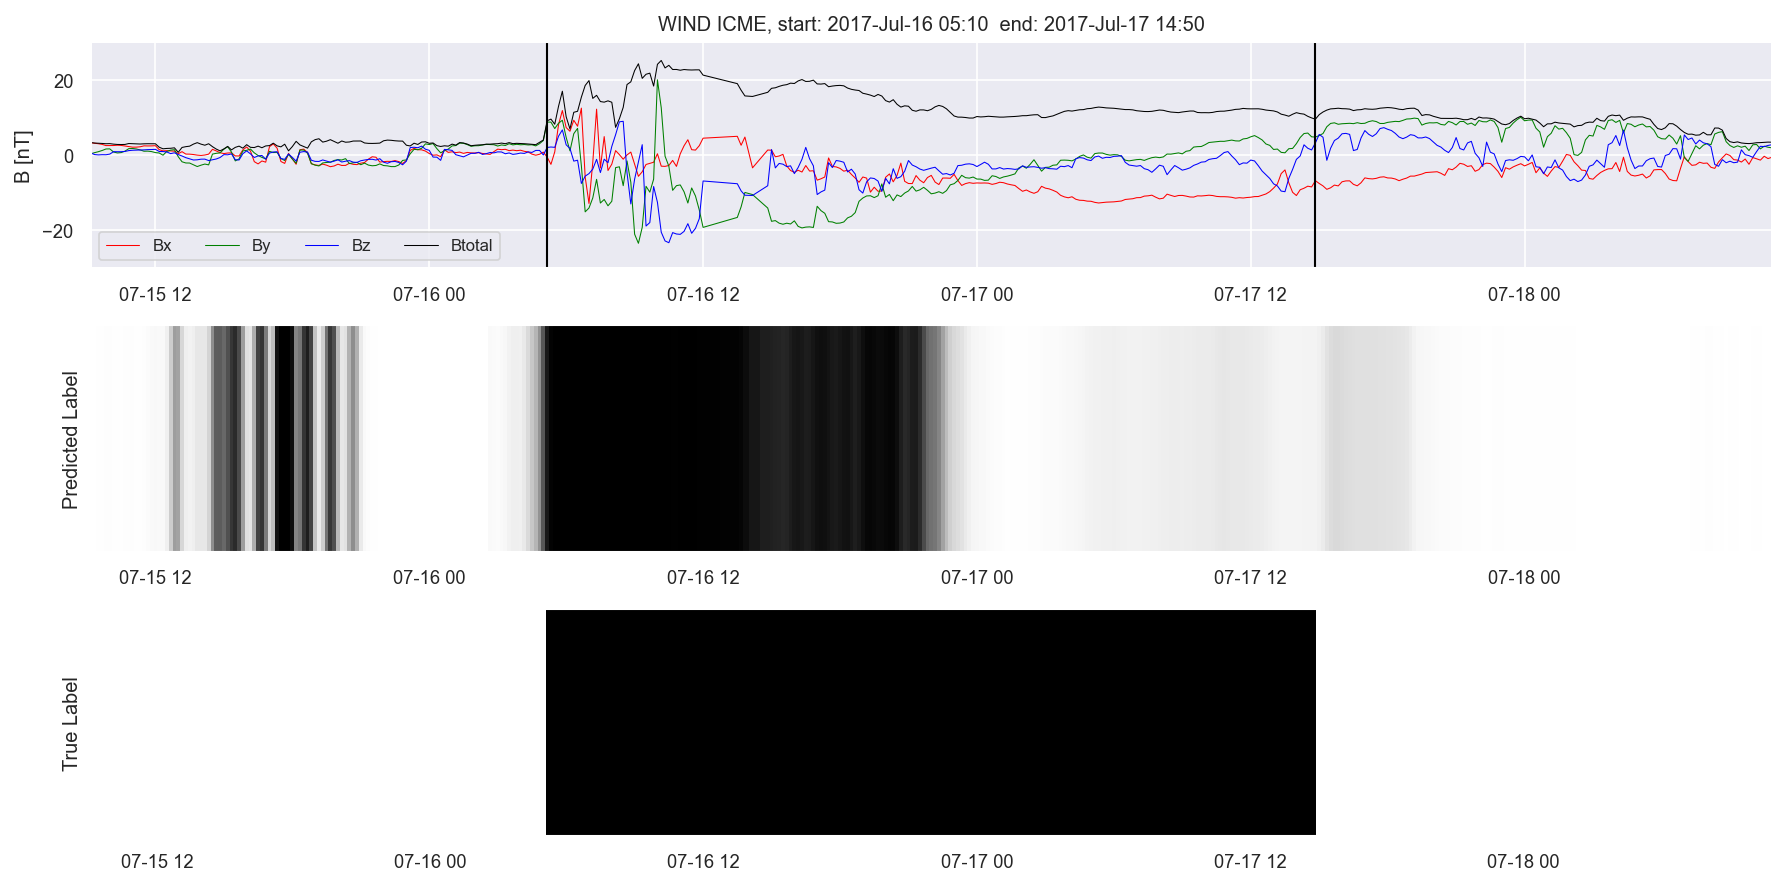

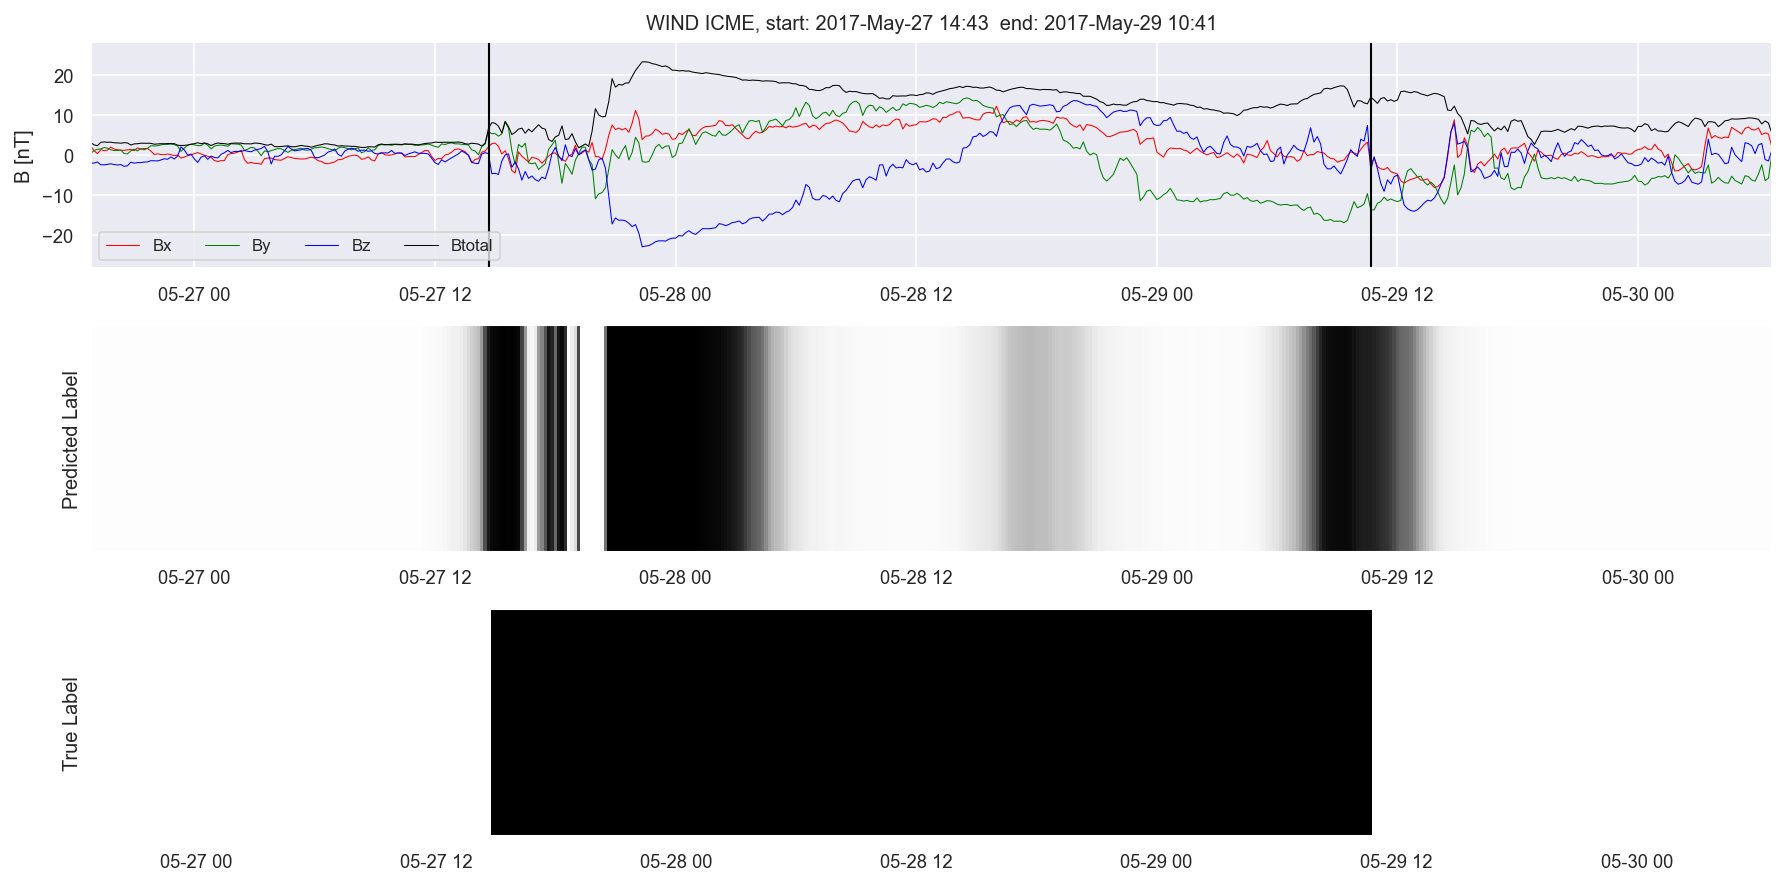

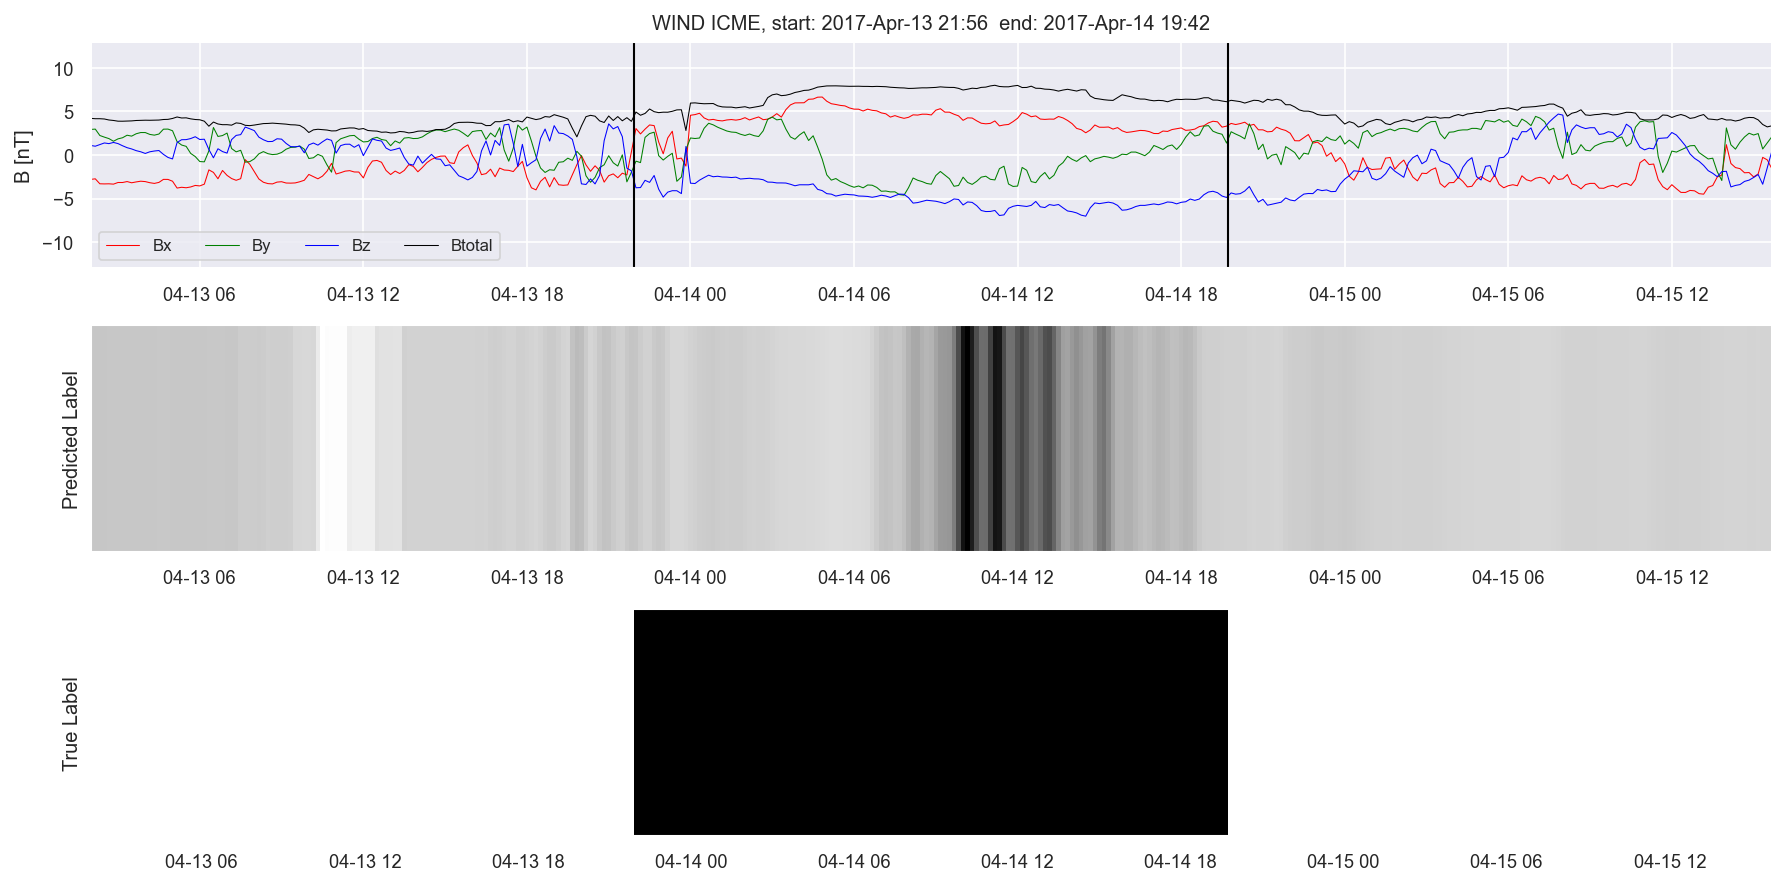

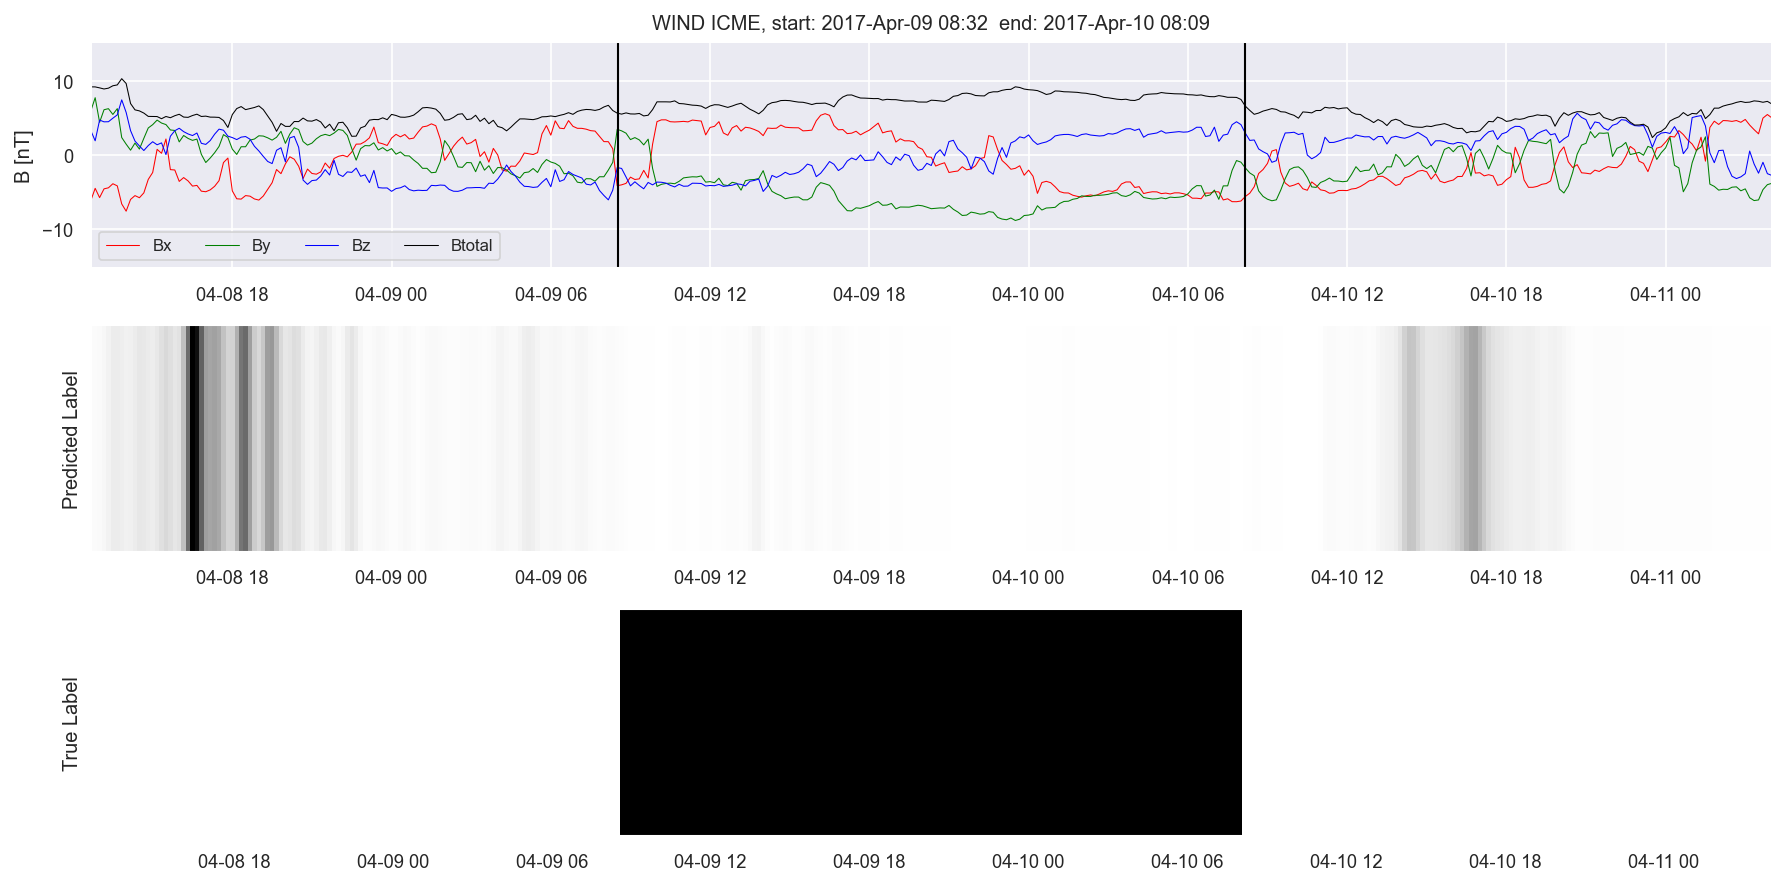

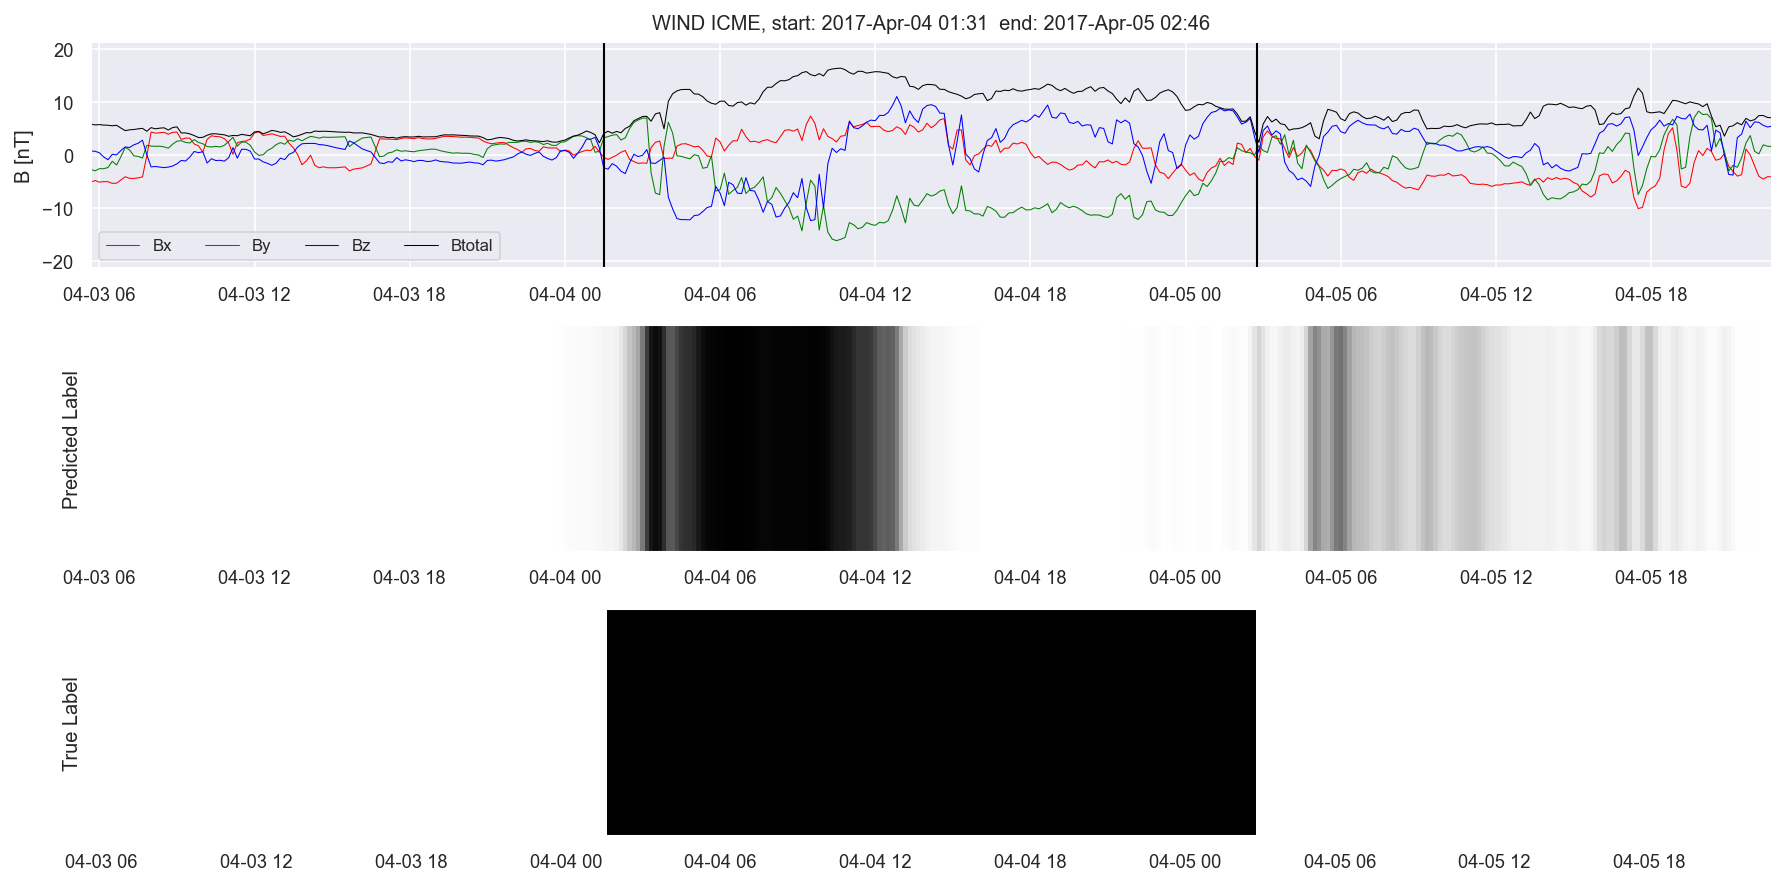

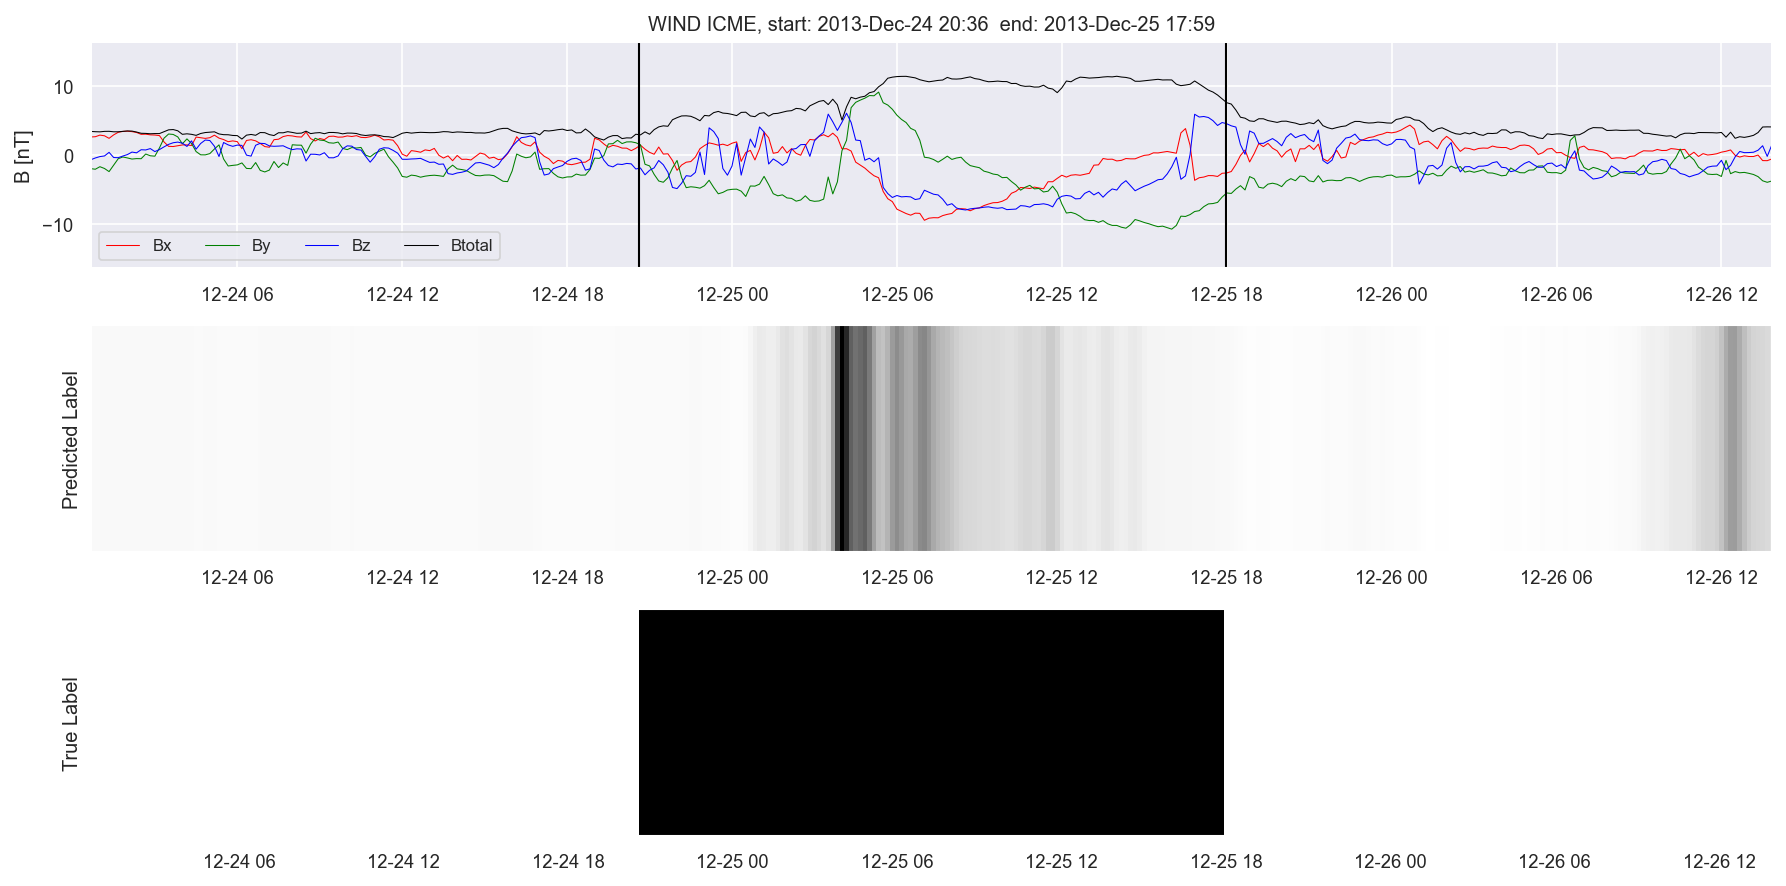

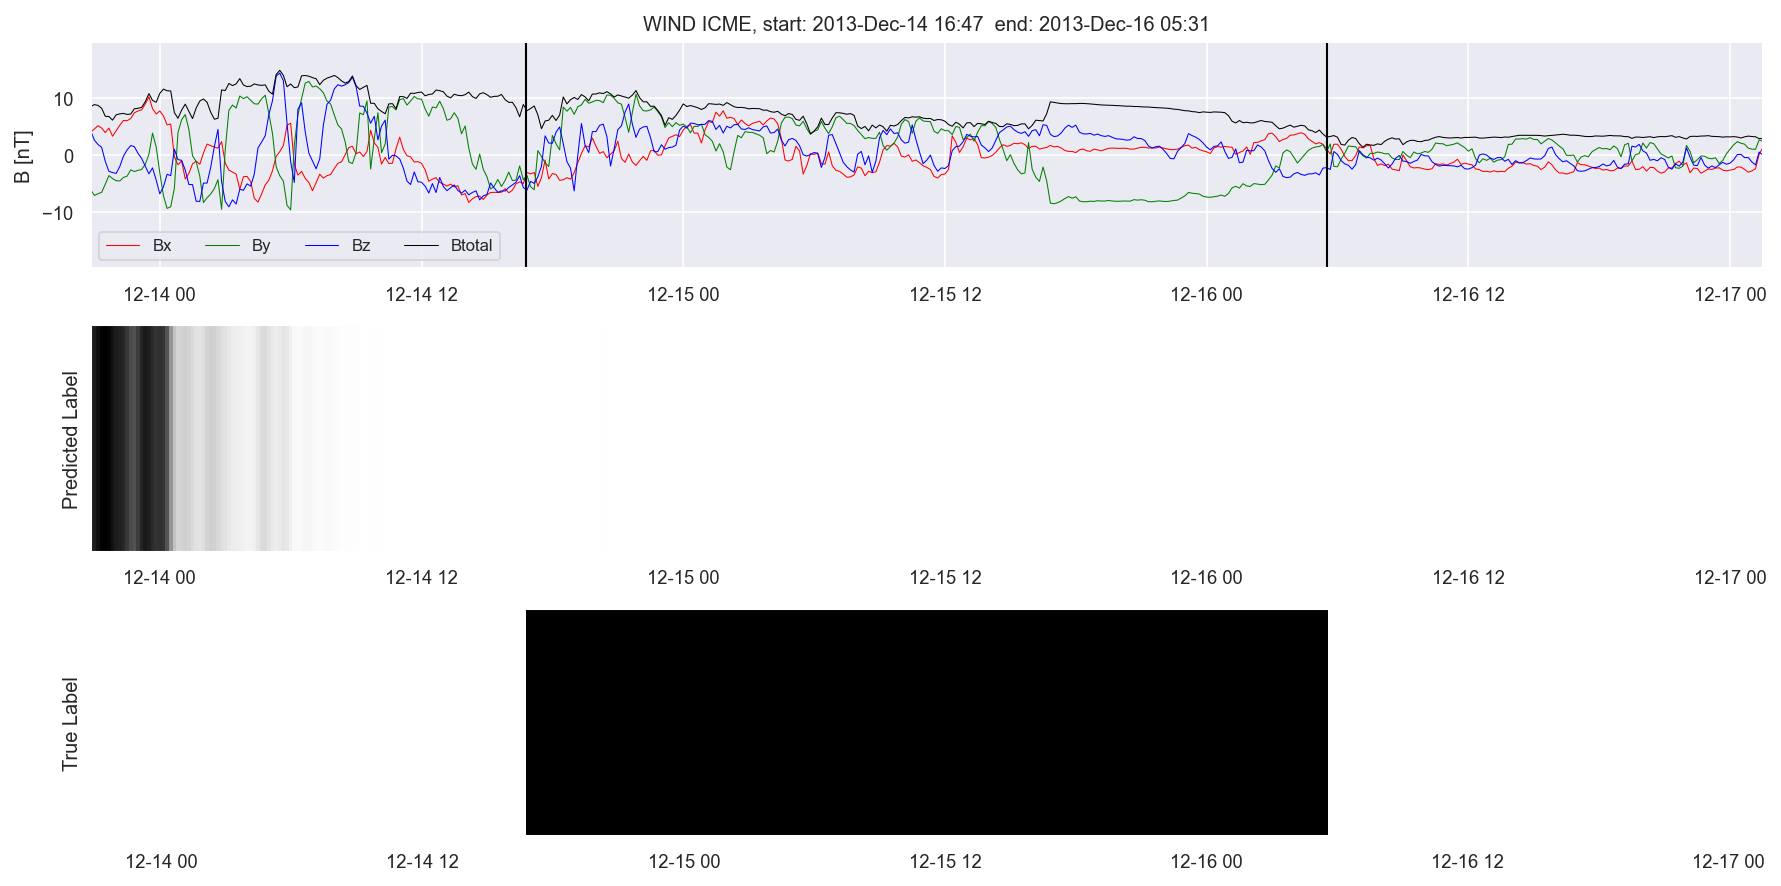

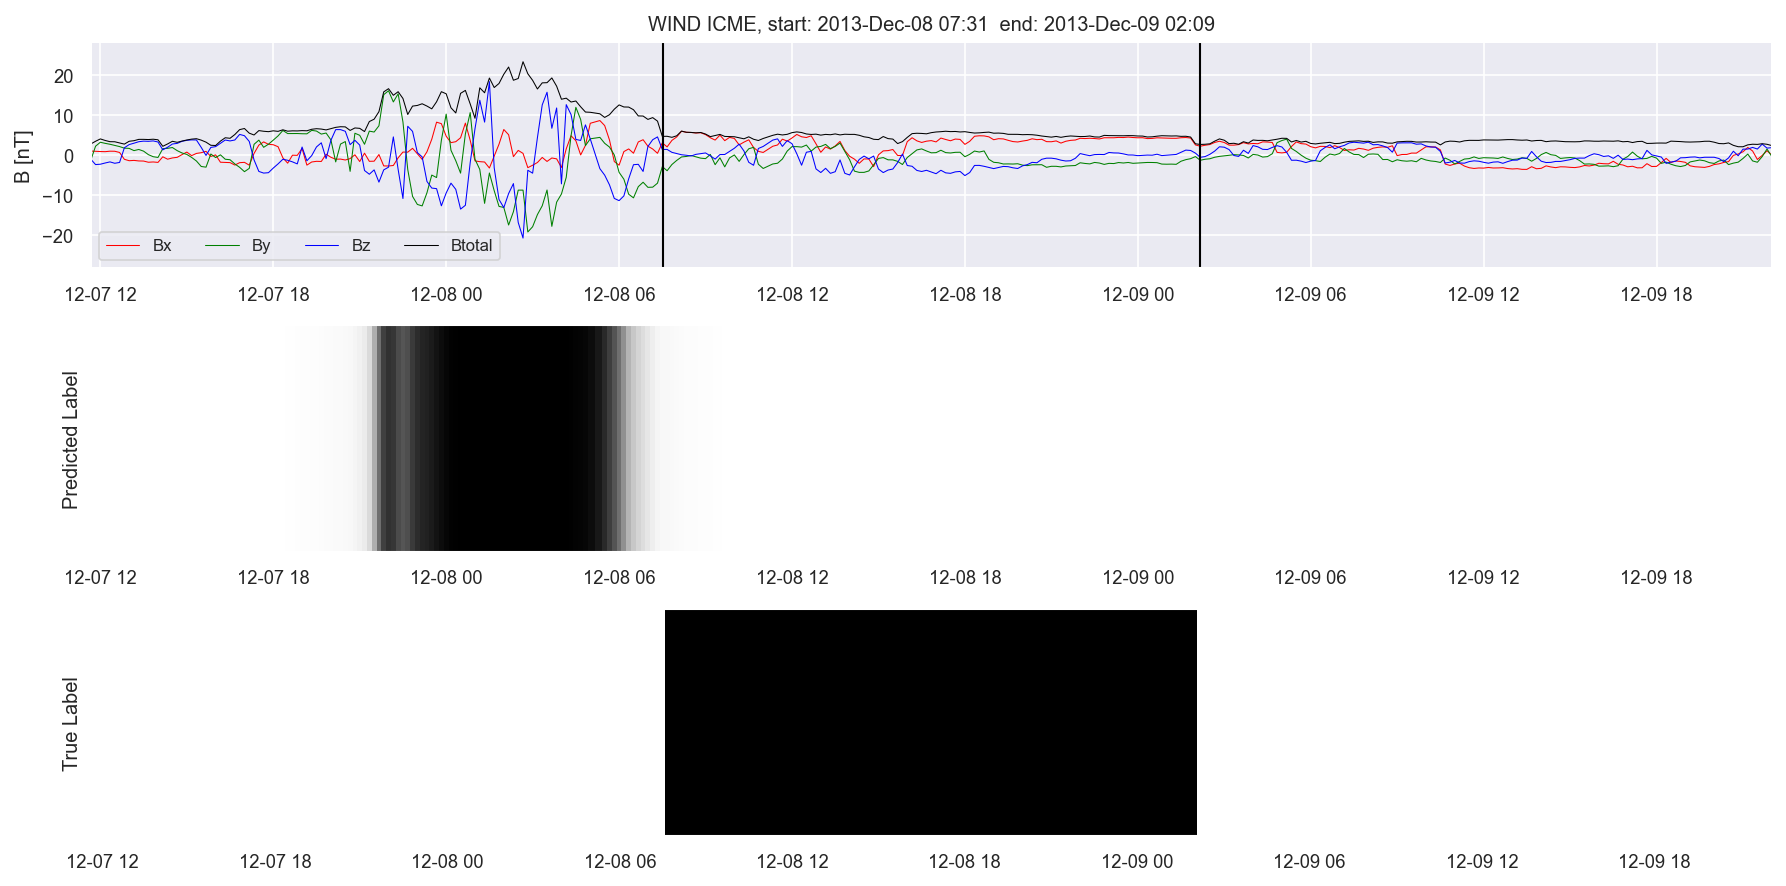

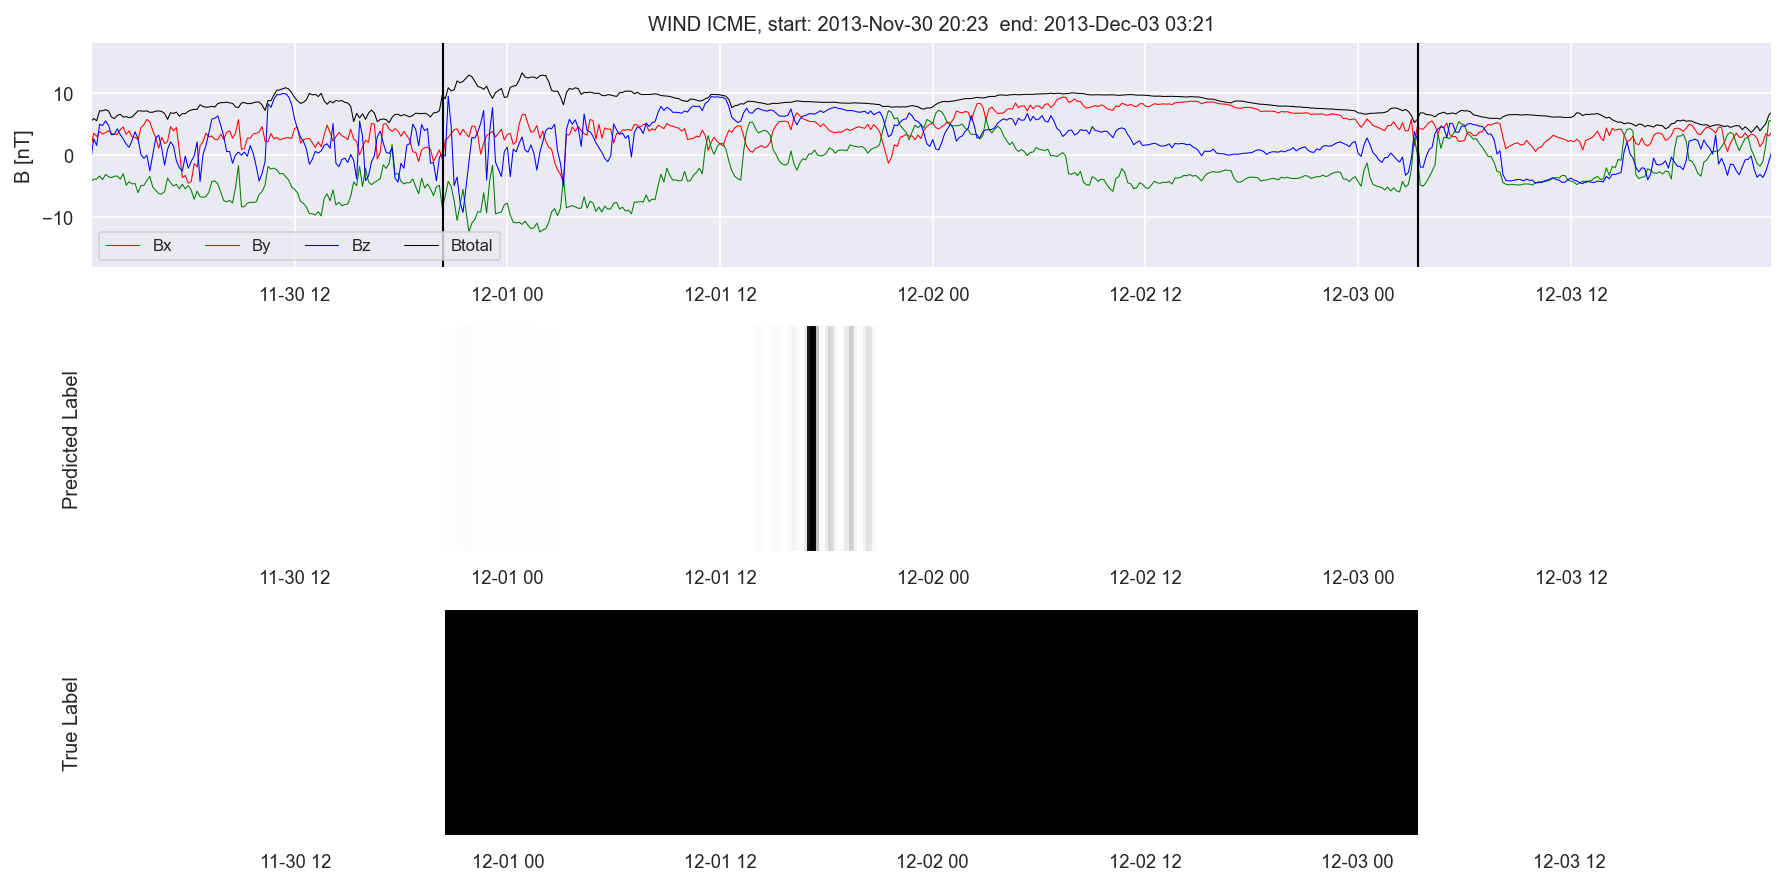

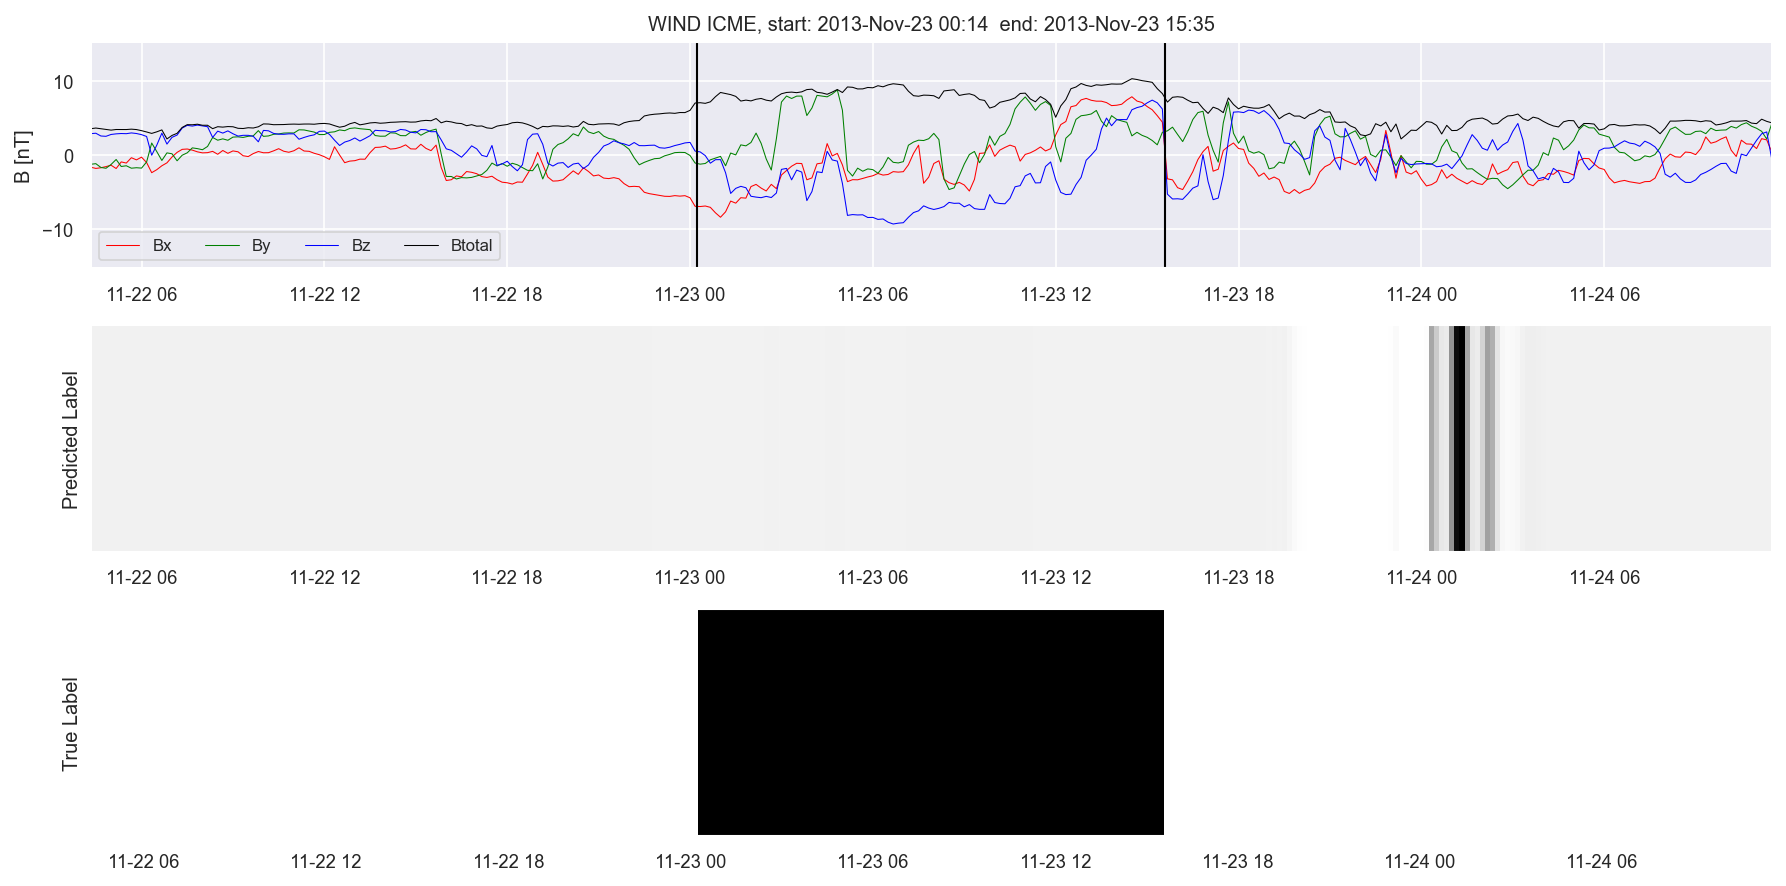

In [31]:
#Plot events and associated similarity values

for i in range(5, 15):
    test_clouds[i].plot_similaritymap(data.all_df,20,i,'WIND ',result)

In [32]:
# Score by event WIND

print('WIND:')

TP, FN, FP, detected = postprocess.evaluate(ICMEs, test_clouds, thres=0.1)
print('Precision is:',len(TP)/(len(TP)+len(FP)))
print('Recall is:',len(TP)/(len(TP)+len(FN)))
print('True Positives', len(TP))
print('False Negatives', len(FN))
print('False Positives', len(FP))

WIND:
Precision is: 0.1092436974789916
Recall is: 0.34210526315789475
True Positives 13
False Negatives 25
False Positives 106
